<a href="https://colab.research.google.com/github/RyanThawkho/Predicting-Male-Pattern-Baldness-Using-Image-and-Blood-Test-Data/blob/main/deep_learning_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *** DOWNLOADING & MERGING DATASETS + APPLYING CLAHE & GITHUB SEGMENTATION *** (no need to upload dataset, it is in drive + you can run all this section at once)

In [ ]:

# 2) Clone the repository and cd into it
!git clone https://github.com/YBIGTA/pytorch-hair-segmentation.git
import os
os.chdir('/content/pytorch-hair-segmentation')

# 3) Install necessary dependencies (PyTorch, OpenCV, NumPy)
!pip install --quiet torch torchvision opencv-contrib-python numpy

# 4) Download & prepare the Figaro-1k dataset (no args → creates ./data/Figaro1k)
!chmod +x data/figaro.sh
!bash data/figaro.sh

# 5) Copy Figaro-1k into /content for faster I/O
!cp -r data/Figaro1k /content/Figaro1k



Cloning into 'pytorch-hair-segmentation'...
remote: Enumerating objects: 427, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 427 (delta 5), reused 10 (delta 1), pack-reused 409 (from 1)
Receiving objects: 100% (427/427), 51.63 MiB | 52.13 MiB/s, done.
Resolving deltas: 100% (225/225), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 124.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 99.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.5 MB/s eta 0:00:00

Figaro1k segmentation training

In [ ]:
################################################################################
# Single Colab Cell: End‐to‐End Hair Segmentation with DeepLabV3+
# (Handling “Training” & “Testing” Subfolders with PBM Masks)
#
# This pipeline will:
#  1. Clone the YBIGTA hair‐segmentation repo.
#  2. Use its data/figaro.sh script to download Figaro‐1k into the repo’s data folder,
#     which creates:
#       • data/Figaro1k/Original/Training/FrameXXXXX-org.jpg
#       • data/Figaro1k/GT/Training/    FrameXXXXX-gt.pbm
#       (and similarly for “Testing” subfolders).
#  3. Train a DeepLabV3+ (ResNet‐50 backbone) model on all images in Original/Training.
#  4. Evaluate IoU/F1 on all images in Original/Testing.
#  5. Run inference on your own “flat_images” folder in Colab’s local storage to produce overlays.
#
# BEFORE RUNNING:
#  • Select GPU runtime: Runtime → Change runtime type → GPU.
#  • Create a folder “/content/flat_images/” via the Colab UI and upload your own .jpg/.png files there.
################################################################################

# (1) Install required libraries: PyTorch, TorchVision, OpenCV, tqdm
!pip install --quiet torch torchvision opencv-python tqdm

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet50
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import cv2
from tqdm import tqdm

################################################################################
# (2) Clone the YBIGTA repo & download Figaro‐1k locally
################################################################################

if not os.path.isdir('/content/pytorch-hair-segmentation'):
    !git clone https://github.com/YBIGTA/pytorch-hair-segmentation.git /content/pytorch-hair-segmentation

os.chdir('/content/pytorch-hair-segmentation')

# Run the provided script (no arguments) to download into data/Figaro1k
# !chmod +x data/figaro.sh
# !bash data/figaro.sh

# Confirm directory structure:
dataset_root = '/content/pytorch-hair-segmentation/data/Figaro1k'
assert os.path.isdir(os.path.join(dataset_root, 'Original', 'Training')),  "Original/Training not found"
assert os.path.isdir(os.path.join(dataset_root, 'Original', 'Testing')),  "Original/Testing not found"
assert os.path.isdir(os.path.join(dataset_root, 'GT', 'Training')),        "GT/Training not found"
assert os.path.isdir(os.path.join(dataset_root, 'GT', 'Testing')),         "GT/Testing not found"

################################################################################
# (3) Define a PyTorch Dataset class that matches “*‐org.jpg” to “*‐gt.pbm”
################################################################################

class FigaroHairDatasetNested(Dataset):
    def __init__(self, root_dir, split="train", img_size=256):
        """
        root_dir: "/content/pytorch-hair-segmentation/data/Figaro1k"
        split: "train"  → use all of Original/Training and corresponding GT/Training
               "test"   → use all of Original/Testing  and corresponding GT/Testing
        """
        self.root_dir = root_dir
        self.img_size = img_size

        if split == "train":
            img_dir  = os.path.join(root_dir, "Original", "Training")
            mask_dir = os.path.join(root_dir, "GT",       "Training")
        elif split == "test":
            img_dir  = os.path.join(root_dir, "Original", "Testing")
            mask_dir = os.path.join(root_dir, "GT",       "Testing")
        else:
            raise ValueError("split must be 'train' or 'test'")

        # List all image files ending with "-org.jpg"
        self.img_paths = sorted([
            os.path.join(img_dir, fname)
            for fname in os.listdir(img_dir)
            if fname.lower().endswith("-org.jpg")
        ])
        # For each image, compute corresponding mask by replacing "-org.jpg" → "-gt.pbm"
        self.mask_paths = []
        for img_path in self.img_paths:
            base = os.path.basename(img_path)               # e.g. "Frame00001-org.jpg"
            mask_name = base.replace("-org.jpg", "-gt.pbm")  # "Frame00001-gt.pbm"
            mask_path = os.path.join(mask_dir, mask_name)
            if not os.path.isfile(mask_path):
                raise FileNotFoundError(f"Mask file not found: {mask_path}")
            self.mask_paths.append(mask_path)

        # Transforms for images
        self.img_transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])
        # Transforms for masks (PBM loaded as grayscale)
        self.mask_transform = transforms.Compose([
            transforms.Resize((img_size, img_size), interpolation=Image.NEAREST),
            transforms.ToTensor(),  # yields shape (1,img_size,img_size) with values [0,1]
        ])

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path  = self.img_paths[idx]
        mask_path = self.mask_paths[idx]
        # Load image
        img  = Image.open(img_path).convert("RGB")
        # Load mask (PBM format is supported by PIL)
        mask = Image.open(mask_path).convert("L")
        # Apply transforms
        x = self.img_transform(img)             # (3, img_size, img_size)
        y = self.mask_transform(mask)           # (1, img_size, img_size)
        # Binary threshold: hair=1, background=0
        y = (y > 0.5).float()                   # (1, img_size, img_size)
        y = y.squeeze(0).long()                 # (img_size, img_size), dtype long
        return x, y

################################################################################
# (4) Instantiate DataLoaders for “train” and “test”
################################################################################

batch_size = 4
img_size   = 256

train_ds = FigaroHairDatasetNested(root_dir=dataset_root, split="train", img_size=img_size)
test_ds  = FigaroHairDatasetNested(root_dir=dataset_root, split="test",  img_size=img_size)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

################################################################################
# (5) Define the Model: DeepLabV3+ with a ResNet‐50 Backbone
################################################################################

model = deeplabv3_resnet50(pretrained_backbone=True, pretrained=False, num_classes=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

################################################################################
# (6) Training Loop: Loss, Optimizer, and Saving Checkpoints Locally
################################################################################

criterion = nn.CrossEntropyLoss()   # for 2‐class segmentation
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs  = 10
save_folder = "/content/models"
os.makedirs(save_folder, exist_ok=True)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for imgs, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        imgs  = imgs.to(device)    # (B,3,H,W)
        masks = masks.to(device)   # (B,H,W)

        optimizer.zero_grad()
        outputs = model(imgs)["out"]    # (B,2,H,W)
        loss    = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)

    epoch_loss = running_loss / len(train_ds)
    print(f"[Epoch {epoch+1}] Train Loss: {epoch_loss:.4f}")

    # Save a checkpoint for this epoch
    ckpt_path = os.path.join(save_folder, f"deeplabv3_epoch_{epoch:02d}.pth")
    torch.save(model.state_dict(), ckpt_path)
    print(f"Saved checkpoint: {ckpt_path}")

# After training finishes, the final checkpoint is:
final_ckpt = os.path.join(save_folder, f"deeplabv3_epoch_{num_epochs-1:02d}.pth")

################################################################################
# (7) Evaluate on “Testing” Folder Using the Final Checkpoint
################################################################################

model.load_state_dict(torch.load(final_ckpt))
model.eval()

test_iou_sum = 0.0
test_f1_sum  = 0.0
num_batches  = 0

with torch.no_grad():
    for imgs, masks in tqdm(test_loader, desc="Testing"):
        imgs  = imgs.to(device)
        masks = masks.to(device)

        outputs = model(imgs)["out"]       # (B,2,H,W)
        preds   = torch.argmax(outputs, dim=1)  # (B,H,W)

        preds_flat = preds.view(-1)
        masks_flat = masks.view(-1)

        inter = torch.sum((preds_flat == 1) & (masks_flat == 1)).item()
        union = torch.sum((preds_flat == 1) | (masks_flat == 1)).item()
        iou   = 1.0 if union == 0 else inter / union

        TP = inter
        FP = torch.sum((preds_flat == 1) & (masks_flat == 0)).item()
        FN = torch.sum((preds_flat == 0) & (masks_flat == 1)).item()
        f1 = 1.0 if (2 * TP + FP + FN) == 0 else 2 * TP / (2 * TP + FP + FN)

        test_iou_sum += iou
        test_f1_sum  += f1
        num_batches  += 1

avg_test_iou = test_iou_sum / num_batches
avg_test_f1  = test_f1_sum / num_batches
print(f"Testing Results → IoU: {avg_test_iou:.4f},  F1: {avg_test_f1:.4f}")



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to 

[Epoch 1] Train Loss: 0.2317
Saved checkpoint: /content/models/deeplabv3_epoch_00.pth


Epoch 2/10 [Train]: 100%|██████████| 210/210 [00:07<00:00, 28.52it/s]


[Epoch 2] Train Loss: 0.1760
Saved checkpoint: /content/models/deeplabv3_epoch_01.pth


Epoch 3/10 [Train]: 100%|██████████| 210/210 [00:07<00:00, 28.03it/s]


[Epoch 3] Train Loss: 0.1568
Saved checkpoint: /content/models/deeplabv3_epoch_02.pth


Epoch 4/10 [Train]: 100%|██████████| 210/210 [00:07<00:00, 28.25it/s]


[Epoch 4] Train Loss: 0.1313
Saved checkpoint: /content/models/deeplabv3_epoch_03.pth


Epoch 5/10 [Train]: 100%|██████████| 210/210 [00:07<00:00, 28.29it/s]


[Epoch 5] Train Loss: 0.1391
Saved checkpoint: /content/models/deeplabv3_epoch_04.pth


Epoch 6/10 [Train]: 100%|██████████| 210/210 [00:07<00:00, 27.95it/s]


[Epoch 6] Train Loss: 0.1213
Saved checkpoint: /content/models/deeplabv3_epoch_05.pth


Epoch 7/10 [Train]: 100%|██████████| 210/210 [00:07<00:00, 28.40it/s]


[Epoch 7] Train Loss: 0.1242
Saved checkpoint: /content/models/deeplabv3_epoch_06.pth


Epoch 8/10 [Train]: 100%|██████████| 210/210 [00:07<00:00, 28.16it/s]


[Epoch 8] Train Loss: 0.1015
Saved checkpoint: /content/models/deeplabv3_epoch_07.pth


Epoch 9/10 [Train]: 100%|██████████| 210/210 [00:07<00:00, 27.99it/s]


[Epoch 9] Train Loss: 0.1077
Saved checkpoint: /content/models/deeplabv3_epoch_08.pth


Epoch 10/10 [Train]: 100%|██████████| 210/210 [00:07<00:00, 27.97it/s]


[Epoch 10] Train Loss: 0.0901
Saved checkpoint: /content/models/deeplabv3_epoch_09.pth


Testing: 100%|██████████| 53/53 [00:01<00:00, 42.14it/s]

Testing Results → IoU: 0.8824,  F1: 0.9364


In [ ]:
# ################################################################################
# # (8) Upload DeepLabV3+ Hair Segmentation Model to Hugging Face Hub
# ################################################################################

# !pip install -q huggingface_hub

# from huggingface_hub import login, create_repo, upload_folder
# import json

# # 🔐 Log in to Hugging Face (you'll paste your token once)
# login()

# # Define repo info
# #hf_username = "RyanThawkho"  # ← CHANGE THIS
# hf_username = "alamb98"  # ← CHANGE THIS
# repo_name   = "deeplabv3-hair-segmentation"
# repo_id     = f"{hf_username}/{repo_name}"

# # Create model repo if it doesn't exist yet
# create_repo(repo_id, repo_type="model", exist_ok=True)

# # Save final model weights (if not already done)
# torch.save(model.state_dict(), "deeplabv3_final.pth")

# # Save basic metadata
# metadata = {
#     "model_name": "DeepLabV3+ (ResNet50 backbone)",
#     "image_size": [img_size, img_size],
#     "num_classes": 2,
#     "labels": ["background", "hair"],
#     "test_iou": round(avg_test_iou, 4),
#     "test_f1": round(avg_test_f1, 4)
# }
# with open("metadata.json", "w") as f:
#     json.dump(metadata, f)

# # Upload to Hugging Face (only the files we want)
# upload_folder(
#     folder_path=".",
#     repo_id=repo_id,
#     repo_type="model",
#     allow_patterns=["deeplabv3_final.pth", "metadata.json"]
# )

# print(f"✅ Model uploaded to: https://huggingface.co/{repo_id}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


HfHubHTTPError: 401 Client Error: Unauthorized for url: https://huggingface.co/api/repos/create (Request ID: Root=1-68a21b41-4cb82f41599ae95258cc2101;6dd082c9-5ef7-4bbf-a622-73c6312c6d3b)

Invalid username or password.

download & combine our two datasets

In [ ]:
# (0) Install necessary tools
!pip install --quiet gdown

import os
import zipfile
import shutil
import gdown

################################################################################
# (1) GOOGLE DRIVE LINKS FOR THE TWO ZIP FILES
#     Replace these with your actual shareable links.
################################################################################

LINK_ZIP1 = "https://drive.google.com/file/d/1nP7u3PqnvdYEUnE9oxRo-SAvOO28w_Az/view?usp=drive_link"
LINK_ZIP2 = "https://drive.google.com/file/d/1iRoI1JI7kVPP4dFbR1xiZM4lOpf9Osy5/view?usp=drive_link"

def download_from_drive(shareable_link: str, dest_path: str):
    """
    Given a Google Drive shareable link, download the file to dest_path using gdown.
    """
    file_id = shareable_link.split("/d/")[1].split("/")[0]
    gdown_url = f"https://drive.google.com/uc?export=download&id={file_id}"
    print(f"Downloading {shareable_link} → {dest_path}")
    gdown.download(gdown_url, dest_path, quiet=False)

# Paths where we'll save the two downloaded ZIPs
ZIP1_PATH = "/content/dataset1.zip"
ZIP2_PATH = "/content/dataset2.zip"

download_from_drive(LINK_ZIP1, ZIP1_PATH)
download_from_drive(LINK_ZIP2, ZIP2_PATH)

################################################################################
# (2) UNZIP EACH INTO ITS OWN FOLDER
################################################################################

UNZIP_DIR1 = "/content/unzipped_dataset1"
UNZIP_DIR2 = "/content/unzipped_dataset2"

def reset_dir(path: str):
    if os.path.isdir(path):
        shutil.rmtree(path)
    os.makedirs(path, exist_ok=True)

reset_dir(UNZIP_DIR1)
reset_dir(UNZIP_DIR2)

print(f"Unzipping {ZIP1_PATH} → {UNZIP_DIR1}")
with zipfile.ZipFile(ZIP1_PATH, "r") as zf1:
    zf1.extractall(UNZIP_DIR1)

print(f"Unzipping {ZIP2_PATH} → {UNZIP_DIR2}")
with zipfile.ZipFile(ZIP2_PATH, "r") as zf2:
    zf2.extractall(UNZIP_DIR2)

################################################################################
# (3) INSPECT and LOCATE the TRUE “BASE” FOLDER containing train/valid/test
#
# We write a helper that skips any “__MACOSX” and finds a subfolder that
# contains “train” (i.e., has a “train” directory).
################################################################################

def find_split_base(unzip_dir: str) -> str:
    """
    Traverse one level down under unzip_dir, ignoring folders named "__MACOSX".
    If any folder at that level contains a 'train' subdirectory, return its path.
    If unzip_dir itself contains 'train', return unzip_dir.
    Otherwise, raise an error.
    """
    # Case A: unzip_dir/train exists
    if os.path.isdir(os.path.join(unzip_dir, "train")):
        return unzip_dir

    # Otherwise check children (skip "__MACOSX")
    for child in sorted(os.listdir(unzip_dir)):
        if child.startswith("__MACOSX"):
            continue
        child_path = os.path.join(unzip_dir, child)
        if os.path.isdir(child_path) and os.path.isdir(os.path.join(child_path, "train")):
            return child_path

    raise FileNotFoundError(
        f"Could not locate a 'train' folder under {unzip_dir} or its valid child."
    )

# Determine BASE1 and BASE2 automatically
BASE1 = find_split_base(UNZIP_DIR1)
BASE2 = find_split_base(UNZIP_DIR2)
print(f"Detected BASE1 = {BASE1}")
print(f"Detected BASE2 = {BASE2}")

# (Optional) Show contents at that base to double-check
print("\nContents at BASE1 (first two levels):")
!find "{BASE1}" -maxdepth 2 | sed 's/^/  /'
print("\nContents at BASE2 (first two levels):")
!find "{BASE2}" -maxdepth 2 | sed 's/^/  /'

################################################################################
# (4) DEFINE COMBINED OUTPUT DIRECTORY
################################################################################

COMBINED_DIR = "/content/norwood_dataset_combined"
reset_dir(COMBINED_DIR)

################################################################################
# (5) MERGE “train/Level X”, “valid/Level X”, “test/Level X” FROM BOTH BASES
#
# Copy every .jpg/.jpeg/.png under BASE1/<split>/<level>/ and BASE2/<split>/<level>/
# into COMBINED_DIR/<split>/<level>/. If a filename collides, append "_dup".
################################################################################

def merge_split_levels(src_base: str, dst_base: str):
    for split in ["train", "valid", "test"]:
        for level in [f"Level {i}" for i in range(2, 8)]:
            src_dir = os.path.join(src_base, split, level)
            dst_dir = os.path.join(dst_base, split, level)

            if not os.path.isdir(src_dir):
                continue

            os.makedirs(dst_dir, exist_ok=True)

            for fname in os.listdir(src_dir):
                lower = fname.lower()
                if not (lower.endswith(".jpg") or lower.endswith(".jpeg") or lower.endswith(".png")):
                    continue

                src_path = os.path.join(src_dir, fname)
                dst_path = os.path.join(dst_dir, fname)

                # If a file of same name exists, append "_dup"
                if os.path.exists(dst_path):
                    name, ext = os.path.splitext(fname)
                    dst_path = os.path.join(dst_dir, f"{name}_dup{ext}")

                shutil.copyfile(src_path, dst_path)

print("Merging unzipped_dataset1 → combined")
merge_split_levels(BASE1, COMBINED_DIR)

print("Merging unzipped_dataset2 → combined")
merge_split_levels(BASE2, COMBINED_DIR)

print(f"\n✅ Done! Combined dataset is now at: {COMBINED_DIR}")
for split in ["train", "valid", "test"]:
    for level in [f"Level {i}" for i in range(2, 8)]:
        combined_path = os.path.join(COMBINED_DIR, split, level)
        if os.path.isdir(combined_path):
            count = len(os.listdir(combined_path))
            print(f"  • {split}/{level}: {count} files")


Downloading...
From (original): https://drive.google.com/uc?export=download&id=1nP7u3PqnvdYEUnE9oxRo-SAvOO28w_Az
From (redirected): https://drive.google.com/uc?export=download&id=1nP7u3PqnvdYEUnE9oxRo-SAvOO28w_Az&confirm=t&uuid=6834c79d-bf52-4b13-9dae-8cc7aedd244b
To: /content/dataset1.zip
100%|██████████| 98.0M/98.0M [00:00<00:00, 117MB/s]


Downloading...
From (original): https://drive.google.com/uc?export=download&id=1iRoI1JI7kVPP4dFbR1xiZM4lOpf9Osy5
From (redirected): https://drive.google.com/uc?export=download&id=1iRoI1JI7kVPP4dFbR1xiZM4lOpf9Osy5&confirm=t&uuid=8cd1673a-f015-468b-b7f7-7798375bac79
To: /content/dataset2.zip
100%|██████████| 126M/126M [00:01<00:00, 104MB/s]


Unzipping /content/dataset1.zip → /content/unzipped_dataset1
Unzipping /content/dataset2.zip → /content/unzipped_dataset2
Detected BASE1 = /content/unzipped_dataset1/hyehye2.v3i.folder
Detected BASE2 = /content/unzipped_dataset2/Hexa.v1-hexa DATASET.folder

Contents at BASE1 (first two levels):
  /content/unzipped_dataset1/hyehye2.v3i.folder
  /content/unzipped_dataset1/hyehye2.v3i.folder/valid
  /content/unzipped_dataset1/hyehye2.v3i.folder/valid/Level 5
  /content/unzipped_dataset1/hyehye2.v3i.folder/valid/Level 2
  /content/unzipped_dataset1/hyehye2.v3i.folder/valid/Level 4
  /content/unzipped_dataset1/hyehye2.v3i.folder/valid/Level 7
  /content/unzipped_dataset1/hyehye2.v3i.folder/valid/Level 6
  /content/unzipped_dataset1/hyehye2.v3i.folder/valid/Level 3
  /content/unzipped_dataset1/hyehye2.v3i.folder/valid/.DS_Store
  /content/unzipped_dataset1/hyehye2.v3i.folder/test
  /content/unzipped_dataset1/hyehye2.v3i.folder/test/Level 5
  /content/unzipped_dataset1/hyehye2.v3i.folder/test

Segment our dataset

In [ ]:
# # ────────────────────────────────────────────────────────────────
# # UPLOAD THE TRAINED MODEL CHECKPOINT TO HUGGING FACE
# # ────────────────────────────────────────────────────────────────
# !pip install --quiet huggingface_hub

# from huggingface_hub import login, create_repo, upload_file

# # 1. Log into Hugging Face
# login(token="your_huggingface_token")  # Replace with your HF token

# # 2. Create or point to your repo
# repo_id = "your-username/deeplabv3-hair-segmentation"  # Choose a name
# create_repo(repo_id, private=True)  # Set to public=False if you want it private

# # 3. Upload the checkpoint
# upload_file(
#     path_or_fileobj="/content/models/deeplabv3_epoch_09.pth",  # Your model file
#     path_in_repo="deeplabv3_epoch_09.pth",                      # How it appears in repo
#     repo_id=repo_id,
#     repo_type="model"
# )

HTTPError: Invalid user token.

## ***Segmentation with lines not fill***

In [ ]:
# ────────────────────────────────────────────────────────────────────────────────
# COLAB‐CELL: Run Hair Segmentation on train/valid/test → Save Boundary‐Only Overlays
#             under /content/segmented_boundary/<split>/Level X/…
#
# Instead of filling the entire hair region in solid red, this version draws only
# the red outline (contour) of the detected hair mask on top of the original image.
#
# Assumes:
#  • Your ZIP (already unzipped) created these folders:
#      /content/norwood_dataset/hyehye2.v3i.folder/train/Level 2 … Level 7/
#      /content/norwood_dataset/hyehye2.v3i.folder/valid/Level 2 … Level 7/
#      /content/norwood_dataset/hyehye2.v3i.folder/test/Level 2 … Level 7/
#  • You have a DeepLabV3+ checkpoint at /content/models/deeplabv3_epoch_09.pth
#  • You want to save “hair‐region boundary in red” overlays for all images.
#
# After this cell finishes, browse in Colab’s left “Files” pane under
# /content/segmented_boundary/ to see the saved boundary overlays.
# ────────────────────────────────────────────────────────────────────────────────

!pip install --quiet torch torchvision opencv-python tqdm

import os
import torch
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet50
from PIL import Image
import numpy as np
import cv2
from tqdm import tqdm

# 1) Load the pretrained DeepLabV3+ model checkpoint
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CHECKPOINT_PATH = "/content/models/deeplabv3_epoch_09.pth"  # <— adjust if needed

model = deeplabv3_resnet50(pretrained_backbone=True, pretrained=False, num_classes=2)
model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=DEVICE))
model.to(DEVICE)
model.eval()

# 2) Define the same image transforms used during segmentation inference
IMG_SIZE = 256
transform_img = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# 3) Point to your “ordinarily‐located” folders of raw images
BASE = "/content/norwood_dataset_combined"
SPLITS = ["train", "valid", "test"]
LEVELS = [f"Level {i}" for i in range(2, 8)]  # ["Level 2", "Level 3", … "Level 7"]

# 4) Create /content/segmented_boundary/<split>/Level X/… if they don’t already exist
SEGMENTED_BOUNDARY_ROOT = "/content/segmented_boundary"
for split in SPLITS:
    for lvl in LEVELS:
        os.makedirs(os.path.join(SEGMENTED_BOUNDARY_ROOT, split, lvl), exist_ok=True)

# 5) Loop over each split (train/valid/test) & each Level X, run segmentation,
#    find contours of hair mask, draw red contours on original, and save
for split in SPLITS:
    print(f"\n▶ Processing {split.upper()} set …")
    for lvl in LEVELS:
        raw_dir = os.path.join(BASE, split, lvl)
        save_dir = os.path.join(SEGMENTED_BOUNDARY_ROOT, split, lvl)

        if not os.path.isdir(raw_dir):
            raise FileNotFoundError(f"Expected folder not found: {raw_dir}")

        print(f"  • Level: {lvl}  →  {len(os.listdir(raw_dir))} images")
        for fname in tqdm(os.listdir(raw_dir), desc=f"    {lvl}", leave=False):
            if not fname.lower().endswith((".jpg", ".jpeg", ".png", ".bmp")):
                continue

            # Load the raw image
            img_path = os.path.join(raw_dir, fname)
            orig = Image.open(img_path).convert("RGB")

            # Resize to model’s expected size
            resized = orig.resize((IMG_SIZE, IMG_SIZE))
            x = transform_img(resized).unsqueeze(0).to(DEVICE)  # (1,3,256,256)

            # Forward‐pass → get binary mask (0=background, 1=hair)
            with torch.no_grad():
                out = model(x)["out"]                             # (1,2,256,256)
                pred = torch.argmax(out, dim=1).squeeze(0).cpu().numpy()  # (256,256)

            # Resize mask back to original image resolution
            mask_resized = cv2.resize(pred.astype(np.uint8),
                                      (orig.width, orig.height),
                                      interpolation=cv2.INTER_NEAREST)

            # Convert mask to 8‐bit single‐channel for contour detection
            mask_uint8 = (mask_resized * 255).astype(np.uint8)

            # 6) Find contours of the hair region
            contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # 7) Draw red contours on top of the original
            overlay = np.array(orig).astype(np.uint8).copy()
            cv2.drawContours(overlay, contours, -1, color=(255, 0, 0), thickness=2)  # (H,W,3), BGR by OpenCV

            # Note: cv2 draws in BGR by default; convert original to BGR before drawing:
            # Actually, overlay is in RGB, so we need to convert the color tuple:
            # But here, cv2.drawContours expects BGR if the image is a NumPy array in BGR.
            # Since `overlay` is actually in RGB order, we can swap the color channels:
            #   overlay[..., [2,1,0]] if needed.
            # To keep it simple, let's convert overlay to BGR, draw, then convert back:

            # Step a) Convert RGB→BGR
            overlay_bgr = cv2.cvtColor(np.array(orig).astype(np.uint8), cv2.COLOR_RGB2BGR)
            cv2.drawContours(overlay_bgr, contours, -1, color=(0, 0, 255), thickness=2)  # Red in BGR
            # Step b) Convert back to RGB
            overlay_rgb = cv2.cvtColor(overlay_bgr, cv2.COLOR_BGR2RGB)

            # 8) Save just the contour overlay (no blending)
            base_name = os.path.splitext(fname)[0]
            out_name = base_name + "_boundary.png"
            out_path = os.path.join(save_dir, out_name)
            Image.fromarray(overlay_rgb).save(out_path)

    print(f"✔ Finished boundary‐only segmentation for {split}.\n")

print("\n✅ All boundary‐only overlays are now saved under /content/segmented_boundary/")





/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to 


▶ Processing TRAIN set …
  • Level: Level 2  →  3963 images


  • Level: Level 3  →  2139 images


  • Level: Level 4  →  1149 images


  • Level: Level 5  →  712 images


  • Level: Level 6  →  572 images


  • Level: Level 7  →  534 images


✔ Finished boundary‐only segmentation for train.


▶ Processing VALID set …
  • Level: Level 2  →  388 images


  • Level: Level 3  →  210 images


  • Level: Level 4  →  125 images


  • Level: Level 5  →  77 images


  • Level: Level 6  →  42 images


  • Level: Level 7  →  53 images


✔ Finished boundary‐only segmentation for valid.


▶ Processing TEST set …
  • Level: Level 2  →  210 images


  • Level: Level 3  →  95 images


  • Level: Level 4  →  51 images


  • Level: Level 5  →  13 images


  • Level: Level 6  →  20 images


  • Level: Level 7  →  27 images


✔ Finished boundary‐only segmentation for test.


✅ All boundary‐only overlays are now saved under /content/segmented_boundary/


Apply clahe on the segmented dataset

In [ ]:
import os
import cv2

# ────────────────────────────────────────────────────────────────────────────────
# (A) Change these two paths to match your environment
# ────────────────────────────────────────────────────────────────────────────────

INPUT_ROOT  = "/content/segmented_boundary"
OUTPUT_ROOT = "/content/segmented_boundary_clahe"

# ────────────────────────────────────────────────────────────────────────────────
# (B) CLAHE setup
# ────────────────────────────────────────────────────────────────────────────────

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

# ────────────────────────────────────────────────────────────────────────────────
# (C) Walk splits → levels → images, apply CLAHE, save to OUTPUT_ROOT
# ────────────────────────────────────────────────────────────────────────────────

for split in ["train", "valid", "test"]:
    split_in_dir  = os.path.join(INPUT_ROOT, split)
    split_out_dir = os.path.join(OUTPUT_ROOT, split)

    if not os.path.isdir(split_in_dir):
        print(f"[WARN] Skipping missing split folder: {split_in_dir}")
        continue

    # Create the split folder in the output if it doesn't exist
    os.makedirs(split_out_dir, exist_ok=True)

    # Each “level” subfolder (Level 2, Level 3, … Level 7)
    for level_folder in sorted(os.listdir(split_in_dir)):
        level_in_path = os.path.join(split_in_dir, level_folder)
        if not os.path.isdir(level_in_path):
            continue  # skip any stray files

        # Create the same level subfolder in output
        level_out_path = os.path.join(split_out_dir, level_folder)
        os.makedirs(level_out_path, exist_ok=True)

        # Process each image in this level folder (allow .jpg, .jpeg, .png)
        for img_name in sorted(os.listdir(level_in_path)):
            lower = img_name.lower()
            if not (lower.endswith(".jpg") or lower.endswith(".jpeg") or lower.endswith(".png")):
                continue

            input_path  = os.path.join(level_in_path, img_name)
            output_name = os.path.splitext(img_name)[0] + ".png"  # save as .png
            output_path = os.path.join(level_out_path, output_name)

            img = cv2.imread(input_path)
            if img is None:
                print(f"  [SKIP] Could not read image: {input_path}")
                continue

            try:
                # Convert BGR → LAB
                lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
                l, a, b = cv2.split(lab)

                # Apply CLAHE on the L channel
                cl = clahe.apply(l)

                # Merge the enhanced L channel back with A and B
                merged = cv2.merge((cl, a, b))

                # Convert LAB → BGR
                enhanced_img = cv2.cvtColor(merged, cv2.COLOR_LAB2BGR)

                # Save as PNG (retaining the same basename)
                cv2.imwrite(output_path, enhanced_img)
                print(f"  ✓ Saved CLAHE: {output_path}")

            except Exception as e:
                print(f"  [ERROR] processing {input_path}: {e}")

print("\n➡️  Done with CLAHE preprocessing.")


Streaming output truncated to the last 5000 lines.
  ✓ Saved CLAHE: /content/segmented_boundary_clahe/train/Level 3/35-Front_jpg.rf.e22b22afeec320139c81f82385cfad4b_boundary.png
  ✓ Saved CLAHE: /content/segmented_boundary_clahe/train/Level 3/35-Left_jpg.rf.26226d8eb70f5d35f94b7b285736a9ed_boundary.png
  ✓ Saved CLAHE: /content/segmented_boundary_clahe/train/Level 3/35-Left_jpg.rf.868ab98c15036feb50b1506ef6af8b5a_boundary.png
  ✓ Saved CLAHE: /content/segmented_boundary_clahe/train/Level 3/35-Left_jpg.rf.e5490b8324debf31c7ff55d6ee063ac3_boundary.png
  ✓ Saved CLAHE: /content/segmented_boundary_clahe/train/Level 3/35-Right_jpg.rf.3b90068fae8c885f96bb2bfd88fc2c6e_boundary.png
  ✓ Saved CLAHE: /content/segmented_boundary_clahe/train/Level 3/35-Right_jpg.rf.81e70978b9d99e04919448759f654e32_boundary.png
  ✓ Saved CLAHE: /content/segmented_boundary_clahe/train/Level 3/35-Right_jpg.rf.d00e0b729b91387a1a38605ac96f7c82_boundary.png
  ✓ Saved CLAHE: /content/segmented_boundary_clahe/train/Level 

combine raw with clahe in one folder

In [ ]:
# import os
# import shutil

# # ────────────────────────────────────────────────────────────────────────────────
# # (A) Adjust these four source paths to match your environment exactly
# # ────────────────────────────────────────────────────────────────────────────────

# SEG_ORIG_ROOT   = "/content/segmented_boundary"
# SEG_CLAHE_ROOT  = "/content/segmented_boundary_clahe"

# RAW_ORIG_ROOT   = "/content/norwood_dataset/hyehye2.v3i.folder 2"
# RAW_CLAHE_ROOT  = "/content/norwood_dataset/hyehye2.v3i.folder 2_clahe"

# # ────────────────────────────────────────────────────────────────────────────────
# # (B) Define your two “combined” destination roots
# # ────────────────────────────────────────────────────────────────────────────────

# COMBINED_SEG_ROOT = "/content/combined_segmented_boundary"
# COMBINED_RAW_ROOT = "/content/combined_norwood_raw"

# # ────────────────────────────────────────────────────────────────────────────────
# # (C) List of splits & levels (we assume exactly these subfolders exist in each source)
# # ────────────────────────────────────────────────────────────────────────────────

# SPLITS      = ["train", "valid", "test"]
# LEVEL_NAMES = [f"Level {i}" for i in range(2, 8)]  # ["Level 2", "Level 3", ..., "Level 7"]

# # ────────────────────────────────────────────────────────────────────────────────
# # (D) Helper to “safe copy” an entire directory tree, appending a suffix to filenames
# # ────────────────────────────────────────────────────────────────────────────────

# def copy_tree_with_suffix(src_root: str, dst_root: str, suffix: str):
#     """
#     Walk through every file under `src_root/<split>/<level>/...` and copy it into
#     `dst_root/<split>/<level>/...`, appending `suffix` before the file extension.

#     Example:
#       src_root = "/content/segmented_boundary"
#       dst_root = "/content/combined_segmented_boundary"
#       suffix   = "_orig"

#       then "/content/segmented_boundary/train/Level 2/img123.jpg"
#       → copies to "/content/combined_segmented_boundary/train/Level 2/img123_orig.jpg"
#     """
#     for split in SPLITS:
#         for lvl in LEVEL_NAMES:
#             in_dir  = os.path.join(src_root, split, lvl)
#             out_dir = os.path.join(dst_root, split, lvl)

#             if not os.path.isdir(in_dir):
#                 # If a split/level folder doesn’t exist, skip it
#                 continue

#             # Ensure the destination folder exists
#             os.makedirs(out_dir, exist_ok=True)

#             for fname in os.listdir(in_dir):
#                 # Only copy image files (assume .png or .jpg)
#                 if not (fname.lower().endswith(".jpg") or fname.lower().endswith(".jpeg") or fname.lower().endswith(".png")):
#                     continue

#                 src_path = os.path.join(in_dir, fname)
#                 name, ext = os.path.splitext(fname)
#                 dst_fname = f"{name}{suffix}{ext}"
#                 dst_path = os.path.join(out_dir, dst_fname)

#                 try:
#                     shutil.copyfile(src_path, dst_path)
#                 except Exception as e:
#                     print(f"  [ERROR] copying {src_path} → {dst_path}: {e}")


# # ────────────────────────────────────────────────────────────────────────────────
# # (E) 1) Copy all segmented (no‐CLAHE) into COMBINED_SEG_ROOT with suffix "_orig"
# # ────────────────────────────────────────────────────────────────────────────────

# print("Copying segmented (no‐CLAHE) → combined (suffix=_orig)")
# copy_tree_with_suffix(SEG_ORIG_ROOT, COMBINED_SEG_ROOT, suffix="_orig")

# # ────────────────────────────────────────────────────────────────────────────────
# # (F) 2) Copy all segmented (CLAHE) into COMBINED_SEG_ROOT with suffix "_clahe"
# # ────────────────────────────────────────────────────────────────────────────────

# print("Copying segmented (CLAHE) → combined (suffix=_clahe)")
# copy_tree_with_suffix(SEG_CLAHE_ROOT, COMBINED_SEG_ROOT, suffix="_clahe")

# # ────────────────────────────────────────────────────────────────────────────────
# # (G) 3) Copy all raw (no‐CLAHE) into COMBINED_RAW_ROOT with suffix "_orig"
# # ────────────────────────────────────────────────────────────────────────────────

# print("Copying raw (no‐CLAHE) → combined (suffix=_orig)")
# copy_tree_with_suffix(RAW_ORIG_ROOT, COMBINED_RAW_ROOT, suffix="_orig")

# # ────────────────────────────────────────────────────────────────────────────────
# # (H) 4) Copy all raw (CLAHE) into COMBINED_RAW_ROOT with suffix "_clahe"
# # ────────────────────────────────────────────────────────────────────────────────

# print("Copying raw (CLAHE) → combined (suffix=_clahe)")
# copy_tree_with_suffix(RAW_CLAHE_ROOT, COMBINED_RAW_ROOT, suffix="_clahe")

# print("\n✅ Done! Two combined folders created:")
# print(f"  • Combined segmented images: {COMBINED_SEG_ROOT}")
# print(f"  • Combined raw images:       {COMBINED_RAW_ROOT}")


In [ ]:
# prompt: write a code which counts that amount of images in each folder in /content/segmented_boundary_clahe

import os

target_directory = "/content/segmented_boundary_clahe"

if not os.path.isdir(target_directory):
  print(f"Directory not found: {target_directory}")
else:
  print(f"Counting images in subfolders of: {target_directory}")
  for root, dirs, files in os.walk(target_directory):
    image_count = 0
    for name in files:
      # Check for common image file extensions (case-insensitive)
      if name.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
        image_count += 1
    # Only print if the directory is not the root and contains images
    if root != target_directory and image_count > 0:
      print(f"  {root}: {image_count} images")
    # If it's the root directory, print its image count if any
    elif root == target_directory and image_count > 0:
         print(f"  {root}: {image_count} images (directly in root)")


Counting images in subfolders of: /content/segmented_boundary_clahe
  /content/segmented_boundary_clahe/valid/Level 5: 77 images
  /content/segmented_boundary_clahe/valid/Level 2: 388 images
  /content/segmented_boundary_clahe/valid/Level 4: 125 images
  /content/segmented_boundary_clahe/valid/Level 7: 53 images
  /content/segmented_boundary_clahe/valid/Level 6: 42 images
  /content/segmented_boundary_clahe/valid/Level 3: 210 images
  /content/segmented_boundary_clahe/test/Level 5: 13 images
  /content/segmented_boundary_clahe/test/Level 2: 210 images
  /content/segmented_boundary_clahe/test/Level 4: 51 images
  /content/segmented_boundary_clahe/test/Level 7: 27 images
  /content/segmented_boundary_clahe/test/Level 6: 20 images
  /content/segmented_boundary_clahe/test/Level 3: 95 images
  /content/segmented_boundary_clahe/train/Level 5: 712 images
  /content/segmented_boundary_clahe/train/Level 2: 3963 images
  /content/segmented_boundary_clahe/train/Level 4: 1149 images
  /content/seg

# ***MODELS***

Loop for ratio [IGNORE]

In [ ]:
# ################################################################################
# # Colab‐Cell: Hyperparameter Search over expand_ratio (0%–60%) for EfficientNet-B0
# # on “Cropped‐Interior” Norwood‐Stage Classification
# #
# # We loop expand_ratio from 0.00 to 0.60 in 0.01 increments. For each ratio:
# #   1) Instantiate a dataset that crops original images to the hair‐region’s bounding
# #      box expanded by expand_ratio * max(width, height).
# #   2) Train EfficientNet-B0 (pretrained, final layer → 6 classes) for 10 epochs on train/valid.
# #   3) Evaluate on the test split, compute macro F1.
# #   4) Track the highest test‐set macro F1 and the corresponding expand_ratio.
# #
# # At the end, we print the best expand_ratio and F1, and save that model’s weights.
# #
# # BEFORE RUNNING:
# #  • Ensure folders exist:
# #      /content/segmented_boundary/<split>/Level X/*_boundary.png
# #      /content/norwood_dataset/hyehye2.v3i.folder/<split>/Level X>/*.jpg
# #  • Select GPU runtime: Runtime → Change runtime type → GPU.
# ################################################################################

# # (0) Install & import dependencies
# !pip install --quiet torch torchvision tqdm scikit-learn pandas seaborn matplotlib opencv-python efficientnet_pytorch

# import os
# import cv2
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torchvision import transforms
# from torch.utils.data import Dataset, DataLoader
# from PIL import Image
# import numpy as np
# from tqdm import tqdm
# from collections import Counter

# # EfficientNet-B0
# from efficientnet_pytorch import EfficientNet

# # sklearn metrics
# from sklearn.metrics import confusion_matrix, f1_score
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# ################################################################################
# # (1) Custom Dataset: Crop to an expanded hair‐region bounding box (variable margin)
# ################################################################################

# class NorwoodCroppedExpandedDataset(Dataset):
#     def __init__(self,
#                  raw_root: str,
#                  boundary_root: str,
#                  split: str,
#                  level_names: list,
#                  transform=None,
#                  expand_ratio: float = 0.10):
#         """
#         raw_root:      "/content/norwood_dataset/hyehye2.v3i.folder"
#         boundary_root: "/content/segmented_boundary"
#         split:         one of "train", "valid", "test"
#         level_names:   ["Level 2", "Level 3", ..., "Level 7"]
#         transform:     torchvision transforms applied to each cropped image
#         expand_ratio:  fraction of max(w, h) added around the hair bounding box
#         """
#         self.samples = []  # (raw_img_path, boundary_img_path, label_index)
#         self.transform = transform
#         self.expand_ratio = expand_ratio

#         for idx, lvl in enumerate(level_names):
#             raw_dir = os.path.join(raw_root, split, lvl)
#             bnd_dir = os.path.join(boundary_root, split, lvl)
#             if not os.path.isdir(raw_dir):
#                 raise FileNotFoundError(f"Raw folder not found: {raw_dir}")
#             if not os.path.isdir(bnd_dir):
#                 raise FileNotFoundError(f"Boundary folder not found: {bnd_dir}")

#             for fname in os.listdir(bnd_dir):
#                 if not fname.lower().endswith("_boundary.png"):
#                     continue
#                 base = fname[:-len("_boundary.png")]  # e.g. "21-Front_jpg.rf..."
#                 raw_fname = base + ".jpg"
#                 raw_path = os.path.join(raw_dir, raw_fname)
#                 bnd_path = os.path.join(bnd_dir, fname)
#                 if not os.path.isfile(raw_path):
#                     raise FileNotFoundError(f"Raw image missing for boundary: {raw_path}")
#                 self.samples.append((raw_path, bnd_path, idx))

#         if len(self.samples) == 0:
#             raise ValueError(f"No samples found for split={split}")

#     def __len__(self):
#         return len(self.samples)

#     def __getitem__(self, index):
#         raw_path, bnd_path, label = self.samples[index]

#         # Load raw and boundary as RGB NumPy arrays
#         raw_img = np.array(Image.open(raw_path).convert("RGB"))
#         bnd_img = np.array(Image.open(bnd_path).convert("RGB"))
#         H, W, _ = raw_img.shape

#         # Binary mask of red boundary via HSV threshold
#         hsv = cv2.cvtColor(bnd_img, cv2.COLOR_RGB2HSV)
#         lower1 = np.array([0, 100, 100]); upper1 = np.array([10, 255, 255])
#         lower2 = np.array([160, 100, 100]); upper2 = np.array([180, 255, 255])
#         mask1 = cv2.inRange(hsv, lower1, upper1)
#         mask2 = cv2.inRange(hsv, lower2, upper2)
#         red_boundary_mask = cv2.bitwise_or(mask1, mask2)

#         # Find external contours
#         contours, _ = cv2.findContours(
#             red_boundary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
#         )
#         if len(contours) == 0:
#             x, y, w, h = 0, 0, W, H
#         else:
#             all_pts = np.vstack(contours).squeeze()
#             xs, ys = all_pts[:, 0], all_pts[:, 1]
#             x_min, x_max = xs.min(), xs.max()
#             y_min, y_max = ys.min(), ys.max()
#             x, y, w, h = int(x_min), int(y_min), int(x_max - x_min), int(y_max - y_min)

#         # Expand bounding box by expand_ratio * max(w, h)
#         margin = int(self.expand_ratio * max(w, h))
#         x1 = max(0, x - margin)
#         y1 = max(0, y - margin)
#         x2 = min(W, x + w + margin)
#         y2 = min(H, y + h + margin)

#         # Crop raw image
#         cropped = raw_img[y1:y2, x1:x2]
#         if cropped.size == 0:
#             cropped = raw_img.copy()

#         # Convert to PIL and apply transforms
#         cropped_pil = Image.fromarray(cropped)
#         if self.transform:
#             cropped_pil = self.transform(cropped_pil)

#         return cropped_pil, label

# ################################################################################
# # (2) Paths, Classes, and Transforms
# ################################################################################

# RAW_ROOT      = "/content/norwood_dataset/hyehye2.v3i.folder"
# BOUNDARY_ROOT = "/content/segmented_boundary"
# SPLITS        = ["train", "valid", "test"]
# LEVEL_NAMES   = [f"Level {i}" for i in range(2, 8)]  # ["Level 2", "Level 3", ..., "Level 7"]

# # Verify folder structure once
# for split in SPLITS:
#     for lvl in LEVEL_NAMES:
#         raw_dir = os.path.join(RAW_ROOT,  split, lvl)
#         bnd_dir = os.path.join(BOUNDARY_ROOT, split, lvl)
#         if not os.path.isdir(raw_dir):
#             raise FileNotFoundError(f"Missing raw folder: {raw_dir}")
#         if not os.path.isdir(bnd_dir):
#             raise FileNotFoundError(f"Missing boundary folder: {bnd_dir}")
# print("Verified raw + boundary folder structure.")

# # Transforms: resize to 224×224, augment on train
# train_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.RandomRotation(10),
#     transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                          std=[0.229, 0.224, 0.225]),
# ])
# eval_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                          std=[0.229, 0.224, 0.225]),
# ])

# ################################################################################
# # (3) Hyperparameter Search Loop: Expand Ratio from 0.00 to 0.60 (step 0.01)
# ################################################################################

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# best_f1    = 0.0
# best_ratio = 0.0
# best_model_path = "/content/best_efficientnetb0_expand.pth"

# for ratio_percent in range(0, 101):  # 0 → 60 inclusive
#     expand_ratio = ratio_percent / 100.0
#     print(f"\n▶ Starting expand_ratio = {expand_ratio:.2f}")

#     # (3a) Create Datasets & DataLoaders for this expand_ratio
#     train_dataset = NorwoodCroppedExpandedDataset(
#         raw_root=RAW_ROOT,
#         boundary_root=BOUNDARY_ROOT,
#         split="train",
#         level_names=LEVEL_NAMES,
#         transform=train_transform,
#         expand_ratio=expand_ratio
#     )
#     valid_dataset = NorwoodCroppedExpandedDataset(
#         raw_root=RAW_ROOT,
#         boundary_root=BOUNDARY_ROOT,
#         split="valid",
#         level_names=LEVEL_NAMES,
#         transform=eval_transform,
#         expand_ratio=expand_ratio
#     )
#     test_dataset = NorwoodCroppedExpandedDataset(
#         raw_root=RAW_ROOT,
#         boundary_root=BOUNDARY_ROOT,
#         split="test",
#         level_names=LEVEL_NAMES,
#         transform=eval_transform,
#         expand_ratio=expand_ratio
#     )

#     train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,
#                               num_workers=2, pin_memory=True)
#     valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False,
#                               num_workers=2, pin_memory=True)
#     test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False,
#                               num_workers=2, pin_memory=True)

#     # (3b) Build a fresh EfficientNet-B0 for each ratio
#     model = EfficientNet.from_pretrained("efficientnet-b0")
#     in_features = model._fc.in_features
#     model._fc = nn.Linear(in_features, len(LEVEL_NAMES))  # 6 classes
#     model = model.to(device)

#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

#     # (3c) Train for 10 epochs, track best valid accuracy
#     best_valid_acc = 0.0
#     checkpoint_path = f"/content/temp_efficientnetb0_expand_{ratio_percent:02d}.pth"

#     for epoch in range(1, 11):  # 10 epochs
#         # --- Training Phase ---
#         model.train()
#         running_loss = 0.0
#         running_corrects = 0
#         total_train = 0

#         for inputs, labels in train_loader:
#             inputs = inputs.to(device)
#             labels = labels.to(device)

#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#             running_loss += loss.item() * inputs.size(0)
#             _, preds = torch.max(outputs, 1)
#             running_corrects += torch.sum(preds == labels).item()
#             total_train += inputs.size(0)

#         epoch_acc = running_corrects / total_train
#         print(f"    [Epoch {epoch}] Train Acc: {epoch_acc:.4f}")

#         # --- Validation Phase ---
#         model.eval()
#         val_corrects = 0
#         total_valid = 0

#         with torch.no_grad():
#             for inputs, labels in valid_loader:
#                 inputs = inputs.to(device)
#                 labels = labels.to(device)

#                 outputs = model(inputs)
#                 _, preds = torch.max(outputs, 1)
#                 val_corrects += torch.sum(preds == labels).item()
#                 total_valid += inputs.size(0)

#         val_acc = val_corrects / total_valid
#         print(f"    [Epoch {epoch}] Valid Acc: {val_acc:.4f}")

#         # Save checkpoint if validation improved
#         if val_acc > best_valid_acc:
#             best_valid_acc = val_acc
#             torch.save(model.state_dict(), checkpoint_path)

#     # Load the best checkpoint for test evaluation
#     model.load_state_dict(torch.load(checkpoint_path))
#     model.eval()

#     # (3d) Evaluate on test split → compute macro F1
#     all_preds = []
#     all_labels = []
#     with torch.no_grad():
#         for inputs, labels in test_loader:
#             inputs = inputs.to(device)
#             labels = labels.to(device)
#             outputs = model(inputs)
#             _, preds = torch.max(outputs, 1)
#             all_preds.extend(preds.cpu().tolist())
#             all_labels.extend(labels.cpu().tolist())

#     f1_macro = f1_score(all_labels, all_preds, average="macro")
#     print(f"▶ expand_ratio={expand_ratio:.2f} → Test F1 (macro): {f1_macro:.4f}")

#     # Track best F1 and save that model
#     if f1_macro > best_f1:
#         best_f1 = f1_macro
#         best_ratio = expand_ratio
#         torch.save(model.state_dict(), best_model_path)
#         print(f"  → New best F1: {best_f1:.4f} at expand_ratio={best_ratio:.2f}")

#     # Clean up before next iteration
#     del model
#     torch.cuda.empty_cache()

# ################################################################################
# # (4) Report Best Result
# ################################################################################

# print(f"\n✅ Best expand_ratio: {best_ratio:.2f}  with macro F1: {best_f1:.4f}")
# print(f"Saved best model weights to: {best_model_path}")


efficientNetBO

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# --- Dataset Paths ---
base_dir = r"C:\Users\Ryan\Desktop\hair_fall_images_clahe"
train_dir = os.path.join(base_dir, "train")
valid_dir = os.path.join(base_dir, "valid")
test_dir  = os.path.join(base_dir, "test")

# --- Parameters ---
img_size = (224, 224)
batch_size = 32

# --- Data Generators ---
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    zoom_range=0.2,
    rotation_range=15,
    horizontal_flip=True
)

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen  = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_directory(train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
valid_gen = valid_datagen.flow_from_directory(valid_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
test_gen  = test_datagen.flow_from_directory(test_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)

# --- Load EfficientNetB0 ---
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# --- Add Custom Classification Layers ---
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(train_gen.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# UnFreeze last 20 layers
for layer in base_model.layers[-20:]:
    layer.trainable = True

model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])


# --- Compile & Train ---
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# add more weight to level 6,7
class_weights_dict = {
    0: 1.0,
    1: 1.2,
    2: 1.0,
    3: 1.4,
    4: 1.8,  # Level 6
    5: 2.0   # Level 7
}

early_stop = EarlyStopping(
    patience=8,  # stop if no val improvement after 8 epochs
    restore_best_weights=True,
    verbose=1
)

# reduce_lr = ReduceLROnPlateau(
#     patience=3,  # reduce LR if no val improvement for 3 epochs
#     factor=0.5,  # reduce LR by half
#     verbose=1
# )

model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=30,
    class_weight=class_weights_dict,
    callbacks=[early_stop]
)

# --- Evaluate on Test Set ---
loss, acc = model.evaluate(test_gen)
print(f"\nTest Loss: {loss:.4f}, Accuracy: {acc:.4f}")

# --- Prediction & Reporting ---
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

f1_macro = f1_score(y_true, y_pred_classes, average='macro')
f1_weighted = f1_score(y_true, y_pred_classes, average='weighted')
print(f"Macro F1-score: {f1_macro:.4f}")
print(f"Weighted F1-score: {f1_weighted:.4f}")

# --- Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('EfficientNetB0 - Confusion Matrix')
plt.tight_layout()
plt.show()


Effeicientnetb0

In [ ]:
################################################################################
# Colab‐Cell: Train a Norwood‐Stage Classifier on “Cropped‐Interior” Images
# using EfficientNet-B0 with a single expand_ratio (e.g., 0.01), reading from
# combined “orig + CLAHE” folders for raw + segmented images.
#
# Now we assume:
#   • Combined segmented masks live under:
#       /content/combined_segmented_boundary/<split>/Level X/
#         ├── img001_boundary_orig.png
#         ├── img001_boundary_clahe.png
#         ├── img002_boundary_orig.png
#         ├── img002_boundary_clahe.png
#         └── …
#   • Combined raw images live under:
#       /content/combined_norwood_raw/<split>/Level X/
#         ├── img001_orig.jpg
#         ├── img001_clahe.jpg
#         ├── img002_orig.jpg
#         ├── img002_clahe.jpg
#         └── …
#
# The Dataset logic will:
#   - For each “*_boundary_*.png” in combined_segmented_boundary, extract the
#     prefix (e.g. “img001”) and the suffix (e.g. “_orig” or “_clahe”).
#   - Look up the matching raw image as prefix + suffix + “.jpg” in
#     combined_norwood_raw.
#   - Crop the raw image using the boundary mask after expanding by expand_ratio.
#
# Everything else—training loop, transforms, evaluation—remains unchanged.
#
# To change expand_ratio, just edit EXPAND_RATIO below.
#
# BEFORE RUNNING:
#   • Confirm the combined directories exist as described above.
#   • Use a GPU runtime: Runtime → Change runtime type → GPU.
################################################################################

# (0) Install & import dependencies
!pip install --quiet torch torchvision tqdm scikit-learn pandas seaborn matplotlib opencv-python efficientnet_pytorch

import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from tqdm import tqdm
from collections import Counter

# EfficientNet-B0
from efficientnet_pytorch import EfficientNet

# sklearn metrics
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

################################################################################
# (1) Custom Dataset: Use combined folders (orig + CLAHE). The “suffix” is either
# "_orig" or "_clahe" depending on the filename.
################################################################################

class NorwoodCroppedExpandedDataset(Dataset):
    def __init__(self,
                 raw_root: str,
                 boundary_root: str,
                 split: str,
                 level_names: list,
                 transform=None,
                 expand_ratio: float = 0.01):
        """
        raw_root:      "/content/combined_norwood_raw"
        boundary_root: "/content/combined_segmented_boundary"
        split:         one of "train", "valid", "test"
        level_names:   ["Level 2", "Level 3", ..., "Level 7"]
        transform:     torchvision transforms applied to each cropped image
        expand_ratio:  fraction of max(w, h) added around the hair bounding box
        """
        self.samples = []  # list of (raw_img_path, boundary_img_path, label_index)
        self.transform = transform
        self.expand_ratio = expand_ratio

        for idx, lvl in enumerate(level_names):
            raw_dir = os.path.join(raw_root, split, lvl)
            bnd_dir = os.path.join(boundary_root, split, lvl)

            if not os.path.isdir(raw_dir):
                raise FileNotFoundError(f"Raw folder not found: {raw_dir}")
            if not os.path.isdir(bnd_dir):
                raise FileNotFoundError(f"Boundary folder not found: {bnd_dir}")

            for fname in os.listdir(bnd_dir):
                # We expect boundary filenames like "img001_boundary_orig.png" or "img001_boundary_clahe.png"
                if "_boundary" not in fname.lower() or not fname.lower().endswith(".png"):
                    continue

                # Extract prefix and suffix from boundary filename
                name, ext = os.path.splitext(fname)  # e.g. name = "img001_boundary_orig"
                if "_boundary" not in name:
                    continue

                prefix, suffix = name.split("_boundary", 1)
                # suffix is either "_orig" or "_clahe"
                raw_fname = prefix + suffix + ".jpg"
                raw_path = os.path.join(raw_dir, raw_fname)
                bnd_path = os.path.join(bnd_dir, fname)

                if not os.path.isfile(raw_path):
                    raise FileNotFoundError(f"Raw image missing for boundary: {raw_path}")
                self.samples.append((raw_path, bnd_path, idx))

        if len(self.samples) == 0:
            raise ValueError(f"No samples found for split={split}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        raw_path, bnd_path, label = self.samples[index]

        # Load raw and boundary as RGB NumPy arrays
        raw_img = np.array(Image.open(raw_path).convert("RGB"))
        bnd_img = np.array(Image.open(bnd_path).convert("RGB"))
        H, W, _ = raw_img.shape

        # Create binary mask of red boundary via HSV threshold
        hsv = cv2.cvtColor(bnd_img, cv2.COLOR_RGB2HSV)
        lower1 = np.array([0, 100, 100]); upper1 = np.array([10, 255, 255])
        lower2 = np.array([160, 100, 100]); upper2 = np.array([180, 255, 255])
        mask1 = cv2.inRange(hsv, lower1, upper1)
        mask2 = cv2.inRange(hsv, lower2, upper2)
        red_boundary_mask = cv2.bitwise_or(mask1, mask2)

        # Find external contours on the red mask
        contours, _ = cv2.findContours(
            red_boundary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )

        if len(contours) == 0:
            # If no contour found, use full image
            x, y, w, h = 0, 0, W, H
        else:
            # Merge all contour points to compute a tight bounding box
            all_pts = np.vstack(contours).squeeze()
            xs, ys = all_pts[:, 0], all_pts[:, 1]
            x_min, x_max = xs.min(), xs.max()
            y_min, y_max = ys.min(), ys.max()
            x, y, w, h = int(x_min), int(y_min), int(x_max - x_min), int(y_max - y_min)

        # Expand bounding box by expand_ratio * max(w, h)
        margin = int(self.expand_ratio * max(w, h))
        x1 = max(0, x - margin)
        y1 = max(0, y - margin)
        x2 = min(W, x + w + margin)
        y2 = min(H, y + h + margin)

        # Crop raw image
        cropped = raw_img[y1:y2, x1:x2]
        if cropped.size == 0:
            cropped = raw_img.copy()

        # Convert to PIL and apply transforms
        cropped_pil = Image.fromarray(cropped)
        if self.transform:
            cropped_pil = self.transform(cropped_pil)

        return cropped_pil, label

################################################################################
# (2) Paths, Classes, and Transforms
################################################################################

# ────────────────────────────────────────────────────────────────────────────────
# Change these two roots to point at your combined folders:
# ────────────────────────────────────────────────────────────────────────────────

RAW_ROOT      = "/content/norwood_dataset_combined"
BOUNDARY_ROOT = "/content/segmented_boundary_clahe"

# We still expect the same “train/Level 2, train/Level 3… valid/… test/…” structure
SPLITS        = ["train", "valid", "test"]
LEVEL_NAMES   = [f"Level {i}" for i in range(2, 8)]  # ["Level 2", "Level 3", ..., "Level 7"]

# Verify folder structure once
for split in SPLITS:
    for lvl in LEVEL_NAMES:
        raw_dir = os.path.join(RAW_ROOT,  split, lvl)
        bnd_dir = os.path.join(BOUNDARY_ROOT, split, lvl)
        if not os.path.isdir(raw_dir):
            raise FileNotFoundError(f"Missing raw folder: {raw_dir}")
        if not os.path.isdir(bnd_dir):
            raise FileNotFoundError(f"Missing boundary folder: {bnd_dir}")
print("Verified combined raw + combined segmented folder structure.")

# Transforms: resize to 224×224, augment on train
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])
eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

################################################################################
# (3) Set expand_ratio and instantiate Datasets & DataLoaders (no loop)
################################################################################

# Change this value to experiment with a different expand_ratio:
EXPAND_RATIO = 0.01  # 1% of max(w, h)

print(f"\n▶ Running with expand_ratio = {EXPAND_RATIO:.2f}")

train_dataset = NorwoodCroppedExpandedDataset(
    raw_root=RAW_ROOT,
    boundary_root=BOUNDARY_ROOT,
    split="train",
    level_names=LEVEL_NAMES,
    transform=train_transform,
    expand_ratio=EXPAND_RATIO
)
valid_dataset = NorwoodCroppedExpandedDataset(
    raw_root=RAW_ROOT,
    boundary_root=BOUNDARY_ROOT,
    split="valid",
    level_names=LEVEL_NAMES,
    transform=eval_transform,
    expand_ratio=EXPAND_RATIO
)
test_dataset = NorwoodCroppedExpandedDataset(
    raw_root=RAW_ROOT,
    boundary_root=BOUNDARY_ROOT,
    split="test",
    level_names=LEVEL_NAMES,
    transform=eval_transform,
    expand_ratio=EXPAND_RATIO
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,
                          num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False,
                          num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False,
                          num_workers=2, pin_memory=True)

print(f"Train samples: {len(train_dataset)}")
print(f"Valid samples: {len(valid_dataset)}")
print(f"Test samples:  {len(test_dataset)}")

################################################################################
# (4) Build EfficientNet-B0 classifier, move to GPU
################################################################################

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained EfficientNet-B0, replace final layer
model = EfficientNet.from_pretrained("efficientnet-b0")
in_features = model._fc.in_features
model._fc = nn.Linear(in_features, len(LEVEL_NAMES))  # 6 classes
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

################################################################################
# (5) Training & validation loop (10 epochs)
################################################################################

num_epochs      = 10
best_valid_acc  = 0.0
best_checkpoint = "/content/best_efficientnetb0_single_ratio.pth"

for epoch in range(1, num_epochs + 1):
    # --- Training Phase ---
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_train = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} [Train]"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels).item()
        total_train += inputs.size(0)

    epoch_acc = running_corrects / total_train
    print(f"    [Epoch {epoch}] Train Acc: {epoch_acc:.4f}")

    # --- Validation Phase ---
    model.eval()
    val_corrects = 0
    total_valid = 0

    with torch.no_grad():
        for inputs, labels in tqdm(valid_loader, desc=f"Epoch {epoch}/{num_epochs} [Valid]"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels).item()
            total_valid += inputs.size(0)

    val_acc = val_corrects / total_valid
    print(f"    [Epoch {epoch}] Valid Acc: {val_acc:.4f}")

    # Save checkpoint if validation improves
    if val_acc > best_valid_acc:
        best_valid_acc = val_acc
        torch.save(model.state_dict(), best_checkpoint)
        print(f"      → New best valid acc: {best_valid_acc:.4f}. Saved to {best_checkpoint}")

################################################################################
# (6) Load best checkpoint and evaluate on test set
################################################################################

model.load_state_dict(torch.load(best_checkpoint))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

test_f1_macro = f1_score(all_labels, all_preds, average="macro")
test_acc = (np.array(all_preds) == np.array(all_labels)).mean()

print(f"\n▶ Final Test Accuracy: {test_acc*100:.2f}%  ({len(all_labels)} samples)")
print(f"▶ Final Test Macro F1: {test_f1_macro:.4f}")

# (Optional) Print confusion matrix and classification report
cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(LEVEL_NAMES))))
cm_df = pd.DataFrame(cm, index=LEVEL_NAMES, columns=LEVEL_NAMES)
print("\nConfusion Matrix:")
print(cm_df)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.ylabel("True Level")
plt.xlabel("Predicted Level")
plt.title(f"Confusion Matrix (expand_ratio={EXPAND_RATIO:.2f})")
plt.show()

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=LEVEL_NAMES, digits=4))

################################################################################
# End of script
################################################################################


EFFECIENTNETB0

In [ ]:
################################################################################
# Colab‐Cell: Train a Norwood‐Stage Classifier on “Cropped‐Interior” Images
# using EfficientNet-B0 with a single expand_ratio (e.g., 0.01), reading from
# combined “orig + CLAHE” folders for raw + segmented images.
#
# Now we assume:
#   • Combined segmented masks live under:
#       /content/combined_segmented_boundary/<split>/Level X/
#         ├── img001_boundary_orig.png
#         ├── img001_boundary_clahe.png
#         ├── img002_boundary_orig.png
#         ├── img002_boundary_clahe.png
#         └── …
#   • Combined raw images live under:
#       /content/combined_norwood_raw/<split>/Level X/
#         ├── img001_orig.jpg
#         ├── img001_clahe.jpg
#         ├── img002_orig.jpg
#         ├── img002_clahe.jpg
#         └── …
#
# The Dataset logic will:
#   - For each “*_boundary_*.png” in combined_segmented_boundary, extract the
#     prefix (e.g. “img001”) and the suffix (e.g. “_orig” or “_clahe”).
#   - Look up the matching raw image as prefix + suffix + “.jpg” in
#     combined_norwood_raw.
#   - Crop the raw image using the boundary mask after expanding by expand_ratio.
#
# Everything else—training loop, transforms, evaluation—remains unchanged.
#
# To change expand_ratio, just edit EXPAND_RATIO below.
#
# BEFORE RUNNING:
#   • Confirm the combined directories exist as described above.
#   • Use a GPU runtime: Runtime → Change runtime type → GPU.
################################################################################

# (0) Install & import dependencies
!pip install --quiet torch torchvision tqdm scikit-learn pandas seaborn matplotlib opencv-python efficientnet_pytorch

import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from tqdm import tqdm
from collections import Counter

# EfficientNet-B0
from efficientnet_pytorch import EfficientNet

# sklearn metrics
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

################################################################################
# (1) Custom Dataset: Use combined folders (orig + CLAHE). The “suffix” is either
# "_orig" or "_clahe" depending on the filename.
################################################################################

class NorwoodCroppedExpandedDataset(Dataset):
    def __init__(self,
                 raw_root: str,
                 boundary_root: str,
                 split: str,
                 level_names: list,
                 transform=None,
                 expand_ratio: float = 0.01):
        """
        raw_root:      "/content/combined_norwood_raw"
        boundary_root: "/content/combined_segmented_boundary"
        split:         one of "train", "valid", "test"
        level_names:   ["Level 2", "Level 3", ..., "Level 7"]
        transform:     torchvision transforms applied to each cropped image
        expand_ratio:  fraction of max(w, h) added around the hair bounding box
        """
        self.samples = []  # list of (raw_img_path, boundary_img_path, label_index)
        self.transform = transform
        self.expand_ratio = expand_ratio

        for idx, lvl in enumerate(level_names):
            raw_dir = os.path.join(raw_root, split, lvl)
            bnd_dir = os.path.join(boundary_root, split, lvl)

            if not os.path.isdir(raw_dir):
                raise FileNotFoundError(f"Raw folder not found: {raw_dir}")
            if not os.path.isdir(bnd_dir):
                raise FileNotFoundError(f"Boundary folder not found: {bnd_dir}")

            for fname in os.listdir(bnd_dir):
                # We expect boundary filenames like "img001_boundary_orig.png" or "img001_boundary_clahe.png"
                if "_boundary" not in fname.lower() or not fname.lower().endswith(".png"):
                    continue

                # Extract prefix and suffix from boundary filename
                name, ext = os.path.splitext(fname)  # e.g. name = "img001_boundary_orig"
                if "_boundary" not in name:
                    continue

                prefix, suffix = name.split("_boundary", 1)
                # suffix is either "_orig" or "_clahe"
                raw_fname = prefix + suffix + ".jpg"
                raw_path = os.path.join(raw_dir, raw_fname)
                bnd_path = os.path.join(bnd_dir, fname)

                if not os.path.isfile(raw_path):
                    raise FileNotFoundError(f"Raw image missing for boundary: {raw_path}")
                self.samples.append((raw_path, bnd_path, idx))

        if len(self.samples) == 0:
            raise ValueError(f"No samples found for split={split}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        raw_path, bnd_path, label = self.samples[index]

        # Load raw and boundary as RGB NumPy arrays
        raw_img = np.array(Image.open(raw_path).convert("RGB"))
        bnd_img = np.array(Image.open(bnd_path).convert("RGB"))
        H, W, _ = raw_img.shape

        # Create binary mask of red boundary via HSV threshold
        hsv = cv2.cvtColor(bnd_img, cv2.COLOR_RGB2HSV)
        lower1 = np.array([0, 100, 100]); upper1 = np.array([10, 255, 255])
        lower2 = np.array([160, 100, 100]); upper2 = np.array([180, 255, 255])
        mask1 = cv2.inRange(hsv, lower1, upper1)
        mask2 = cv2.inRange(hsv, lower2, upper2)
        red_boundary_mask = cv2.bitwise_or(mask1, mask2)

        # Find external contours on the red mask
        contours, _ = cv2.findContours(
            red_boundary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )

        if len(contours) == 0:
            # If no contour found, use full image
            x, y, w, h = 0, 0, W, H
        else:
            # Merge all contour points to compute a tight bounding box
            all_pts = np.vstack(contours).squeeze()
            xs, ys = all_pts[:, 0], all_pts[:, 1]
            x_min, x_max = xs.min(), xs.max()
            y_min, y_max = ys.min(), ys.max()
            x, y, w, h = int(x_min), int(y_min), int(x_max - x_min), int(y_max - y_min)

        # Expand bounding box by expand_ratio * max(w, h)
        margin = int(self.expand_ratio * max(w, h))
        x1 = max(0, x - margin)
        y1 = max(0, y - margin)
        x2 = min(W, x + w + margin)
        y2 = min(H, y + h + margin)

        # Crop raw image
        cropped = raw_img[y1:y2, x1:x2]
        if cropped.size == 0:
            cropped = raw_img.copy()

        # Convert to PIL and apply transforms
        cropped_pil = Image.fromarray(cropped)
        if self.transform:
            cropped_pil = self.transform(cropped_pil)

        return cropped_pil, label

################################################################################
# (2) Paths, Classes, and Transforms
################################################################################

# ────────────────────────────────────────────────────────────────────────────────
# Change these two roots to point at your combined folders:
# ────────────────────────────────────────────────────────────────────────────────

RAW_ROOT      = "/content/norwood_dataset_combined"
BOUNDARY_ROOT = "/content/segmented_boundary_clahe"

# We still expect the same “train/Level 2, train/Level 3… valid/… test/…” structure
SPLITS        = ["train", "valid", "test"]
LEVEL_NAMES   = [f"Level {i}" for i in range(2, 8)]  # ["Level 2", "Level 3", ..., "Level 7"]

# Verify folder structure once
for split in SPLITS:
    for lvl in LEVEL_NAMES:
        raw_dir = os.path.join(RAW_ROOT,  split, lvl)
        bnd_dir = os.path.join(BOUNDARY_ROOT, split, lvl)
        if not os.path.isdir(raw_dir):
            raise FileNotFoundError(f"Missing raw folder: {raw_dir}")
        if not os.path.isdir(bnd_dir):
            raise FileNotFoundError(f"Missing boundary folder: {bnd_dir}")
print("Verified combined raw + combined segmented folder structure.")

# Transforms: resize to 224×224, augment on train
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])
eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

################################################################################
# (3) Set expand_ratio and instantiate Datasets & DataLoaders (no loop)
################################################################################

# Change this value to experiment with a different expand_ratio:
EXPAND_RATIO = 0.01  # 1% of max(w, h)

print(f"\n▶ Running with expand_ratio = {EXPAND_RATIO:.2f}")

train_dataset = NorwoodCroppedExpandedDataset(
    raw_root=RAW_ROOT,
    boundary_root=BOUNDARY_ROOT,
    split="train",
    level_names=LEVEL_NAMES,
    transform=train_transform,
    expand_ratio=EXPAND_RATIO
)
valid_dataset = NorwoodCroppedExpandedDataset(
    raw_root=RAW_ROOT,
    boundary_root=BOUNDARY_ROOT,
    split="valid",
    level_names=LEVEL_NAMES,
    transform=eval_transform,
    expand_ratio=EXPAND_RATIO
)
test_dataset = NorwoodCroppedExpandedDataset(
    raw_root=RAW_ROOT,
    boundary_root=BOUNDARY_ROOT,
    split="test",
    level_names=LEVEL_NAMES,
    transform=eval_transform,
    expand_ratio=EXPAND_RATIO
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,
                          num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False,
                          num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False,
                          num_workers=2, pin_memory=True)

print(f"Train samples: {len(train_dataset)}")
print(f"Valid samples: {len(valid_dataset)}")
print(f"Test samples:  {len(test_dataset)}")

################################################################################
# (4) Build EfficientNet-B0 classifier, move to GPU
################################################################################

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained EfficientNet-B0, replace final layer
model = EfficientNet.from_pretrained("efficientnet-b0")
in_features = model._fc.in_features
model._fc = nn.Linear(in_features, len(LEVEL_NAMES))  # 6 classes
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

################################################################################
# (5) Training & validation loop (10 epochs)
################################################################################

num_epochs      = 10
best_valid_acc  = 0.0
best_checkpoint = "/content/best_efficientnetb0_single_ratio.pth"

for epoch in range(1, num_epochs + 1):
    # --- Training Phase ---
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_train = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} [Train]"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels).item()
        total_train += inputs.size(0)

    epoch_acc = running_corrects / total_train
    print(f"    [Epoch {epoch}] Train Acc: {epoch_acc:.4f}")

    # --- Validation Phase ---
    model.eval()
    val_corrects = 0
    total_valid = 0

    with torch.no_grad():
        for inputs, labels in tqdm(valid_loader, desc=f"Epoch {epoch}/{num_epochs} [Valid]"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels).item()
            total_valid += inputs.size(0)

    val_acc = val_corrects / total_valid
    print(f"    [Epoch {epoch}] Valid Acc: {val_acc:.4f}")

    # Save checkpoint if validation improves
    if val_acc > best_valid_acc:
        best_valid_acc = val_acc
        torch.save(model.state_dict(), best_checkpoint)
        print(f"      → New best valid acc: {best_valid_acc:.4f}. Saved to {best_checkpoint}")

################################################################################
# (6) Load best checkpoint and evaluate on test set
################################################################################

model.load_state_dict(torch.load(best_checkpoint))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

test_f1_macro = f1_score(all_labels, all_preds, average="macro")
test_acc = (np.array(all_preds) == np.array(all_labels)).mean()

print(f"\n▶ Final Test Accuracy: {test_acc*100:.2f}%  ({len(all_labels)} samples)")
print(f"▶ Final Test Macro F1: {test_f1_macro:.4f}")

# (Optional) Print confusion matrix and classification report
cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(LEVEL_NAMES))))
cm_df = pd.DataFrame(cm, index=LEVEL_NAMES, columns=LEVEL_NAMES)
print("\nConfusion Matrix:")
print(cm_df)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.ylabel("True Level")
plt.xlabel("Predicted Level")
plt.title(f"Confusion Matrix (expand_ratio={EXPAND_RATIO:.2f})")
plt.show()

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=LEVEL_NAMES, digits=4))

################################################################################
# End of script
################################################################################


Comparasion with other models

ResNet18

Verified combined raw + combined segmented folder structure.

▶ Running with expand_ratio = 0.01
Train samples: 9069
Valid samples: 895
Test samples:  416


Epoch 1/10 [Train]: 100%|██████████| 284/284 [01:02<00:00,  4.56it/s]


    [Epoch 1] Train Acc: 0.7071


Epoch 1/10 [Valid]: 100%|██████████| 28/28 [00:05<00:00,  5.03it/s]


    [Epoch 1] Valid Acc: 0.7430
      → New best valid acc: 0.7430. Saved to /content/best_efficientnetb0_single_ratio.pth


Epoch 2/10 [Train]: 100%|██████████| 284/284 [01:02<00:00,  4.58it/s]


    [Epoch 2] Train Acc: 0.8560


Epoch 2/10 [Valid]: 100%|██████████| 28/28 [00:05<00:00,  5.12it/s]


    [Epoch 2] Valid Acc: 0.7933
      → New best valid acc: 0.7933. Saved to /content/best_efficientnetb0_single_ratio.pth


Epoch 3/10 [Train]: 100%|██████████| 284/284 [01:01<00:00,  4.58it/s]


    [Epoch 3] Train Acc: 0.9136


Epoch 3/10 [Valid]: 100%|██████████| 28/28 [00:05<00:00,  5.05it/s]


    [Epoch 3] Valid Acc: 0.7821


Epoch 4/10 [Train]: 100%|██████████| 284/284 [01:02<00:00,  4.56it/s]


    [Epoch 4] Train Acc: 0.9416


Epoch 4/10 [Valid]: 100%|██████████| 28/28 [00:05<00:00,  5.13it/s]


    [Epoch 4] Valid Acc: 0.7989
      → New best valid acc: 0.7989. Saved to /content/best_efficientnetb0_single_ratio.pth


Epoch 5/10 [Train]: 100%|██████████| 284/284 [01:02<00:00,  4.57it/s]


    [Epoch 5] Train Acc: 0.9557


Epoch 5/10 [Valid]: 100%|██████████| 28/28 [00:05<00:00,  5.10it/s]


    [Epoch 5] Valid Acc: 0.8067
      → New best valid acc: 0.8067. Saved to /content/best_efficientnetb0_single_ratio.pth


Epoch 6/10 [Train]: 100%|██████████| 284/284 [01:02<00:00,  4.54it/s]


    [Epoch 6] Train Acc: 0.9626


Epoch 6/10 [Valid]: 100%|██████████| 28/28 [00:05<00:00,  5.14it/s]


    [Epoch 6] Valid Acc: 0.8179
      → New best valid acc: 0.8179. Saved to /content/best_efficientnetb0_single_ratio.pth


Epoch 7/10 [Train]: 100%|██████████| 284/284 [01:01<00:00,  4.63it/s]


    [Epoch 7] Train Acc: 0.9700


Epoch 7/10 [Valid]: 100%|██████████| 28/28 [00:05<00:00,  5.14it/s]


    [Epoch 7] Valid Acc: 0.8212
      → New best valid acc: 0.8212. Saved to /content/best_efficientnetb0_single_ratio.pth


Epoch 8/10 [Train]: 100%|██████████| 284/284 [01:01<00:00,  4.59it/s]


    [Epoch 8] Train Acc: 0.9771


Epoch 8/10 [Valid]: 100%|██████████| 28/28 [00:05<00:00,  5.08it/s]


    [Epoch 8] Valid Acc: 0.8279
      → New best valid acc: 0.8279. Saved to /content/best_efficientnetb0_single_ratio.pth


Epoch 9/10 [Train]: 100%|██████████| 284/284 [01:01<00:00,  4.58it/s]


    [Epoch 9] Train Acc: 0.9776


Epoch 9/10 [Valid]: 100%|██████████| 28/28 [00:05<00:00,  5.11it/s]


    [Epoch 9] Valid Acc: 0.8168


Epoch 10/10 [Train]: 100%|██████████| 284/284 [01:01<00:00,  4.59it/s]


    [Epoch 10] Train Acc: 0.9805


Epoch 10/10 [Valid]: 100%|██████████| 28/28 [00:05<00:00,  5.06it/s]


    [Epoch 10] Valid Acc: 0.8346
      → New best valid acc: 0.8346. Saved to /content/best_efficientnetb0_single_ratio.pth


Testing: 100%|██████████| 13/13 [00:02<00:00,  4.62it/s]



▶ Final Test Accuracy: 85.34%  (416 samples)
▶ Final Test Macro F1: 0.7631

Confusion Matrix:
         Level 2  Level 3  Level 4  Level 5  Level 6  Level 7
Level 2      194       13        2        0        0        1
Level 3       10       83        2        0        0        0
Level 4        1        7       34        5        4        0
Level 5        0        2        2        8        1        0
Level 6        0        1        3        2       14        0
Level 7        0        1        0        1        3       22


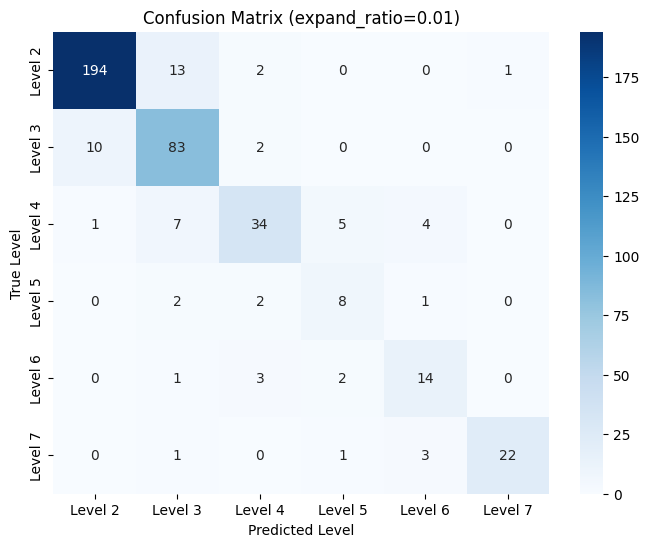


Classification Report:
              precision    recall  f1-score   support

     Level 2     0.9463    0.9238    0.9349       210
     Level 3     0.7757    0.8737    0.8218        95
     Level 4     0.7907    0.6667    0.7234        51
     Level 5     0.5000    0.6154    0.5517        13
     Level 6     0.6364    0.7000    0.6667        20
     Level 7     0.9565    0.8148    0.8800        27

    accuracy                         0.8534       416
   macro avg     0.7676    0.7657    0.7631       416
weighted avg     0.8601    0.8534    0.8547       416



Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...orch-hair-segmentation/resnet18.pth:   1%|1         |  567kB / 44.8MB            


✅ Model uploaded to: https://huggingface.co/alamb98/resnet18


In [ ]:
################################################################################
# Colab‐Cell: Train a Norwood‐Stage Classifier on “Cropped‐Interior” Images
# using EfficientNet-B0 with a single expand_ratio (e.g., 0.01), reading from
# combined “orig + CLAHE” folders for raw + segmented images.
#
# Now we assume:
#   • Combined segmented masks live under:
#       /content/combined_segmented_boundary/<split>/Level X/
#         ├── img001_boundary_orig.png
#         ├── img001_boundary_clahe.png
#         ├── img002_boundary_orig.png
#         ├── img002_boundary_clahe.png
#         └── …
#   • Combined raw images live under:
#       /content/combined_norwood_raw/<split>/Level X/
#         ├── img001_orig.jpg
#         ├── img001_clahe.jpg
#         ├── img002_orig.jpg
#         ├── img002_clahe.jpg
#         └── …
#
# The Dataset logic will:
#   - For each “*_boundary_*.png” in combined_segmented_boundary, extract the
#     prefix (e.g. “img001”) and the suffix (e.g. “_orig” or “_clahe”).
#   - Look up the matching raw image as prefix + suffix + “.jpg” in
#     combined_norwood_raw.
#   - Crop the raw image using the boundary mask after expanding by expand_ratio.
#
# Everything else—training loop, transforms, evaluation—remains unchanged.
#
# To change expand_ratio, just edit EXPAND_RATIO below.
#
# BEFORE RUNNING:
#   • Confirm the combined directories exist as described above.
#   • Use a GPU runtime: Runtime → Change runtime type → GPU.
################################################################################

# (0) Install & import dependencies
!pip install --quiet torch torchvision tqdm scikit-learn pandas seaborn matplotlib opencv-python efficientnet_pytorch

import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from tqdm import tqdm
from collections import Counter
import json

# EfficientNet-B0
from efficientnet_pytorch import EfficientNet

# sklearn metrics
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

################################################################################
# (1) Custom Dataset: Use combined folders (orig + CLAHE). The “suffix” is either
# "_orig" or "_clahe" depending on the filename.
################################################################################

class NorwoodCroppedExpandedDataset(Dataset):
    def __init__(self,
                 raw_root: str,
                 boundary_root: str,
                 split: str,
                 level_names: list,
                 transform=None,
                 expand_ratio: float = 0.01):
        """
        raw_root:      "/content/combined_norwood_raw"
        boundary_root: "/content/combined_segmented_boundary"
        split:         one of "train", "valid", "test"
        level_names:   ["Level 2", "Level 3", ..., "Level 7"]
        transform:     torchvision transforms applied to each cropped image
        expand_ratio:  fraction of max(w, h) added around the hair bounding box
        """
        self.samples = []  # list of (raw_img_path, boundary_img_path, label_index)
        self.transform = transform
        self.expand_ratio = expand_ratio

        for idx, lvl in enumerate(level_names):
            raw_dir = os.path.join(raw_root, split, lvl)
            bnd_dir = os.path.join(boundary_root, split, lvl)

            if not os.path.isdir(raw_dir):
                raise FileNotFoundError(f"Raw folder not found: {raw_dir}")
            if not os.path.isdir(bnd_dir):
                raise FileNotFoundError(f"Boundary folder not found: {bnd_dir}")

            for fname in os.listdir(bnd_dir):
                # We expect boundary filenames like "img001_boundary_orig.png" or "img001_boundary_clahe.png"
                if "_boundary" not in fname.lower() or not fname.lower().endswith(".png"):
                    continue

                # Extract prefix and suffix from boundary filename
                name, ext = os.path.splitext(fname)  # e.g. name = "img001_boundary_orig"
                if "_boundary" not in name:
                    continue

                prefix, suffix = name.split("_boundary", 1)
                # suffix is either "_orig" or "_clahe"
                raw_fname = prefix + suffix + ".jpg"
                raw_path = os.path.join(raw_dir, raw_fname)
                bnd_path = os.path.join(bnd_dir, fname)

                if not os.path.isfile(raw_path):
                    raise FileNotFoundError(f"Raw image missing for boundary: {raw_path}")
                self.samples.append((raw_path, bnd_path, idx))

        if len(self.samples) == 0:
            raise ValueError(f"No samples found for split={split}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        raw_path, bnd_path, label = self.samples[index]

        # Load raw and boundary as RGB NumPy arrays
        raw_img = np.array(Image.open(raw_path).convert("RGB"))
        bnd_img = np.array(Image.open(bnd_path).convert("RGB"))
        H, W, _ = raw_img.shape

        # Create binary mask of red boundary via HSV threshold
        hsv = cv2.cvtColor(bnd_img, cv2.COLOR_RGB2HSV)
        lower1 = np.array([0, 100, 100]); upper1 = np.array([10, 255, 255])
        lower2 = np.array([160, 100, 100]); upper2 = np.array([180, 255, 255])
        mask1 = cv2.inRange(hsv, lower1, upper1)
        mask2 = cv2.inRange(hsv, lower2, upper2)
        red_boundary_mask = cv2.bitwise_or(mask1, mask2)

        # Find external contours on the red mask
        contours, _ = cv2.findContours(
            red_boundary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )

        if len(contours) == 0:
            # If no contour found, use full image
            x, y, w, h = 0, 0, W, H
        else:
            # Merge all contour points to compute a tight bounding box
            all_pts = np.vstack(contours).squeeze()
            xs, ys = all_pts[:, 0], all_pts[:, 1]
            x_min, x_max = xs.min(), xs.max()
            y_min, y_max = ys.min(), ys.max()
            x, y, w, h = int(x_min), int(y_min), int(x_max - x_min), int(y_max - y_min)

        # Expand bounding box by expand_ratio * max(w, h)
        margin = int(self.expand_ratio * max(w, h))
        x1 = max(0, x - margin)
        y1 = max(0, y - margin)
        x2 = min(W, x + w + margin)
        y2 = min(H, y + h + margin)

        # Crop raw image
        cropped = raw_img[y1:y2, x1:x2]
        if cropped.size == 0:
            cropped = raw_img.copy()

        # Convert to PIL and apply transforms
        cropped_pil = Image.fromarray(cropped)
        if self.transform:
            cropped_pil = self.transform(cropped_pil)

        return cropped_pil, label

################################################################################
# (2) Paths, Classes, and Transforms
################################################################################

# ────────────────────────────────────────────────────────────────────────────────
# Change these two roots to point at your combined folders:
# ────────────────────────────────────────────────────────────────────────────────

RAW_ROOT      = "/content/norwood_dataset_combined"
BOUNDARY_ROOT = "/content/segmented_boundary_clahe"

# We still expect the same “train/Level 2, train/Level 3… valid/… test/…” structure
SPLITS        = ["train", "valid", "test"]
LEVEL_NAMES   = [f"Level {i}" for i in range(2, 8)]  # ["Level 2", "Level 3", ..., "Level 7"]

# Verify folder structure once
for split in SPLITS:
    for lvl in LEVEL_NAMES:
        raw_dir = os.path.join(RAW_ROOT,  split, lvl)
        bnd_dir = os.path.join(BOUNDARY_ROOT, split, lvl)
        if not os.path.isdir(raw_dir):
            raise FileNotFoundError(f"Missing raw folder: {raw_dir}")
        if not os.path.isdir(bnd_dir):
            raise FileNotFoundError(f"Missing boundary folder: {bnd_dir}")
print("Verified combined raw + combined segmented folder structure.")

# Transforms: resize to 224×224, augment on train
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])
eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])



with open("/content/labels.json", "w") as f:
    json.dump(LEVEL_NAMES, f)

deploy_cfg = {
    "image_size": [224, 224],
    "normalize_mean": [0.485, 0.456, 0.406],
    "normalize_std": [0.229, 0.224, 0.225],
    "model_name": MODEL_NAME
}
with open("/content/preprocess.json", "w") as f:
    json.dump(deploy_cfg, f)

################################################################################
# (3) Set expand_ratio and instantiate Datasets & DataLoaders (no loop)
################################################################################

# Change this value to experiment with a different expand_ratio:
EXPAND_RATIO = 0.01  # 1% of max(w, h)

print(f"\n▶ Running with expand_ratio = {EXPAND_RATIO:.2f}")

train_dataset = NorwoodCroppedExpandedDataset(
    raw_root=RAW_ROOT,
    boundary_root=BOUNDARY_ROOT,
    split="train",
    level_names=LEVEL_NAMES,
    transform=train_transform,
    expand_ratio=EXPAND_RATIO
)
valid_dataset = NorwoodCroppedExpandedDataset(
    raw_root=RAW_ROOT,
    boundary_root=BOUNDARY_ROOT,
    split="valid",
    level_names=LEVEL_NAMES,
    transform=eval_transform,
    expand_ratio=EXPAND_RATIO
)
test_dataset = NorwoodCroppedExpandedDataset(
    raw_root=RAW_ROOT,
    boundary_root=BOUNDARY_ROOT,
    split="test",
    level_names=LEVEL_NAMES,
    transform=eval_transform,
    expand_ratio=EXPAND_RATIO
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,
                          num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False,
                          num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False,
                          num_workers=2, pin_memory=True)

print(f"Train samples: {len(train_dataset)}")
print(f"Valid samples: {len(valid_dataset)}")
print(f"Test samples:  {len(test_dataset)}")

################################################################################
# (4) Build your classifier & move to GPU
################################################################################

import torchvision.models as models

MODEL_NAME = "resnet18"   # ← change this to mobilenet_v2, resnet18, vgg16, or custom_cnn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if MODEL_NAME == "efficientnet-b0":
    from efficientnet_pytorch import EfficientNet
    model = EfficientNet.from_pretrained("efficientnet-b0")
    in_features = model._fc.in_features
    model._fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "mobilenet_v2":
    model = models.mobilenet_v2(pretrained=True)
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "resnet18":
    model = models.resnet18(pretrained=True)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "vgg16":
    model = models.vgg16(pretrained=True)
    in_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "custom_cnn":
    # Define your CustomCNN somewhere above:
    # class CustomCNN(nn.Module):
    #     def __init__(self, num_classes): …
    #     def forward(self, x): …
    model = CustomCNN(num_classes=len(LEVEL_NAMES))

else:
    raise ValueError(f"Unknown MODEL_NAME: {MODEL_NAME}")

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)


################################################################################
# (5) Training & validation loop (10 epochs)
################################################################################

num_epochs      = 10
best_valid_acc  = 0.0
best_checkpoint = "/content/best_efficientnetb0_single_ratio.pth"

for epoch in range(1, num_epochs + 1):
    # --- Training Phase ---
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_train = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} [Train]"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels).item()
        total_train += inputs.size(0)

    epoch_acc = running_corrects / total_train
    print(f"    [Epoch {epoch}] Train Acc: {epoch_acc:.4f}")

    # --- Validation Phase ---
    model.eval()
    val_corrects = 0
    total_valid = 0

    with torch.no_grad():
        for inputs, labels in tqdm(valid_loader, desc=f"Epoch {epoch}/{num_epochs} [Valid]"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels).item()
            total_valid += inputs.size(0)

    val_acc = val_corrects / total_valid
    print(f"    [Epoch {epoch}] Valid Acc: {val_acc:.4f}")

    # Save checkpoint if validation improves
    if val_acc > best_valid_acc:
        best_valid_acc = val_acc
        torch.save(model.state_dict(), best_checkpoint)
        print(f"      → New best valid acc: {best_valid_acc:.4f}. Saved to {best_checkpoint}")

################################################################################
# (6) Load best checkpoint and evaluate on test set
################################################################################

model.load_state_dict(torch.load(best_checkpoint))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

test_f1_macro = f1_score(all_labels, all_preds, average="macro")
test_acc = (np.array(all_preds) == np.array(all_labels)).mean()

print(f"\n▶ Final Test Accuracy: {test_acc*100:.2f}%  ({len(all_labels)} samples)")
print(f"▶ Final Test Macro F1: {test_f1_macro:.4f}")

# (Optional) Print confusion matrix and classification report
cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(LEVEL_NAMES))))
cm_df = pd.DataFrame(cm, index=LEVEL_NAMES, columns=LEVEL_NAMES)
print("\nConfusion Matrix:")
print(cm_df)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.ylabel("True Level")
plt.xlabel("Predicted Level")
plt.title(f"Confusion Matrix (expand_ratio={EXPAND_RATIO:.2f})")
plt.show()

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=LEVEL_NAMES, digits=4))


################################################################################
# (7) Upload best model weights + metadata to Hugging Face Hub
################################################################################

!pip install -q huggingface_hub

from huggingface_hub import login, create_repo, upload_folder

# 🔐 Log in with your Hugging Face token (only once per session)
login()

# Set your repo ID — change this to your actual username/repo name
hf_username = "alamb98"  # ← change this
model_name = MODEL_NAME  # or mobilenetv3..., effnetb0...
repo_id = f"{hf_username}/{model_name}"

# Create a new model repo or skip if it exists
create_repo(repo_id, repo_type="model", exist_ok=True)

# Save model weights
torch.save(model.state_dict(), f"{model_name}.pth")

# Save metadata
metadata = {
    "model_name": model_name,
    "image_size": [224, 224],
    "expand_ratio": EXPAND_RATIO,
    "labels": LEVEL_NAMES,
    "test_accuracy": round(test_acc, 4),
    "macro_f1_score": round(test_f1_macro, 4)
}
with open("metadata.json", "w") as f:
    json.dump(metadata, f)

# Upload both files to Hugging Face
upload_folder(folder_path=".", repo_id=repo_id, repo_type="model", allow_patterns=[
    f"{model_name}.pth",
    "metadata.json"
])

print(f"\n✅ Model uploaded to: https://huggingface.co/{repo_id}")



RUN IT

In [ ]:
# ───────────────────────────────────────────────────────────────────────────────
# 0. Install requirements
# ───────────────────────────────────────────────────────────────────────────────
!pip install --quiet torch torchvision tqdm scikit-learn pandas seaborn matplotlib opencv-python efficientnet_pytorch huggingface_hub

# ───────────────────────────────────────────────────────────────────────────────
# 1. Imports
# ───────────────────────────────────────────────────────────────────────────────
import os, json, cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score, classification_report
from tqdm import tqdm
import matplotlib.pyplot as plt
from efficientnet_pytorch import EfficientNet
from huggingface_hub import login, create_repo, upload_folder

# ───────────────────────────────────────────────────────────────────────────────
# 2. Setup
# ───────────────────────────────────────────────────────────────────────────────
MODEL_NAME = "resnet18"
EXPAND_RATIO = 0.01
hf_username = "alamb98"  # <- change if needed

RAW_ROOT = "/content/norwood_dataset_combined"
BOUNDARY_ROOT = "/content/segmented_boundary_clahe"
SPLITS = ["train", "valid", "test"]
LEVEL_NAMES = [f"Level {i}" for i in range(2, 8)]

# ───────────────────────────────────────────────────────────────────────────────
# 3. Dataset
# ───────────────────────────────────────────────────────────────────────────────
class NorwoodCroppedExpandedDataset(Dataset):
    def __init__(self, raw_root, boundary_root, split, level_names, transform=None, expand_ratio=0.01):
        self.samples = []
        self.transform = transform
        self.expand_ratio = expand_ratio

        for idx, lvl in enumerate(level_names):
            raw_dir = os.path.join(raw_root, split, lvl)
            bnd_dir = os.path.join(boundary_root, split, lvl)
            for fname in os.listdir(bnd_dir):
                if "_boundary" not in fname.lower() or not fname.lower().endswith(".png"):
                    continue
                name, ext = os.path.splitext(fname)
                prefix, suffix = name.split("_boundary", 1)
                raw_fname = prefix + suffix + ".jpg"
                raw_path = os.path.join(raw_dir, raw_fname)
                bnd_path = os.path.join(bnd_dir, fname)
                if os.path.isfile(raw_path):
                    self.samples.append((raw_path, bnd_path, idx))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        raw_path, bnd_path, label = self.samples[index]
        raw_img = np.array(Image.open(raw_path).convert("RGB"))
        bnd_img = np.array(Image.open(bnd_path).convert("RGB"))
        H, W, _ = raw_img.shape
        hsv = cv2.cvtColor(bnd_img, cv2.COLOR_RGB2HSV)
        mask1 = cv2.inRange(hsv, (0, 100, 100), (10, 255, 255))
        mask2 = cv2.inRange(hsv, (160, 100, 100), (180, 255, 255))
        red_mask = cv2.bitwise_or(mask1, mask2)
        contours, _ = cv2.findContours(red_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if len(contours) == 0:
            x, y, w, h = 0, 0, W, H
        else:
            all_pts = np.vstack(contours).squeeze()
            x, y, w, h = np.min(all_pts[:, 0]), np.min(all_pts[:, 1]), np.ptp(all_pts[:, 0]), np.ptp(all_pts[:, 1])

        margin = int(self.expand_ratio * max(w, h))
        x1 = max(0, x - margin)
        y1 = max(0, y - margin)
        x2 = min(W, x + w + margin)
        y2 = min(H, y + h + margin)
        cropped = raw_img[y1:y2, x1:x2] if raw_img[y1:y2, x1:x2].size else raw_img.copy()

        img_pil = Image.fromarray(cropped)
        if self.transform:
            img_pil = self.transform(img_pil)
        return img_pil, label

# ───────────────────────────────────────────────────────────────────────────────
# 4. Transforms & DataLoaders
# ───────────────────────────────────────────────────────────────────────────────
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.1, 0.1, 0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_set = NorwoodCroppedExpandedDataset(RAW_ROOT, BOUNDARY_ROOT, "train", LEVEL_NAMES, train_transform, EXPAND_RATIO)
valid_set = NorwoodCroppedExpandedDataset(RAW_ROOT, BOUNDARY_ROOT, "valid", LEVEL_NAMES, eval_transform, EXPAND_RATIO)
test_set  = NorwoodCroppedExpandedDataset(RAW_ROOT, BOUNDARY_ROOT, "test",  LEVEL_NAMES, eval_transform, EXPAND_RATIO)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=32)
test_loader  = DataLoader(test_set,  batch_size=32)

# ───────────────────────────────────────────────────────────────────────────────
# 5. Model Training
# ───────────────────────────────────────────────────────────────────────────────
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(LEVEL_NAMES))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(10):  # keep small for demo
    model.train()
    total_loss = 0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

# ───────────────────────────────────────────────────────────────────────────────
# 6. Evaluation on Test Set
# ───────────────────────────────────────────────────────────────────────────────
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

test_acc = (np.array(all_preds) == np.array(all_labels)).mean()
test_f1_macro = f1_score(all_labels, all_preds, average="macro")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=LEVEL_NAMES))
print(f"✅ Test Accuracy: {test_acc:.4f}, Macro F1: {test_f1_macro:.4f}")

# ───────────────────────────────────────────────────────────────────────────────
# 7. Upload to Hugging Face
# ───────────────────────────────────────────────────────────────────────────────

from huggingface_hub import login, create_repo, upload_folder

# Login to Hugging Face (only once per session)
login()  # You’ll be asked to paste your HF token

# Define repo ID
repo_id = f"{hf_username}/{MODEL_NAME}"

# Create repo if it doesn't exist
create_repo(repo_id, repo_type="model", exist_ok=True)

# Save model weights
torch.save(model.state_dict(), f"{MODEL_NAME}.pth")

# Save metadata
metadata = {
    "model_name": MODEL_NAME,
    "expand_ratio": EXPAND_RATIO,
    "image_size": [224, 224],
    "labels": LEVEL_NAMES,
    "test_accuracy": round(test_acc, 4),
    "macro_f1_score": round(test_f1_macro, 4)
}
with open("metadata.json", "w") as f:
    json.dump(metadata, f)

# Upload model and metadata
upload_folder(
    folder_path=".",
    repo_id=repo_id,
    repo_type="model",
    allow_patterns=[f"{MODEL_NAME}.pth", "metadata.json"]
)

print(f"\n✅ Model uploaded to: https://huggingface.co/{repo_id}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 84%|████████▍ | 238/284 [01:48<00:21,  2.19it/s]


KeyboardInterrupt: 

mobilenet_v2

  Preparing metadata (setup.py) ... done
Verified combined raw + combined segmented folder structure.

▶ Running with expand_ratio = 0.01


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


Train samples: 9069
Valid samples: 895
Test samples:  416


100%|██████████| 13.6M/13.6M [00:00<00:00, 108MB/s]
Epoch 1/10 [Train]: 100%|██████████| 284/284 [02:08<00:00,  2.20it/s]


    [Epoch 1] Train Acc: 0.6788


Epoch 1/10 [Valid]: 100%|██████████| 28/28 [00:10<00:00,  2.71it/s]


    [Epoch 1] Valid Acc: 0.7441
      → New best valid acc: 0.7441. Saved to /content/best_efficientnetb0_single_ratio.pth


Epoch 2/10 [Train]: 100%|██████████| 284/284 [02:02<00:00,  2.31it/s]


    [Epoch 2] Train Acc: 0.8220


Epoch 2/10 [Valid]: 100%|██████████| 28/28 [00:09<00:00,  3.01it/s]


    [Epoch 2] Valid Acc: 0.8067
      → New best valid acc: 0.8067. Saved to /content/best_efficientnetb0_single_ratio.pth


Epoch 3/10 [Train]: 100%|██████████| 284/284 [02:13<00:00,  2.12it/s]


    [Epoch 3] Train Acc: 0.8906


Epoch 3/10 [Valid]: 100%|██████████| 28/28 [00:11<00:00,  2.43it/s]


    [Epoch 3] Valid Acc: 0.8235
      → New best valid acc: 0.8235. Saved to /content/best_efficientnetb0_single_ratio.pth


Epoch 4/10 [Train]: 100%|██████████| 284/284 [03:00<00:00,  1.57it/s]


    [Epoch 4] Train Acc: 0.9251


Epoch 4/10 [Valid]: 100%|██████████| 28/28 [00:14<00:00,  1.90it/s]


    [Epoch 4] Valid Acc: 0.8369
      → New best valid acc: 0.8369. Saved to /content/best_efficientnetb0_single_ratio.pth


Epoch 5/10 [Train]: 100%|██████████| 284/284 [02:16<00:00,  2.08it/s]


    [Epoch 5] Train Acc: 0.9420


Epoch 5/10 [Valid]: 100%|██████████| 28/28 [00:10<00:00,  2.75it/s]


    [Epoch 5] Valid Acc: 0.8246


Epoch 6/10 [Train]: 100%|██████████| 284/284 [02:03<00:00,  2.31it/s]


    [Epoch 6] Train Acc: 0.9611


Epoch 6/10 [Valid]: 100%|██████████| 28/28 [00:09<00:00,  2.84it/s]


    [Epoch 6] Valid Acc: 0.8324


Epoch 7/10 [Train]: 100%|██████████| 284/284 [02:06<00:00,  2.24it/s]


    [Epoch 7] Train Acc: 0.9670


Epoch 7/10 [Valid]: 100%|██████████| 28/28 [00:14<00:00,  1.95it/s]


    [Epoch 7] Valid Acc: 0.8291


Epoch 8/10 [Train]: 100%|██████████| 284/284 [02:59<00:00,  1.58it/s]


    [Epoch 8] Train Acc: 0.9685


Epoch 8/10 [Valid]: 100%|██████████| 28/28 [00:14<00:00,  1.90it/s]


    [Epoch 8] Valid Acc: 0.8391
      → New best valid acc: 0.8391. Saved to /content/best_efficientnetb0_single_ratio.pth


Epoch 9/10 [Train]: 100%|██████████| 284/284 [02:04<00:00,  2.27it/s]


    [Epoch 9] Train Acc: 0.9728


Epoch 9/10 [Valid]: 100%|██████████| 28/28 [00:10<00:00,  2.75it/s]


    [Epoch 9] Valid Acc: 0.8335


Epoch 10/10 [Train]: 100%|██████████| 284/284 [02:03<00:00,  2.29it/s]


    [Epoch 10] Train Acc: 0.9723


Epoch 10/10 [Valid]: 100%|██████████| 28/28 [00:10<00:00,  2.75it/s]


    [Epoch 10] Valid Acc: 0.8369


Testing: 100%|██████████| 13/13 [00:04<00:00,  2.82it/s]



▶ Final Test Accuracy: 82.21%  (416 samples)
▶ Final Test Macro F1: 0.7163

Confusion Matrix:
         Level 2  Level 3  Level 4  Level 5  Level 6  Level 7
Level 2      188       20        2        0        0        0
Level 3       11       78        5        1        0        0
Level 4        3        6       33        5        3        1
Level 5        1        0        4        4        2        2
Level 6        1        1        0        0       17        1
Level 7        1        0        0        0        4       22


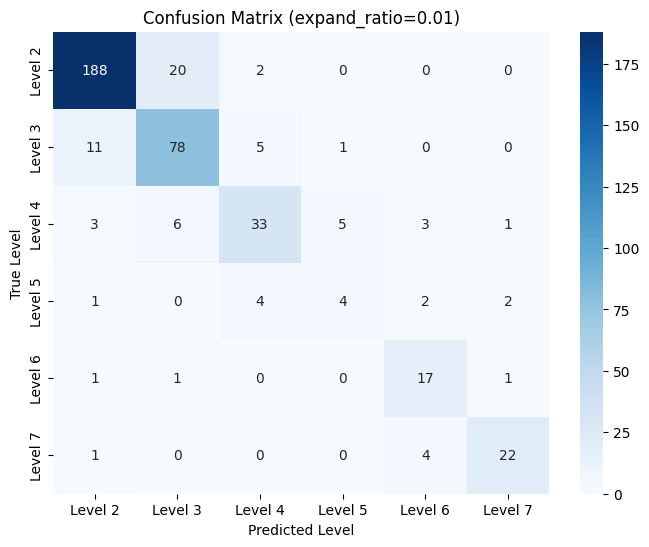


Classification Report:
              precision    recall  f1-score   support

     Level 2     0.9171    0.8952    0.9060       210
     Level 3     0.7429    0.8211    0.7800        95
     Level 4     0.7500    0.6471    0.6947        51
     Level 5     0.4000    0.3077    0.3478        13
     Level 6     0.6538    0.8500    0.7391        20
     Level 7     0.8462    0.8148    0.8302        27

    accuracy                         0.8221       416
   macro avg     0.7183    0.7226    0.7163       416
weighted avg     0.8234    0.8221    0.8210       416



In [ ]:
################################################################################
# Colab‐Cell: Train a Norwood‐Stage Classifier on “Cropped‐Interior” Images
# using EfficientNet-B0 with a single expand_ratio (e.g., 0.01), reading from
# combined “orig + CLAHE” folders for raw + segmented images.
#
# Now we assume:
#   • Combined segmented masks live under:
#       /content/combined_segmented_boundary/<split>/Level X/
#         ├── img001_boundary_orig.png
#         ├── img001_boundary_clahe.png
#         ├── img002_boundary_orig.png
#         ├── img002_boundary_clahe.png
#         └── …
#   • Combined raw images live under:
#       /content/combined_norwood_raw/<split>/Level X/
#         ├── img001_orig.jpg
#         ├── img001_clahe.jpg
#         ├── img002_orig.jpg
#         ├── img002_clahe.jpg
#         └── …
#
# The Dataset logic will:
#   - For each “*_boundary_*.png” in combined_segmented_boundary, extract the
#     prefix (e.g. “img001”) and the suffix (e.g. “_orig” or “_clahe”).
#   - Look up the matching raw image as prefix + suffix + “.jpg” in
#     combined_norwood_raw.
#   - Crop the raw image using the boundary mask after expanding by expand_ratio.
#
# Everything else—training loop, transforms, evaluation—remains unchanged.
#
# To change expand_ratio, just edit EXPAND_RATIO below.
#
# BEFORE RUNNING:
#   • Confirm the combined directories exist as described above.
#   • Use a GPU runtime: Runtime → Change runtime type → GPU.
################################################################################

# (0) Install & import dependencies
!pip install --quiet torch torchvision tqdm scikit-learn pandas seaborn matplotlib opencv-python efficientnet_pytorch

import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from tqdm import tqdm
from collections import Counter
import json

# EfficientNet-B0
from efficientnet_pytorch import EfficientNet

# sklearn metrics
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

################################################################################
# (1) Custom Dataset: Use combined folders (orig + CLAHE). The “suffix” is either
# "_orig" or "_clahe" depending on the filename.
################################################################################

class NorwoodCroppedExpandedDataset(Dataset):
    def __init__(self,
                 raw_root: str,
                 boundary_root: str,
                 split: str,
                 level_names: list,
                 transform=None,
                 expand_ratio: float = 0.01):
        """
        raw_root:      "/content/combined_norwood_raw"
        boundary_root: "/content/combined_segmented_boundary"
        split:         one of "train", "valid", "test"
        level_names:   ["Level 2", "Level 3", ..., "Level 7"]
        transform:     torchvision transforms applied to each cropped image
        expand_ratio:  fraction of max(w, h) added around the hair bounding box
        """
        self.samples = []  # list of (raw_img_path, boundary_img_path, label_index)
        self.transform = transform
        self.expand_ratio = expand_ratio

        for idx, lvl in enumerate(level_names):
            raw_dir = os.path.join(raw_root, split, lvl)
            bnd_dir = os.path.join(boundary_root, split, lvl)

            if not os.path.isdir(raw_dir):
                raise FileNotFoundError(f"Raw folder not found: {raw_dir}")
            if not os.path.isdir(bnd_dir):
                raise FileNotFoundError(f"Boundary folder not found: {bnd_dir}")

            for fname in os.listdir(bnd_dir):
                # We expect boundary filenames like "img001_boundary_orig.png" or "img001_boundary_clahe.png"
                if "_boundary" not in fname.lower() or not fname.lower().endswith(".png"):
                    continue

                # Extract prefix and suffix from boundary filename
                name, ext = os.path.splitext(fname)  # e.g. name = "img001_boundary_orig"
                if "_boundary" not in name:
                    continue

                prefix, suffix = name.split("_boundary", 1)
                # suffix is either "_orig" or "_clahe"
                raw_fname = prefix + suffix + ".jpg"
                raw_path = os.path.join(raw_dir, raw_fname)
                bnd_path = os.path.join(bnd_dir, fname)

                if not os.path.isfile(raw_path):
                    raise FileNotFoundError(f"Raw image missing for boundary: {raw_path}")
                self.samples.append((raw_path, bnd_path, idx))

        if len(self.samples) == 0:
            raise ValueError(f"No samples found for split={split}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        raw_path, bnd_path, label = self.samples[index]

        # Load raw and boundary as RGB NumPy arrays
        raw_img = np.array(Image.open(raw_path).convert("RGB"))
        bnd_img = np.array(Image.open(bnd_path).convert("RGB"))
        H, W, _ = raw_img.shape

        # Create binary mask of red boundary via HSV threshold
        hsv = cv2.cvtColor(bnd_img, cv2.COLOR_RGB2HSV)
        lower1 = np.array([0, 100, 100]); upper1 = np.array([10, 255, 255])
        lower2 = np.array([160, 100, 100]); upper2 = np.array([180, 255, 255])
        mask1 = cv2.inRange(hsv, lower1, upper1)
        mask2 = cv2.inRange(hsv, lower2, upper2)
        red_boundary_mask = cv2.bitwise_or(mask1, mask2)

        # Find external contours on the red mask
        contours, _ = cv2.findContours(
            red_boundary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )

        if len(contours) == 0:
            # If no contour found, use full image
            x, y, w, h = 0, 0, W, H
        else:
            # Merge all contour points to compute a tight bounding box
            all_pts = np.vstack(contours).squeeze()
            xs, ys = all_pts[:, 0], all_pts[:, 1]
            x_min, x_max = xs.min(), xs.max()
            y_min, y_max = ys.min(), ys.max()
            x, y, w, h = int(x_min), int(y_min), int(x_max - x_min), int(y_max - y_min)

        # Expand bounding box by expand_ratio * max(w, h)
        margin = int(self.expand_ratio * max(w, h))
        x1 = max(0, x - margin)
        y1 = max(0, y - margin)
        x2 = min(W, x + w + margin)
        y2 = min(H, y + h + margin)

        # Crop raw image
        cropped = raw_img[y1:y2, x1:x2]
        if cropped.size == 0:
            cropped = raw_img.copy()

        # Convert to PIL and apply transforms
        cropped_pil = Image.fromarray(cropped)
        if self.transform:
            cropped_pil = self.transform(cropped_pil)

        return cropped_pil, label

################################################################################
# (2) Paths, Classes, and Transforms
################################################################################

# ────────────────────────────────────────────────────────────────────────────────
# Change these two roots to point at your combined folders:
# ────────────────────────────────────────────────────────────────────────────────

RAW_ROOT      = "/content/norwood_dataset_combined"
BOUNDARY_ROOT = "/content/segmented_boundary_clahe"

# We still expect the same “train/Level 2, train/Level 3… valid/… test/…” structure
SPLITS        = ["train", "valid", "test"]
LEVEL_NAMES   = [f"Level {i}" for i in range(2, 8)]  # ["Level 2", "Level 3", ..., "Level 7"]

# Verify folder structure once
for split in SPLITS:
    for lvl in LEVEL_NAMES:
        raw_dir = os.path.join(RAW_ROOT,  split, lvl)
        bnd_dir = os.path.join(BOUNDARY_ROOT, split, lvl)
        if not os.path.isdir(raw_dir):
            raise FileNotFoundError(f"Missing raw folder: {raw_dir}")
        if not os.path.isdir(bnd_dir):
            raise FileNotFoundError(f"Missing boundary folder: {bnd_dir}")
print("Verified combined raw + combined segmented folder structure.")

# Transforms: resize to 224×224, augment on train
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])
eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])



with open("/content/labels.json", "w") as f:
    json.dump(LEVEL_NAMES, f)

deploy_cfg = {
    "image_size": [224, 224],
    "normalize_mean": [0.485, 0.456, 0.406],
    "normalize_std": [0.229, 0.224, 0.225],
    "model_name": MODEL_NAME
}
with open("/content/preprocess.json", "w") as f:
    json.dump(deploy_cfg, f)


################################################################################
# (3) Set expand_ratio and instantiate Datasets & DataLoaders (no loop)
################################################################################

# Change this value to experiment with a different expand_ratio:
EXPAND_RATIO = 0.01  # 1% of max(w, h)

print(f"\n▶ Running with expand_ratio = {EXPAND_RATIO:.2f}")

train_dataset = NorwoodCroppedExpandedDataset(
    raw_root=RAW_ROOT,
    boundary_root=BOUNDARY_ROOT,
    split="train",
    level_names=LEVEL_NAMES,
    transform=train_transform,
    expand_ratio=EXPAND_RATIO
)
valid_dataset = NorwoodCroppedExpandedDataset(
    raw_root=RAW_ROOT,
    boundary_root=BOUNDARY_ROOT,
    split="valid",
    level_names=LEVEL_NAMES,
    transform=eval_transform,
    expand_ratio=EXPAND_RATIO
)
test_dataset = NorwoodCroppedExpandedDataset(
    raw_root=RAW_ROOT,
    boundary_root=BOUNDARY_ROOT,
    split="test",
    level_names=LEVEL_NAMES,
    transform=eval_transform,
    expand_ratio=EXPAND_RATIO
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,
                          num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False,
                          num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False,
                          num_workers=2, pin_memory=True)

print(f"Train samples: {len(train_dataset)}")
print(f"Valid samples: {len(valid_dataset)}")
print(f"Test samples:  {len(test_dataset)}")

################################################################################
# (4) Build your classifier & move to GPU
################################################################################

import torchvision.models as models

MODEL_NAME = "mobilenet_v2"   # ← change this to mobilenet_v2, resnet18, vgg16, or custom_cnn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if MODEL_NAME == "efficientnet-b0":
    from efficientnet_pytorch import EfficientNet
    model = EfficientNet.from_pretrained("efficientnet-b0")
    in_features = model._fc.in_features
    model._fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "mobilenet_v2":
    model = models.mobilenet_v2(pretrained=True)
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "resnet18":
    model = models.resnet18(pretrained=True)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "vgg16":
    model = models.vgg16(pretrained=True)
    in_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "custom_cnn":
    # Define your CustomCNN somewhere above:
    # class CustomCNN(nn.Module):
    #     def __init__(self, num_classes): …
    #     def forward(self, x): …
    model = CustomCNN(num_classes=len(LEVEL_NAMES))

else:
    raise ValueError(f"Unknown MODEL_NAME: {MODEL_NAME}")

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)


################################################################################
# (5) Training & validation loop (10 epochs)
################################################################################
## best_checkpoint = "/content/best_efficientnetb0_single_ratio.pth"
num_epochs      = 10
best_valid_acc  = 0.0
best_checkpoint = "/content/best_mobilenet_v2_expand001.pth"


for epoch in range(1, num_epochs + 1):
    # --- Training Phase ---
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_train = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} [Train]"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels).item()
        total_train += inputs.size(0)

    epoch_acc = running_corrects / total_train
    print(f"    [Epoch {epoch}] Train Acc: {epoch_acc:.4f}")

    # --- Validation Phase ---
    model.eval()
    val_corrects = 0
    total_valid = 0

    with torch.no_grad():
        for inputs, labels in tqdm(valid_loader, desc=f"Epoch {epoch}/{num_epochs} [Valid]"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels).item()
            total_valid += inputs.size(0)

    val_acc = val_corrects / total_valid
    print(f"    [Epoch {epoch}] Valid Acc: {val_acc:.4f}")

    # Save checkpoint if validation improves
    if val_acc > best_valid_acc:
        best_valid_acc = val_acc
        torch.save(model.state_dict(), best_checkpoint)
        print(f"      → New best valid acc: {best_valid_acc:.4f}. Saved to {best_checkpoint}")


################################################################################
# (6) Load best checkpoint and evaluate on test set
################################################################################

model.load_state_dict(torch.load(best_checkpoint))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

test_f1_macro = f1_score(all_labels, all_preds, average="macro")
test_acc = (np.array(all_preds) == np.array(all_labels)).mean()

print(f"\n▶ Final Test Accuracy: {test_acc*100:.2f}%  ({len(all_labels)} samples)")
print(f"▶ Final Test Macro F1: {test_f1_macro:.4f}")

# (Optional) Print confusion matrix and classification report
cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(LEVEL_NAMES))))
cm_df = pd.DataFrame(cm, index=LEVEL_NAMES, columns=LEVEL_NAMES)
print("\nConfusion Matrix:")
print(cm_df)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.ylabel("True Level")
plt.xlabel("Predicted Level")
plt.title(f"Confusion Matrix (expand_ratio={EXPAND_RATIO:.2f})")
plt.show()

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=LEVEL_NAMES, digits=4))

################################################################################
# End of script
################################################################################


vgg16

In [ ]:
################################################################################
# Colab‐Cell: Train a Norwood‐Stage Classifier on “Cropped‐Interior” Images
# using EfficientNet-B0 with a single expand_ratio (e.g., 0.01), reading from
# combined “orig + CLAHE” folders for raw + segmented images.
#
# Now we assume:
#   • Combined segmented masks live under:
#       /content/combined_segmented_boundary/<split>/Level X/
#         ├── img001_boundary_orig.png
#         ├── img001_boundary_clahe.png
#         ├── img002_boundary_orig.png
#         ├── img002_boundary_clahe.png
#         └── …
#   • Combined raw images live under:
#       /content/combined_norwood_raw/<split>/Level X/
#         ├── img001_orig.jpg
#         ├── img001_clahe.jpg
#         ├── img002_orig.jpg
#         ├── img002_clahe.jpg
#         └── …
#
# The Dataset logic will:
#   - For each “*_boundary_*.png” in combined_segmented_boundary, extract the
#     prefix (e.g. “img001”) and the suffix (e.g. “_orig” or “_clahe”).
#   - Look up the matching raw image as prefix + suffix + “.jpg” in
#     combined_norwood_raw.
#   - Crop the raw image using the boundary mask after expanding by expand_ratio.
#
# Everything else—training loop, transforms, evaluation—remains unchanged.
#
# To change expand_ratio, just edit EXPAND_RATIO below.
#
# BEFORE RUNNING:
#   • Confirm the combined directories exist as described above.
#   • Use a GPU runtime: Runtime → Change runtime type → GPU.
################################################################################

# (0) Install & import dependencies
!pip install --quiet torch torchvision tqdm scikit-learn pandas seaborn matplotlib opencv-python efficientnet_pytorch

import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from tqdm import tqdm
from collections import Counter

# EfficientNet-B0
from efficientnet_pytorch import EfficientNet

# sklearn metrics
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

################################################################################
# (1) Custom Dataset: Use combined folders (orig + CLAHE). The “suffix” is either
# "_orig" or "_clahe" depending on the filename.
################################################################################

class NorwoodCroppedExpandedDataset(Dataset):
    def __init__(self,
                 raw_root: str,
                 boundary_root: str,
                 split: str,
                 level_names: list,
                 transform=None,
                 expand_ratio: float = 0.01):
        """
        raw_root:      "/content/combined_norwood_raw"
        boundary_root: "/content/combined_segmented_boundary"
        split:         one of "train", "valid", "test"
        level_names:   ["Level 2", "Level 3", ..., "Level 7"]
        transform:     torchvision transforms applied to each cropped image
        expand_ratio:  fraction of max(w, h) added around the hair bounding box
        """
        self.samples = []  # list of (raw_img_path, boundary_img_path, label_index)
        self.transform = transform
        self.expand_ratio = expand_ratio

        for idx, lvl in enumerate(level_names):
            raw_dir = os.path.join(raw_root, split, lvl)
            bnd_dir = os.path.join(boundary_root, split, lvl)

            if not os.path.isdir(raw_dir):
                raise FileNotFoundError(f"Raw folder not found: {raw_dir}")
            if not os.path.isdir(bnd_dir):
                raise FileNotFoundError(f"Boundary folder not found: {bnd_dir}")

            for fname in os.listdir(bnd_dir):
                # We expect boundary filenames like "img001_boundary_orig.png" or "img001_boundary_clahe.png"
                if "_boundary" not in fname.lower() or not fname.lower().endswith(".png"):
                    continue

                # Extract prefix and suffix from boundary filename
                name, ext = os.path.splitext(fname)  # e.g. name = "img001_boundary_orig"
                if "_boundary" not in name:
                    continue

                prefix, suffix = name.split("_boundary", 1)
                # suffix is either "_orig" or "_clahe"
                raw_fname = prefix + suffix + ".jpg"
                raw_path = os.path.join(raw_dir, raw_fname)
                bnd_path = os.path.join(bnd_dir, fname)

                if not os.path.isfile(raw_path):
                    raise FileNotFoundError(f"Raw image missing for boundary: {raw_path}")
                self.samples.append((raw_path, bnd_path, idx))

        if len(self.samples) == 0:
            raise ValueError(f"No samples found for split={split}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        raw_path, bnd_path, label = self.samples[index]

        # Load raw and boundary as RGB NumPy arrays
        raw_img = np.array(Image.open(raw_path).convert("RGB"))
        bnd_img = np.array(Image.open(bnd_path).convert("RGB"))
        H, W, _ = raw_img.shape

        # Create binary mask of red boundary via HSV threshold
        hsv = cv2.cvtColor(bnd_img, cv2.COLOR_RGB2HSV)
        lower1 = np.array([0, 100, 100]); upper1 = np.array([10, 255, 255])
        lower2 = np.array([160, 100, 100]); upper2 = np.array([180, 255, 255])
        mask1 = cv2.inRange(hsv, lower1, upper1)
        mask2 = cv2.inRange(hsv, lower2, upper2)
        red_boundary_mask = cv2.bitwise_or(mask1, mask2)

        # Find external contours on the red mask
        contours, _ = cv2.findContours(
            red_boundary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )

        if len(contours) == 0:
            # If no contour found, use full image
            x, y, w, h = 0, 0, W, H
        else:
            # Merge all contour points to compute a tight bounding box
            all_pts = np.vstack(contours).squeeze()
            xs, ys = all_pts[:, 0], all_pts[:, 1]
            x_min, x_max = xs.min(), xs.max()
            y_min, y_max = ys.min(), ys.max()
            x, y, w, h = int(x_min), int(y_min), int(x_max - x_min), int(y_max - y_min)

        # Expand bounding box by expand_ratio * max(w, h)
        margin = int(self.expand_ratio * max(w, h))
        x1 = max(0, x - margin)
        y1 = max(0, y - margin)
        x2 = min(W, x + w + margin)
        y2 = min(H, y + h + margin)

        # Crop raw image
        cropped = raw_img[y1:y2, x1:x2]
        if cropped.size == 0:
            cropped = raw_img.copy()

        # Convert to PIL and apply transforms
        cropped_pil = Image.fromarray(cropped)
        if self.transform:
            cropped_pil = self.transform(cropped_pil)

        return cropped_pil, label

################################################################################
# (2) Paths, Classes, and Transforms
################################################################################

# ────────────────────────────────────────────────────────────────────────────────
# Change these two roots to point at your combined folders:
# ────────────────────────────────────────────────────────────────────────────────

RAW_ROOT      = "/content/norwood_dataset_combined"
BOUNDARY_ROOT = "/content/segmented_boundary_clahe"

# We still expect the same “train/Level 2, train/Level 3… valid/… test/…” structure
SPLITS        = ["train", "valid", "test"]
LEVEL_NAMES   = [f"Level {i}" for i in range(2, 8)]  # ["Level 2", "Level 3", ..., "Level 7"]

# Verify folder structure once
for split in SPLITS:
    for lvl in LEVEL_NAMES:
        raw_dir = os.path.join(RAW_ROOT,  split, lvl)
        bnd_dir = os.path.join(BOUNDARY_ROOT, split, lvl)
        if not os.path.isdir(raw_dir):
            raise FileNotFoundError(f"Missing raw folder: {raw_dir}")
        if not os.path.isdir(bnd_dir):
            raise FileNotFoundError(f"Missing boundary folder: {bnd_dir}")
print("Verified combined raw + combined segmented folder structure.")

# Transforms: resize to 224×224, augment on train
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])
eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

################################################################################
# (3) Set expand_ratio and instantiate Datasets & DataLoaders (no loop)
################################################################################

# Change this value to experiment with a different expand_ratio:
EXPAND_RATIO = 0.01  # 1% of max(w, h)

print(f"\n▶ Running with expand_ratio = {EXPAND_RATIO:.2f}")

train_dataset = NorwoodCroppedExpandedDataset(
    raw_root=RAW_ROOT,
    boundary_root=BOUNDARY_ROOT,
    split="train",
    level_names=LEVEL_NAMES,
    transform=train_transform,
    expand_ratio=EXPAND_RATIO
)
valid_dataset = NorwoodCroppedExpandedDataset(
    raw_root=RAW_ROOT,
    boundary_root=BOUNDARY_ROOT,
    split="valid",
    level_names=LEVEL_NAMES,
    transform=eval_transform,
    expand_ratio=EXPAND_RATIO
)
test_dataset = NorwoodCroppedExpandedDataset(
    raw_root=RAW_ROOT,
    boundary_root=BOUNDARY_ROOT,
    split="test",
    level_names=LEVEL_NAMES,
    transform=eval_transform,
    expand_ratio=EXPAND_RATIO
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,
                          num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False,
                          num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False,
                          num_workers=2, pin_memory=True)

print(f"Train samples: {len(train_dataset)}")
print(f"Valid samples: {len(valid_dataset)}")
print(f"Test samples:  {len(test_dataset)}")

################################################################################
# (4) Build your classifier & move to GPU
################################################################################

import torchvision.models as models

MODEL_NAME = "vgg16"   # ← change this to mobilenet_v2, resnet18, vgg16, or custom_cnn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if MODEL_NAME == "efficientnet-b0":
    from efficientnet_pytorch import EfficientNet
    model = EfficientNet.from_pretrained("efficientnet-b0")
    in_features = model._fc.in_features
    model._fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "mobilenet_v2":
    model = models.mobilenet_v2(pretrained=True)
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "resnet18":
    model = models.resnet18(pretrained=True)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "vgg16":
    model = models.vgg16(pretrained=True)
    in_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "custom_cnn":
    # Define your CustomCNN somewhere above:
    # class CustomCNN(nn.Module):
    #     def __init__(self, num_classes): …
    #     def forward(self, x): …
    model = CustomCNN(num_classes=len(LEVEL_NAMES))

else:
    raise ValueError(f"Unknown MODEL_NAME: {MODEL_NAME}")

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)


################################################################################
# (5) Training & validation loop (10 epochs)
################################################################################

num_epochs      = 10
best_valid_acc  = 0.0
best_checkpoint = "/content/best_efficientnetb0_single_ratio.pth"

for epoch in range(1, num_epochs + 1):
    # --- Training Phase ---
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_train = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} [Train]"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels).item()
        total_train += inputs.size(0)

    epoch_acc = running_corrects / total_train
    print(f"    [Epoch {epoch}] Train Acc: {epoch_acc:.4f}")

    # --- Validation Phase ---
    model.eval()
    val_corrects = 0
    total_valid = 0

    with torch.no_grad():
        for inputs, labels in tqdm(valid_loader, desc=f"Epoch {epoch}/{num_epochs} [Valid]"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels).item()
            total_valid += inputs.size(0)

    val_acc = val_corrects / total_valid
    print(f"    [Epoch {epoch}] Valid Acc: {val_acc:.4f}")

    # Save checkpoint if validation improves
    if val_acc > best_valid_acc:
        best_valid_acc = val_acc
        torch.save(model.state_dict(), best_checkpoint)
        print(f"      → New best valid acc: {best_valid_acc:.4f}. Saved to {best_checkpoint}")

################################################################################
# (6) Load best checkpoint and evaluate on test set
################################################################################

model.load_state_dict(torch.load(best_checkpoint))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

test_f1_macro = f1_score(all_labels, all_preds, average="macro")
test_acc = (np.array(all_preds) == np.array(all_labels)).mean()

print(f"\n▶ Final Test Accuracy: {test_acc*100:.2f}%  ({len(all_labels)} samples)")
print(f"▶ Final Test Macro F1: {test_f1_macro:.4f}")

# (Optional) Print confusion matrix and classification report
cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(LEVEL_NAMES))))
cm_df = pd.DataFrame(cm, index=LEVEL_NAMES, columns=LEVEL_NAMES)
print("\nConfusion Matrix:")
print(cm_df)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.ylabel("True Level")
plt.xlabel("Predicted Level")
plt.title(f"Confusion Matrix (expand_ratio={EXPAND_RATIO:.2f})")
plt.show()

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=LEVEL_NAMES, digits=4))

################################################################################
# End of script
################################################################################


effecientnet b0

Verified combined raw + combined segmented folder structure.

▶ Running with expand_ratio = 0.01
Train samples: 9069
Valid samples: 895
Test samples:  416
Loaded pretrained weights for efficientnet-b0


Epoch 1/10 [Train]: 100%|██████████| 284/284 [01:04<00:00,  4.41it/s]


    [Epoch 1] Train Acc: 0.5964


Epoch 1/10 [Valid]: 100%|██████████| 28/28 [00:05<00:00,  5.01it/s]


    [Epoch 1] Valid Acc: 0.7050
      → New best valid acc: 0.7050. Saved to /content/best_efficientnetb0_single_ratio.pth


Epoch 2/10 [Train]: 100%|██████████| 284/284 [01:03<00:00,  4.46it/s]


    [Epoch 2] Train Acc: 0.7856


Epoch 2/10 [Valid]: 100%|██████████| 28/28 [00:05<00:00,  4.87it/s]


    [Epoch 2] Valid Acc: 0.7844
      → New best valid acc: 0.7844. Saved to /content/best_efficientnetb0_single_ratio.pth


Epoch 3/10 [Train]: 100%|██████████| 284/284 [01:03<00:00,  4.50it/s]


    [Epoch 3] Train Acc: 0.8661


Epoch 3/10 [Valid]: 100%|██████████| 28/28 [00:05<00:00,  4.89it/s]


    [Epoch 3] Valid Acc: 0.8145
      → New best valid acc: 0.8145. Saved to /content/best_efficientnetb0_single_ratio.pth


Epoch 4/10 [Train]: 100%|██████████| 284/284 [01:02<00:00,  4.51it/s]


    [Epoch 4] Train Acc: 0.9080


Epoch 4/10 [Valid]: 100%|██████████| 28/28 [00:05<00:00,  4.85it/s]


    [Epoch 4] Valid Acc: 0.8369
      → New best valid acc: 0.8369. Saved to /content/best_efficientnetb0_single_ratio.pth


Epoch 5/10 [Train]: 100%|██████████| 284/284 [01:03<00:00,  4.48it/s]


    [Epoch 5] Train Acc: 0.9397


Epoch 5/10 [Valid]: 100%|██████████| 28/28 [00:05<00:00,  4.91it/s]


    [Epoch 5] Valid Acc: 0.8391
      → New best valid acc: 0.8391. Saved to /content/best_efficientnetb0_single_ratio.pth


Epoch 6/10 [Train]: 100%|██████████| 284/284 [01:03<00:00,  4.49it/s]


    [Epoch 6] Train Acc: 0.9507


Epoch 6/10 [Valid]: 100%|██████████| 28/28 [00:05<00:00,  4.89it/s]


    [Epoch 6] Valid Acc: 0.8380


Epoch 7/10 [Train]: 100%|██████████| 284/284 [01:03<00:00,  4.50it/s]


    [Epoch 7] Train Acc: 0.9612


Epoch 7/10 [Valid]: 100%|██████████| 28/28 [00:05<00:00,  4.97it/s]


    [Epoch 7] Valid Acc: 0.8436
      → New best valid acc: 0.8436. Saved to /content/best_efficientnetb0_single_ratio.pth


Epoch 8/10 [Train]: 100%|██████████| 284/284 [01:03<00:00,  4.47it/s]


    [Epoch 8] Train Acc: 0.9693


Epoch 8/10 [Valid]: 100%|██████████| 28/28 [00:05<00:00,  4.96it/s]


    [Epoch 8] Valid Acc: 0.8324


Epoch 9/10 [Train]: 100%|██████████| 284/284 [01:02<00:00,  4.53it/s]


    [Epoch 9] Train Acc: 0.9733


Epoch 9/10 [Valid]: 100%|██████████| 28/28 [00:05<00:00,  4.90it/s]


    [Epoch 9] Valid Acc: 0.8469
      → New best valid acc: 0.8469. Saved to /content/best_efficientnetb0_single_ratio.pth


Epoch 10/10 [Train]: 100%|██████████| 284/284 [01:03<00:00,  4.49it/s]


    [Epoch 10] Train Acc: 0.9772


Epoch 10/10 [Valid]: 100%|██████████| 28/28 [00:05<00:00,  4.98it/s]


    [Epoch 10] Valid Acc: 0.8570
      → New best valid acc: 0.8570. Saved to /content/best_efficientnetb0_single_ratio.pth


Testing: 100%|██████████| 13/13 [00:02<00:00,  4.49it/s]



▶ Final Test Accuracy: 86.54%  (416 samples)
▶ Final Test Macro F1: 0.7775

Confusion Matrix:
         Level 2  Level 3  Level 4  Level 5  Level 6  Level 7
Level 2      191       14        3        2        0        0
Level 3        4       82        8        1        0        0
Level 4        1        3       43        3        0        1
Level 5        0        1        3        7        1        1
Level 6        0        1        0        1       15        3
Level 7        0        1        1        0        3       22


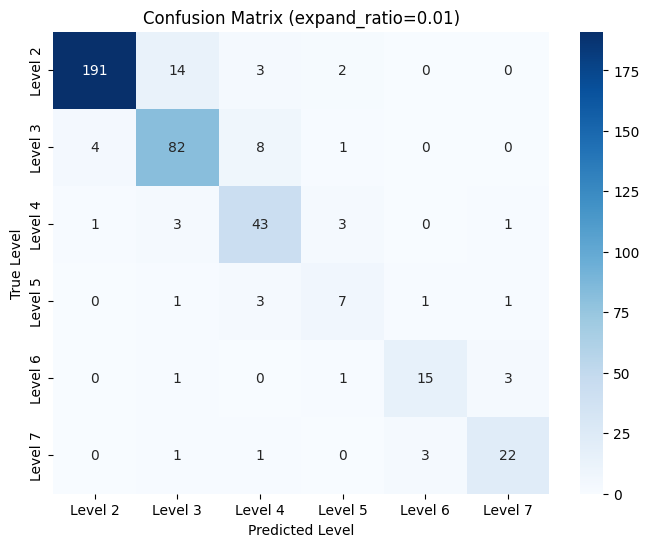


Classification Report:
              precision    recall  f1-score   support

     Level 2     0.9745    0.9095    0.9409       210
     Level 3     0.8039    0.8632    0.8325        95
     Level 4     0.7414    0.8431    0.7890        51
     Level 5     0.5000    0.5385    0.5185        13
     Level 6     0.7895    0.7500    0.7692        20
     Level 7     0.8148    0.8148    0.8148        27

    accuracy                         0.8654       416
   macro avg     0.7707    0.7865    0.7775       416
weighted avg     0.8729    0.8654    0.8679       416



In [ ]:
################################################################################
# Colab‐Cell: Train a Norwood‐Stage Classifier on “Cropped‐Interior” Images
# using EfficientNet-B0 with a single expand_ratio (e.g., 0.01), reading from
# combined “orig + CLAHE” folders for raw + segmented images.
#
# Now we assume:
#   • Combined segmented masks live under:
#       /content/combined_segmented_boundary/<split>/Level X/
#         ├── img001_boundary_orig.png
#         ├── img001_boundary_clahe.png
#         ├── img002_boundary_orig.png
#         ├── img002_boundary_clahe.png
#         └── …
#   • Combined raw images live under:
#       /content/combined_norwood_raw/<split>/Level X/
#         ├── img001_orig.jpg
#         ├── img001_clahe.jpg
#         ├── img002_orig.jpg
#         ├── img002_clahe.jpg
#         └── …
#
# The Dataset logic will:
#   - For each “*_boundary_*.png” in combined_segmented_boundary, extract the
#     prefix (e.g. “img001”) and the suffix (e.g. “_orig” or “_clahe”).
#   - Look up the matching raw image as prefix + suffix + “.jpg” in
#     combined_norwood_raw.
#   - Crop the raw image using the boundary mask after expanding by expand_ratio.
#
# Everything else—training loop, transforms, evaluation—remains unchanged.
#
# To change expand_ratio, just edit EXPAND_RATIO below.
#
# BEFORE RUNNING:
#   • Confirm the combined directories exist as described above.
#   • Use a GPU runtime: Runtime → Change runtime type → GPU.
################################################################################

# (0) Install & import dependencies
!pip install --quiet torch torchvision tqdm scikit-learn pandas seaborn matplotlib opencv-python efficientnet_pytorch

import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from tqdm import tqdm
from collections import Counter

# EfficientNet-B0
from efficientnet_pytorch import EfficientNet

# sklearn metrics
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

################################################################################
# (1) Custom Dataset: Use combined folders (orig + CLAHE). The “suffix” is either
# "_orig" or "_clahe" depending on the filename.
################################################################################

class NorwoodCroppedExpandedDataset(Dataset):
    def __init__(self,
                 raw_root: str,
                 boundary_root: str,
                 split: str,
                 level_names: list,
                 transform=None,
                 expand_ratio: float = 0.01):
        """
        raw_root:      "/content/combined_norwood_raw"
        boundary_root: "/content/combined_segmented_boundary"
        split:         one of "train", "valid", "test"
        level_names:   ["Level 2", "Level 3", ..., "Level 7"]
        transform:     torchvision transforms applied to each cropped image
        expand_ratio:  fraction of max(w, h) added around the hair bounding box
        """
        self.samples = []  # list of (raw_img_path, boundary_img_path, label_index)
        self.transform = transform
        self.expand_ratio = expand_ratio

        for idx, lvl in enumerate(level_names):
            raw_dir = os.path.join(raw_root, split, lvl)
            bnd_dir = os.path.join(boundary_root, split, lvl)

            if not os.path.isdir(raw_dir):
                raise FileNotFoundError(f"Raw folder not found: {raw_dir}")
            if not os.path.isdir(bnd_dir):
                raise FileNotFoundError(f"Boundary folder not found: {bnd_dir}")

            for fname in os.listdir(bnd_dir):
                # We expect boundary filenames like "img001_boundary_orig.png" or "img001_boundary_clahe.png"
                if "_boundary" not in fname.lower() or not fname.lower().endswith(".png"):
                    continue

                # Extract prefix and suffix from boundary filename
                name, ext = os.path.splitext(fname)  # e.g. name = "img001_boundary_orig"
                if "_boundary" not in name:
                    continue

                prefix, suffix = name.split("_boundary", 1)
                # suffix is either "_orig" or "_clahe"
                raw_fname = prefix + suffix + ".jpg"
                raw_path = os.path.join(raw_dir, raw_fname)
                bnd_path = os.path.join(bnd_dir, fname)

                if not os.path.isfile(raw_path):
                    raise FileNotFoundError(f"Raw image missing for boundary: {raw_path}")
                self.samples.append((raw_path, bnd_path, idx))

        if len(self.samples) == 0:
            raise ValueError(f"No samples found for split={split}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        raw_path, bnd_path, label = self.samples[index]

        # Load raw and boundary as RGB NumPy arrays
        raw_img = np.array(Image.open(raw_path).convert("RGB"))
        bnd_img = np.array(Image.open(bnd_path).convert("RGB"))
        H, W, _ = raw_img.shape

        # Create binary mask of red boundary via HSV threshold
        hsv = cv2.cvtColor(bnd_img, cv2.COLOR_RGB2HSV)
        lower1 = np.array([0, 100, 100]); upper1 = np.array([10, 255, 255])
        lower2 = np.array([160, 100, 100]); upper2 = np.array([180, 255, 255])
        mask1 = cv2.inRange(hsv, lower1, upper1)
        mask2 = cv2.inRange(hsv, lower2, upper2)
        red_boundary_mask = cv2.bitwise_or(mask1, mask2)

        # Find external contours on the red mask
        contours, _ = cv2.findContours(
            red_boundary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )

        if len(contours) == 0:
            # If no contour found, use full image
            x, y, w, h = 0, 0, W, H
        else:
            # Merge all contour points to compute a tight bounding box
            all_pts = np.vstack(contours).squeeze()
            xs, ys = all_pts[:, 0], all_pts[:, 1]
            x_min, x_max = xs.min(), xs.max()
            y_min, y_max = ys.min(), ys.max()
            x, y, w, h = int(x_min), int(y_min), int(x_max - x_min), int(y_max - y_min)

        # Expand bounding box by expand_ratio * max(w, h)
        margin = int(self.expand_ratio * max(w, h))
        x1 = max(0, x - margin)
        y1 = max(0, y - margin)
        x2 = min(W, x + w + margin)
        y2 = min(H, y + h + margin)

        # Crop raw image
        cropped = raw_img[y1:y2, x1:x2]
        if cropped.size == 0:
            cropped = raw_img.copy()

        # Convert to PIL and apply transforms
        cropped_pil = Image.fromarray(cropped)
        if self.transform:
            cropped_pil = self.transform(cropped_pil)

        return cropped_pil, label

################################################################################
# (2) Paths, Classes, and Transforms
################################################################################

# ────────────────────────────────────────────────────────────────────────────────
# Change these two roots to point at your combined folders:
# ────────────────────────────────────────────────────────────────────────────────

RAW_ROOT      = "/content/norwood_dataset_combined"
BOUNDARY_ROOT = "/content/segmented_boundary_clahe"

# We still expect the same “train/Level 2, train/Level 3… valid/… test/…” structure
SPLITS        = ["train", "valid", "test"]
LEVEL_NAMES   = [f"Level {i}" for i in range(2, 8)]  # ["Level 2", "Level 3", ..., "Level 7"]

# Verify folder structure once
for split in SPLITS:
    for lvl in LEVEL_NAMES:
        raw_dir = os.path.join(RAW_ROOT,  split, lvl)
        bnd_dir = os.path.join(BOUNDARY_ROOT, split, lvl)
        if not os.path.isdir(raw_dir):
            raise FileNotFoundError(f"Missing raw folder: {raw_dir}")
        if not os.path.isdir(bnd_dir):
            raise FileNotFoundError(f"Missing boundary folder: {bnd_dir}")
print("Verified combined raw + combined segmented folder structure.")

# Transforms: resize to 224×224, augment on train
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])
eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

################################################################################
# (3) Set expand_ratio and instantiate Datasets & DataLoaders (no loop)
################################################################################

# Change this value to experiment with a different expand_ratio:
EXPAND_RATIO = 0.01  # 1% of max(w, h)

print(f"\n▶ Running with expand_ratio = {EXPAND_RATIO:.2f}")

train_dataset = NorwoodCroppedExpandedDataset(
    raw_root=RAW_ROOT,
    boundary_root=BOUNDARY_ROOT,
    split="train",
    level_names=LEVEL_NAMES,
    transform=train_transform,
    expand_ratio=EXPAND_RATIO
)
valid_dataset = NorwoodCroppedExpandedDataset(
    raw_root=RAW_ROOT,
    boundary_root=BOUNDARY_ROOT,
    split="valid",
    level_names=LEVEL_NAMES,
    transform=eval_transform,
    expand_ratio=EXPAND_RATIO
)
test_dataset = NorwoodCroppedExpandedDataset(
    raw_root=RAW_ROOT,
    boundary_root=BOUNDARY_ROOT,
    split="test",
    level_names=LEVEL_NAMES,
    transform=eval_transform,
    expand_ratio=EXPAND_RATIO
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,
                          num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False,
                          num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False,
                          num_workers=2, pin_memory=True)

print(f"Train samples: {len(train_dataset)}")
print(f"Valid samples: {len(valid_dataset)}")
print(f"Test samples:  {len(test_dataset)}")

################################################################################
# (4) Build your classifier & move to GPU
################################################################################

import torchvision.models as models

# You can now set MODEL_NAME to one of:
# "efficientnet-b0", "efficientnet-b2",
# "mobilenet_v2", "mobilenet_v3_large",
# "resnet18", "resnet34", "resnet50",
# "resnext50_32x4d",
# "vgg16",
# "densenet121",
# "shufflenet_v2_x1_0",
# "convnext_tiny",
# "vit_b_16",
# "swin_tiny_patch4_window7_224",
# or "custom_cnn"

MODEL_NAME = "efficientnet-b0"   # ← change as desired

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if MODEL_NAME == "efficientnet-b0":
    from efficientnet_pytorch import EfficientNet
    model = EfficientNet.from_pretrained("efficientnet-b0")
    in_features = model._fc.in_features
    model._fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "efficientnet-b2":
    from efficientnet_pytorch import EfficientNet
    model = EfficientNet.from_pretrained("efficientnet-b2")
    in_features = model._fc.in_features
    model._fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "mobilenet_v2":
    model = models.mobilenet_v2(pretrained=True)
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "mobilenet_v3_large":
    model = models.mobilenet_v3_large(pretrained=True)
    in_features = model.classifier[3].in_features
    model.classifier[3] = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "resnet18":
    model = models.resnet18(pretrained=True)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "resnet34":
    model = models.resnet34(pretrained=True)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "resnet50":
    model = models.resnet50(pretrained=True)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "resnext50_32x4d":
    model = models.resnext50_32x4d(pretrained=True)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "vgg16":
    model = models.vgg16(pretrained=True)
    in_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "densenet121":
    model = models.densenet121(pretrained=True)
    in_features = model.classifier.in_features
    model.classifier = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "shufflenet_v2_x1_0":
    model = models.shufflenet_v2_x1_0(pretrained=True)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "convnext_tiny":
    model = models.convnext_tiny(pretrained=True)
    in_features = model.classifier[2].in_features
    model.classifier[2] = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "vit_b_16":
    model = models.vit_b_16(pretrained=True)
    in_features = model.heads.head.in_features
    model.heads.head = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "swin_tiny_patch4_window7_224":
    model = models.swin_t(pretrained=True)
    in_features = model.head.in_features
    model.head = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "custom_cnn":
    # Make sure you have defined CustomCNN somewhere above:
    # class CustomCNN(nn.Module):
    #     def __init__(self, num_classes): …
    #     def forward(self, x): …
    model = CustomCNN(num_classes=len(LEVEL_NAMES))

else:
    raise ValueError(f"Unknown MODEL_NAME: {MODEL_NAME}")

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

################################################################################
# (5) Training & validation loop (10 epochs)
################################################################################

num_epochs      = 10
best_valid_acc  = 0.0
best_checkpoint = "/content/best_efficientnetb0_single_ratio.pth"

for epoch in range(1, num_epochs + 1):
    # --- Training Phase ---
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_train = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} [Train]"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels).item()
        total_train += inputs.size(0)

    epoch_acc = running_corrects / total_train
    print(f"    [Epoch {epoch}] Train Acc: {epoch_acc:.4f}")

    # --- Validation Phase ---
    model.eval()
    val_corrects = 0
    total_valid = 0

    with torch.no_grad():
        for inputs, labels in tqdm(valid_loader, desc=f"Epoch {epoch}/{num_epochs} [Valid]"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels).item()
            total_valid += inputs.size(0)

    val_acc = val_corrects / total_valid
    print(f"    [Epoch {epoch}] Valid Acc: {val_acc:.4f}")

    # Save checkpoint if validation improves
    if val_acc > best_valid_acc:
        best_valid_acc = val_acc
        torch.save(model.state_dict(), best_checkpoint)
        print(f"      → New best valid acc: {best_valid_acc:.4f}. Saved to {best_checkpoint}")

################################################################################
# (6) Load best checkpoint and evaluate on test set
################################################################################

model.load_state_dict(torch.load(best_checkpoint))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

test_f1_macro = f1_score(all_labels, all_preds, average="macro")
test_acc = (np.array(all_preds) == np.array(all_labels)).mean()

print(f"\n▶ Final Test Accuracy: {test_acc*100:.2f}%  ({len(all_labels)} samples)")
print(f"▶ Final Test Macro F1: {test_f1_macro:.4f}")

# (Optional) Print confusion matrix and classification report
cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(LEVEL_NAMES))))
cm_df = pd.DataFrame(cm, index=LEVEL_NAMES, columns=LEVEL_NAMES)
print("\nConfusion Matrix:")
print(cm_df)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.ylabel("True Level")
plt.xlabel("Predicted Level")
plt.title(f"Confusion Matrix (expand_ratio={EXPAND_RATIO:.2f})")
plt.show()

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=LEVEL_NAMES, digits=4))

################################################################################
# End of script
################################################################################


In [ ]:
# ───────────────────────────────────────────────────────────────────────────────
# Upload trained EfficientNet Norwood classifier to Hugging Face
# ───────────────────────────────────────────────────────────────────────────────

!pip install --quiet huggingface_hub

from huggingface_hub import login, create_repo, upload_folder
import json

# (A) Login with your Hugging Face token (only once per session)
login()  # Paste your token when prompted

# (B) Set repo name (change if needed)
hf_username = "alamb98"  # 🔁 Your HF username
repo_id = f"{hf_username}/{MODEL_NAME}_norwood_classifier"

# (C) Create or reuse existing repo
create_repo(repo_id, repo_type="model", exist_ok=True)

# (D) Save model checkpoint & metadata
model_path = f"{MODEL_NAME}_best.pth"
torch.save(model.state_dict(), model_path)

metadata = {
    "model_name": MODEL_NAME,
    "expand_ratio": EXPAND_RATIO,
    "num_classes": len(LEVEL_NAMES),
    "class_names": LEVEL_NAMES,
    "test_accuracy": round(float(test_acc), 4),
    "macro_f1_score": round(float(test_f1_macro), 4),
    "architecture": "PyTorch",
    "framework": "torchvision.models",
    "description": (
        "EfficientNet-based Norwood scale classifier trained on cropped male scalp "
        "images from multiple angles (front, back, left, right, top-down). "
        "Crops are obtained using segmentation boundaries and expanded by "
        f"{EXPAND_RATIO*100:.1f}%."
    )
}
with open("metadata.json", "w") as f:
    json.dump(metadata, f, indent=2)

# (E) Upload both model and metadata.json
upload_folder(
    folder_path=".",
    repo_id=repo_id,
    repo_type="model",
    allow_patterns=[model_path, "metadata.json"]
)

print(f"\n✅ Model & metadata uploaded: https://huggingface.co/{repo_id}")


Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...gmentation/efficientnet-b0_best.pth:   3%|3         |  554kB / 16.4MB            


✅ Model & metadata uploaded: https://huggingface.co/alamb98/efficientnet-b0_norwood_classifier


mobilenet_v3_large

Verified combined raw + combined segmented folder structure.

▶ Running with expand_ratio = 0.01
Train samples: 9069
Valid samples: 895
Test samples:  416


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Train]: 100%|██████████| 284/284 [01:04<00:00,  4.41it/s]


    [Epoch 1] Train Acc: 0.6567


Epoch 1/10 [Valid]: 100%|██████████| 28/28 [00:05<00:00,  4.92it/s]


    [Epoch 1] Valid Acc: 0.7441
      → New best valid acc: 0.7441. Saved to /content/best_efficientnetb0_single_ratio.pth


Epoch 2/10 [Train]: 100%|██████████| 284/284 [01:02<00:00,  4.55it/s]


    [Epoch 2] Train Acc: 0.8475


Epoch 2/10 [Valid]: 100%|██████████| 28/28 [00:05<00:00,  4.99it/s]


    [Epoch 2] Valid Acc: 0.7933
      → New best valid acc: 0.7933. Saved to /content/best_efficientnetb0_single_ratio.pth


Epoch 3/10 [Train]: 100%|██████████| 284/284 [01:03<00:00,  4.50it/s]


    [Epoch 3] Train Acc: 0.9179


Epoch 3/10 [Valid]: 100%|██████████| 28/28 [00:05<00:00,  4.96it/s]


    [Epoch 3] Valid Acc: 0.8201
      → New best valid acc: 0.8201. Saved to /content/best_efficientnetb0_single_ratio.pth


Epoch 4/10 [Train]: 100%|██████████| 284/284 [01:02<00:00,  4.55it/s]


    [Epoch 4] Train Acc: 0.9487


Epoch 4/10 [Valid]: 100%|██████████| 28/28 [00:05<00:00,  4.92it/s]


    [Epoch 4] Valid Acc: 0.8145


Epoch 5/10 [Train]: 100%|██████████| 284/284 [01:02<00:00,  4.51it/s]


    [Epoch 5] Train Acc: 0.9682


Epoch 5/10 [Valid]: 100%|██████████| 28/28 [00:05<00:00,  4.93it/s]


    [Epoch 5] Valid Acc: 0.8346
      → New best valid acc: 0.8346. Saved to /content/best_efficientnetb0_single_ratio.pth


Epoch 6/10 [Train]: 100%|██████████| 284/284 [01:02<00:00,  4.54it/s]


    [Epoch 6] Train Acc: 0.9765


Epoch 6/10 [Valid]: 100%|██████████| 28/28 [00:05<00:00,  5.00it/s]


    [Epoch 6] Valid Acc: 0.8268


Epoch 7/10 [Train]: 100%|██████████| 284/284 [01:02<00:00,  4.54it/s]


    [Epoch 7] Train Acc: 0.9792


Epoch 7/10 [Valid]: 100%|██████████| 28/28 [00:05<00:00,  5.05it/s]


    [Epoch 7] Valid Acc: 0.8391
      → New best valid acc: 0.8391. Saved to /content/best_efficientnetb0_single_ratio.pth


Epoch 8/10 [Train]: 100%|██████████| 284/284 [01:02<00:00,  4.54it/s]


    [Epoch 8] Train Acc: 0.9864


Epoch 8/10 [Valid]: 100%|██████████| 28/28 [00:05<00:00,  4.92it/s]


    [Epoch 8] Valid Acc: 0.8391


Epoch 9/10 [Train]: 100%|██████████| 284/284 [01:03<00:00,  4.51it/s]


    [Epoch 9] Train Acc: 0.9831


Epoch 9/10 [Valid]: 100%|██████████| 28/28 [00:05<00:00,  4.98it/s]


    [Epoch 9] Valid Acc: 0.8291


Epoch 10/10 [Train]: 100%|██████████| 284/284 [01:03<00:00,  4.49it/s]


    [Epoch 10] Train Acc: 0.9836


Epoch 10/10 [Valid]: 100%|██████████| 28/28 [00:05<00:00,  4.88it/s]


    [Epoch 10] Valid Acc: 0.8402
      → New best valid acc: 0.8402. Saved to /content/best_efficientnetb0_single_ratio.pth


Testing: 100%|██████████| 13/13 [00:02<00:00,  4.54it/s]



▶ Final Test Accuracy: 85.10%  (416 samples)
▶ Final Test Macro F1: 0.7384

Confusion Matrix:
         Level 2  Level 3  Level 4  Level 5  Level 6  Level 7
Level 2      189       17        3        1        0        0
Level 3        5       83        4        2        1        0
Level 4        2        7       40        1        1        0
Level 5        1        2        4        3        1        2
Level 6        0        1        2        0       14        3
Level 7        0        1        1        0        0       25


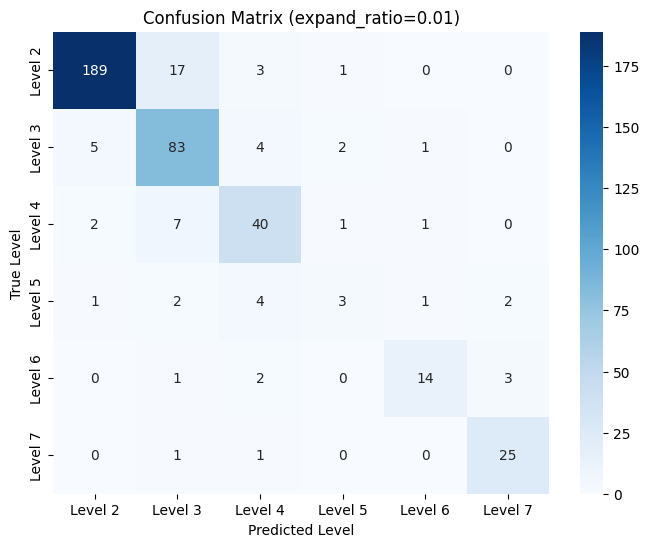


Classification Report:
              precision    recall  f1-score   support

     Level 2     0.9594    0.9000    0.9287       210
     Level 3     0.7477    0.8737    0.8058        95
     Level 4     0.7407    0.7843    0.7619        51
     Level 5     0.4286    0.2308    0.3000        13
     Level 6     0.8235    0.7000    0.7568        20
     Level 7     0.8333    0.9259    0.8772        27

    accuracy                         0.8510       416
   macro avg     0.7556    0.7358    0.7384       416
weighted avg     0.8530    0.8510    0.8490       416



In [ ]:
################################################################################
# Colab‐Cell: Train a Norwood‐Stage Classifier on “Cropped‐Interior” Images
# using EfficientNet-B0 with a single expand_ratio (e.g., 0.01), reading from
# combined “orig + CLAHE” folders for raw + segmented images.
#
# Now we assume:
#   • Combined segmented masks live under:
#       /content/combined_segmented_boundary/<split>/Level X/
#         ├── img001_boundary_orig.png
#         ├── img001_boundary_clahe.png
#         ├── img002_boundary_orig.png
#         ├── img002_boundary_clahe.png
#         └── …
#   • Combined raw images live under:
#       /content/combined_norwood_raw/<split>/Level X/
#         ├── img001_orig.jpg
#         ├── img001_clahe.jpg
#         ├── img002_orig.jpg
#         ├── img002_clahe.jpg
#         └── …
#
# The Dataset logic will:
#   - For each “*_boundary_*.png” in combined_segmented_boundary, extract the
#     prefix (e.g. “img001”) and the suffix (e.g. “_orig” or “_clahe”).
#   - Look up the matching raw image as prefix + suffix + “.jpg” in
#     combined_norwood_raw.
#   - Crop the raw image using the boundary mask after expanding by expand_ratio.
#
# Everything else—training loop, transforms, evaluation—remains unchanged.
#
# To change expand_ratio, just edit EXPAND_RATIO below.
#
# BEFORE RUNNING:
#   • Confirm the combined directories exist as described above.
#   • Use a GPU runtime: Runtime → Change runtime type → GPU.
################################################################################

# (0) Install & import dependencies
!pip install --quiet torch torchvision tqdm scikit-learn pandas seaborn matplotlib opencv-python efficientnet_pytorch

import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from tqdm import tqdm
from collections import Counter

# EfficientNet-B0
from efficientnet_pytorch import EfficientNet

# sklearn metrics
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

################################################################################
# (1) Custom Dataset: Use combined folders (orig + CLAHE). The “suffix” is either
# "_orig" or "_clahe" depending on the filename.
################################################################################

class NorwoodCroppedExpandedDataset(Dataset):
    def __init__(self,
                 raw_root: str,
                 boundary_root: str,
                 split: str,
                 level_names: list,
                 transform=None,
                 expand_ratio: float = 0.01):
        """
        raw_root:      "/content/combined_norwood_raw"
        boundary_root: "/content/combined_segmented_boundary"
        split:         one of "train", "valid", "test"
        level_names:   ["Level 2", "Level 3", ..., "Level 7"]
        transform:     torchvision transforms applied to each cropped image
        expand_ratio:  fraction of max(w, h) added around the hair bounding box
        """
        self.samples = []  # list of (raw_img_path, boundary_img_path, label_index)
        self.transform = transform
        self.expand_ratio = expand_ratio

        for idx, lvl in enumerate(level_names):
            raw_dir = os.path.join(raw_root, split, lvl)
            bnd_dir = os.path.join(boundary_root, split, lvl)

            if not os.path.isdir(raw_dir):
                raise FileNotFoundError(f"Raw folder not found: {raw_dir}")
            if not os.path.isdir(bnd_dir):
                raise FileNotFoundError(f"Boundary folder not found: {bnd_dir}")

            for fname in os.listdir(bnd_dir):
                # We expect boundary filenames like "img001_boundary_orig.png" or "img001_boundary_clahe.png"
                if "_boundary" not in fname.lower() or not fname.lower().endswith(".png"):
                    continue

                # Extract prefix and suffix from boundary filename
                name, ext = os.path.splitext(fname)  # e.g. name = "img001_boundary_orig"
                if "_boundary" not in name:
                    continue

                prefix, suffix = name.split("_boundary", 1)
                # suffix is either "_orig" or "_clahe"
                raw_fname = prefix + suffix + ".jpg"
                raw_path = os.path.join(raw_dir, raw_fname)
                bnd_path = os.path.join(bnd_dir, fname)

                if not os.path.isfile(raw_path):
                    raise FileNotFoundError(f"Raw image missing for boundary: {raw_path}")
                self.samples.append((raw_path, bnd_path, idx))

        if len(self.samples) == 0:
            raise ValueError(f"No samples found for split={split}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        raw_path, bnd_path, label = self.samples[index]

        # Load raw and boundary as RGB NumPy arrays
        raw_img = np.array(Image.open(raw_path).convert("RGB"))
        bnd_img = np.array(Image.open(bnd_path).convert("RGB"))
        H, W, _ = raw_img.shape

        # Create binary mask of red boundary via HSV threshold
        hsv = cv2.cvtColor(bnd_img, cv2.COLOR_RGB2HSV)
        lower1 = np.array([0, 100, 100]); upper1 = np.array([10, 255, 255])
        lower2 = np.array([160, 100, 100]); upper2 = np.array([180, 255, 255])
        mask1 = cv2.inRange(hsv, lower1, upper1)
        mask2 = cv2.inRange(hsv, lower2, upper2)
        red_boundary_mask = cv2.bitwise_or(mask1, mask2)

        # Find external contours on the red mask
        contours, _ = cv2.findContours(
            red_boundary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )

        if len(contours) == 0:
            # If no contour found, use full image
            x, y, w, h = 0, 0, W, H
        else:
            # Merge all contour points to compute a tight bounding box
            all_pts = np.vstack(contours).squeeze()
            xs, ys = all_pts[:, 0], all_pts[:, 1]
            x_min, x_max = xs.min(), xs.max()
            y_min, y_max = ys.min(), ys.max()
            x, y, w, h = int(x_min), int(y_min), int(x_max - x_min), int(y_max - y_min)

        # Expand bounding box by expand_ratio * max(w, h)
        margin = int(self.expand_ratio * max(w, h))
        x1 = max(0, x - margin)
        y1 = max(0, y - margin)
        x2 = min(W, x + w + margin)
        y2 = min(H, y + h + margin)

        # Crop raw image
        cropped = raw_img[y1:y2, x1:x2]
        if cropped.size == 0:
            cropped = raw_img.copy()

        # Convert to PIL and apply transforms
        cropped_pil = Image.fromarray(cropped)
        if self.transform:
            cropped_pil = self.transform(cropped_pil)

        return cropped_pil, label

################################################################################
# (2) Paths, Classes, and Transforms
################################################################################

# ────────────────────────────────────────────────────────────────────────────────
# Change these two roots to point at your combined folders:
# ────────────────────────────────────────────────────────────────────────────────

RAW_ROOT      = "/content/norwood_dataset_combined"
BOUNDARY_ROOT = "/content/segmented_boundary_clahe"

# We still expect the same “train/Level 2, train/Level 3… valid/… test/…” structure
SPLITS        = ["train", "valid", "test"]
LEVEL_NAMES   = [f"Level {i}" for i in range(2, 8)]  # ["Level 2", "Level 3", ..., "Level 7"]

# Verify folder structure once
for split in SPLITS:
    for lvl in LEVEL_NAMES:
        raw_dir = os.path.join(RAW_ROOT,  split, lvl)
        bnd_dir = os.path.join(BOUNDARY_ROOT, split, lvl)
        if not os.path.isdir(raw_dir):
            raise FileNotFoundError(f"Missing raw folder: {raw_dir}")
        if not os.path.isdir(bnd_dir):
            raise FileNotFoundError(f"Missing boundary folder: {bnd_dir}")
print("Verified combined raw + combined segmented folder structure.")

# Transforms: resize to 224×224, augment on train
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])
eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

################################################################################
# (3) Set expand_ratio and instantiate Datasets & DataLoaders (no loop)
################################################################################

# Change this value to experiment with a different expand_ratio:
EXPAND_RATIO = 0.01  # 1% of max(w, h)

print(f"\n▶ Running with expand_ratio = {EXPAND_RATIO:.2f}")

train_dataset = NorwoodCroppedExpandedDataset(
    raw_root=RAW_ROOT,
    boundary_root=BOUNDARY_ROOT,
    split="train",
    level_names=LEVEL_NAMES,
    transform=train_transform,
    expand_ratio=EXPAND_RATIO
)
valid_dataset = NorwoodCroppedExpandedDataset(
    raw_root=RAW_ROOT,
    boundary_root=BOUNDARY_ROOT,
    split="valid",
    level_names=LEVEL_NAMES,
    transform=eval_transform,
    expand_ratio=EXPAND_RATIO
)
test_dataset = NorwoodCroppedExpandedDataset(
    raw_root=RAW_ROOT,
    boundary_root=BOUNDARY_ROOT,
    split="test",
    level_names=LEVEL_NAMES,
    transform=eval_transform,
    expand_ratio=EXPAND_RATIO
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,
                          num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False,
                          num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False,
                          num_workers=2, pin_memory=True)

print(f"Train samples: {len(train_dataset)}")
print(f"Valid samples: {len(valid_dataset)}")
print(f"Test samples:  {len(test_dataset)}")

################################################################################
# (4) Build your classifier & move to GPU
################################################################################

import torchvision.models as models

# You can now set MODEL_NAME to one of:
# "efficientnet-b0", "efficientnet-b2",
# "mobilenet_v2", "mobilenet_v3_large",
# "resnet18", "resnet34", "resnet50",
# "resnext50_32x4d",
# "vgg16",
# "densenet121",
# "shufflenet_v2_x1_0",
# "convnext_tiny",
# "vit_b_16",
# "swin_tiny_patch4_window7_224",
# or "custom_cnn"

MODEL_NAME = "mobilenet_v3_large"   # ← change as desired

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if MODEL_NAME == "efficientnet-b0":
    from efficientnet_pytorch import EfficientNet
    model = EfficientNet.from_pretrained("efficientnet-b0")
    in_features = model._fc.in_features
    model._fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "efficientnet-b2":
    from efficientnet_pytorch import EfficientNet
    model = EfficientNet.from_pretrained("efficientnet-b2")
    in_features = model._fc.in_features
    model._fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "mobilenet_v2":
    model = models.mobilenet_v2(pretrained=True)
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "mobilenet_v3_large":
    model = models.mobilenet_v3_large(pretrained=True)
    in_features = model.classifier[3].in_features
    model.classifier[3] = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "resnet18":
    model = models.resnet18(pretrained=True)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "resnet34":
    model = models.resnet34(pretrained=True)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "resnet50":
    model = models.resnet50(pretrained=True)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "resnext50_32x4d":
    model = models.resnext50_32x4d(pretrained=True)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "vgg16":
    model = models.vgg16(pretrained=True)
    in_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "densenet121":
    model = models.densenet121(pretrained=True)
    in_features = model.classifier.in_features
    model.classifier = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "shufflenet_v2_x1_0":
    model = models.shufflenet_v2_x1_0(pretrained=True)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "convnext_tiny":
    model = models.convnext_tiny(pretrained=True)
    in_features = model.classifier[2].in_features
    model.classifier[2] = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "vit_b_16":
    model = models.vit_b_16(pretrained=True)
    in_features = model.heads.head.in_features
    model.heads.head = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "swin_tiny_patch4_window7_224":
    model = models.swin_t(pretrained=True)
    in_features = model.head.in_features
    model.head = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "custom_cnn":
    # Make sure you have defined CustomCNN somewhere above:
    # class CustomCNN(nn.Module):
    #     def __init__(self, num_classes): …
    #     def forward(self, x): …
    model = CustomCNN(num_classes=len(LEVEL_NAMES))

else:
    raise ValueError(f"Unknown MODEL_NAME: {MODEL_NAME}")

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

################################################################################
# (5) Training & validation loop (10 epochs)
################################################################################

num_epochs      = 10
best_valid_acc  = 0.0
best_checkpoint = "/content/best_efficientnetb0_single_ratio.pth"

for epoch in range(1, num_epochs + 1):
    # --- Training Phase ---
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_train = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} [Train]"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels).item()
        total_train += inputs.size(0)

    epoch_acc = running_corrects / total_train
    print(f"    [Epoch {epoch}] Train Acc: {epoch_acc:.4f}")

    # --- Validation Phase ---
    model.eval()
    val_corrects = 0
    total_valid = 0

    with torch.no_grad():
        for inputs, labels in tqdm(valid_loader, desc=f"Epoch {epoch}/{num_epochs} [Valid]"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels).item()
            total_valid += inputs.size(0)

    val_acc = val_corrects / total_valid
    print(f"    [Epoch {epoch}] Valid Acc: {val_acc:.4f}")

    # Save checkpoint if validation improves
    if val_acc > best_valid_acc:
        best_valid_acc = val_acc
        torch.save(model.state_dict(), best_checkpoint)
        print(f"      → New best valid acc: {best_valid_acc:.4f}. Saved to {best_checkpoint}")

################################################################################
# (6) Load best checkpoint and evaluate on test set
################################################################################

model.load_state_dict(torch.load(best_checkpoint))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

test_f1_macro = f1_score(all_labels, all_preds, average="macro")
test_acc = (np.array(all_preds) == np.array(all_labels)).mean()

print(f"\n▶ Final Test Accuracy: {test_acc*100:.2f}%  ({len(all_labels)} samples)")
print(f"▶ Final Test Macro F1: {test_f1_macro:.4f}")

# (Optional) Print confusion matrix and classification report
cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(LEVEL_NAMES))))
cm_df = pd.DataFrame(cm, index=LEVEL_NAMES, columns=LEVEL_NAMES)
print("\nConfusion Matrix:")
print(cm_df)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.ylabel("True Level")
plt.xlabel("Predicted Level")
plt.title(f"Confusion Matrix (expand_ratio={EXPAND_RATIO:.2f})")
plt.show()

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=LEVEL_NAMES, digits=4))

################################################################################
# End of script
################################################################################


In [ ]:
# ───────────────────────────────────────────────────────────────────────────────
# Upload trained model checkpoint and metadata to Hugging Face
# ───────────────────────────────────────────────────────────────────────────────

!pip install --quiet huggingface_hub

from huggingface_hub import login, create_repo, upload_folder
import json

# (A) Login with your token (only once per session)
login()  # Paste your Hugging Face token when prompted

# (B) Set repo name (adjust if needed)
hf_username = "alamb98"  # 🔁 Your HF username
repo_id = f"{hf_username}/{MODEL_NAME}_cropped_clahe_norwood_classifier"

# (C) Create or use existing repo
create_repo(repo_id, repo_type="model", exist_ok=True)

# (D) Save model checkpoint and metadata
model_path = f"{MODEL_NAME}_cropped_clahe_best.pth"
torch.save(model.state_dict(), model_path)

metadata = {
    "model_name": MODEL_NAME,
    "expand_ratio": float(EXPAND_RATIO),
    "num_classes": len(LEVEL_NAMES),
    "class_names": LEVEL_NAMES,
    "test_accuracy": round(float(test_acc), 4),
    "macro_f1_score": round(float(test_f1_macro), 4),
    "architecture": MODEL_NAME,
    "framework": "PyTorch",
    "trained_on": "cropped scalp images from combined orig + CLAHE raw & segmented datasets",
    "description": (
        f"{MODEL_NAME} classifier for Norwood stages (2–7) using cropped hair "
        "region based on segmented boundaries and raw images."
    )
}
with open("metadata.json", "w") as f:
    json.dump(metadata, f, indent=2)

# (E) Upload both model and metadata.json
upload_folder(
    folder_path=".",
    repo_id=repo_id,
    repo_type="model",
    allow_patterns=[model_path, "metadata.json"]
)

print(f"\n✅ Uploaded to: https://huggingface.co/{repo_id}")


Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...net_v3_large_cropped_clahe_best.pth:   3%|3         |  554kB / 17.1MB            


✅ Uploaded to: https://huggingface.co/alamb98/mobilenet_v3_large_cropped_clahe_norwood_classifier


resnet34

In [ ]:
################################################################################
# Colab‐Cell: Train a Norwood‐Stage Classifier on “Cropped‐Interior” Images
# using EfficientNet-B0 with a single expand_ratio (e.g., 0.01), reading from
# combined “orig + CLAHE” folders for raw + segmented images.
#
# Now we assume:
#   • Combined segmented masks live under:
#       /content/combined_segmented_boundary/<split>/Level X/
#         ├── img001_boundary_orig.png
#         ├── img001_boundary_clahe.png
#         ├── img002_boundary_orig.png
#         ├── img002_boundary_clahe.png
#         └── …
#   • Combined raw images live under:
#       /content/combined_norwood_raw/<split>/Level X/
#         ├── img001_orig.jpg
#         ├── img001_clahe.jpg
#         ├── img002_orig.jpg
#         ├── img002_clahe.jpg
#         └── …
#
# The Dataset logic will:
#   - For each “*_boundary_*.png” in combined_segmented_boundary, extract the
#     prefix (e.g. “img001”) and the suffix (e.g. “_orig” or “_clahe”).
#   - Look up the matching raw image as prefix + suffix + “.jpg” in
#     combined_norwood_raw.
#   - Crop the raw image using the boundary mask after expanding by expand_ratio.
#
# Everything else—training loop, transforms, evaluation—remains unchanged.
#
# To change expand_ratio, just edit EXPAND_RATIO below.
#
# BEFORE RUNNING:
#   • Confirm the combined directories exist as described above.
#   • Use a GPU runtime: Runtime → Change runtime type → GPU.
################################################################################

# (0) Install & import dependencies
!pip install --quiet torch torchvision tqdm scikit-learn pandas seaborn matplotlib opencv-python efficientnet_pytorch

import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from tqdm import tqdm
from collections import Counter

# EfficientNet-B0
from efficientnet_pytorch import EfficientNet

# sklearn metrics
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

################################################################################
# (1) Custom Dataset: Use combined folders (orig + CLAHE). The “suffix” is either
# "_orig" or "_clahe" depending on the filename.
################################################################################

class NorwoodCroppedExpandedDataset(Dataset):
    def __init__(self,
                 raw_root: str,
                 boundary_root: str,
                 split: str,
                 level_names: list,
                 transform=None,
                 expand_ratio: float = 0.01):
        """
        raw_root:      "/content/combined_norwood_raw"
        boundary_root: "/content/combined_segmented_boundary"
        split:         one of "train", "valid", "test"
        level_names:   ["Level 2", "Level 3", ..., "Level 7"]
        transform:     torchvision transforms applied to each cropped image
        expand_ratio:  fraction of max(w, h) added around the hair bounding box
        """
        self.samples = []  # list of (raw_img_path, boundary_img_path, label_index)
        self.transform = transform
        self.expand_ratio = expand_ratio

        for idx, lvl in enumerate(level_names):
            raw_dir = os.path.join(raw_root, split, lvl)
            bnd_dir = os.path.join(boundary_root, split, lvl)

            if not os.path.isdir(raw_dir):
                raise FileNotFoundError(f"Raw folder not found: {raw_dir}")
            if not os.path.isdir(bnd_dir):
                raise FileNotFoundError(f"Boundary folder not found: {bnd_dir}")

            for fname in os.listdir(bnd_dir):
                # We expect boundary filenames like "img001_boundary_orig.png" or "img001_boundary_clahe.png"
                if "_boundary" not in fname.lower() or not fname.lower().endswith(".png"):
                    continue

                # Extract prefix and suffix from boundary filename
                name, ext = os.path.splitext(fname)  # e.g. name = "img001_boundary_orig"
                if "_boundary" not in name:
                    continue

                prefix, suffix = name.split("_boundary", 1)
                # suffix is either "_orig" or "_clahe"
                raw_fname = prefix + suffix + ".jpg"
                raw_path = os.path.join(raw_dir, raw_fname)
                bnd_path = os.path.join(bnd_dir, fname)

                if not os.path.isfile(raw_path):
                    raise FileNotFoundError(f"Raw image missing for boundary: {raw_path}")
                self.samples.append((raw_path, bnd_path, idx))

        if len(self.samples) == 0:
            raise ValueError(f"No samples found for split={split}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        raw_path, bnd_path, label = self.samples[index]

        # Load raw and boundary as RGB NumPy arrays
        raw_img = np.array(Image.open(raw_path).convert("RGB"))
        bnd_img = np.array(Image.open(bnd_path).convert("RGB"))
        H, W, _ = raw_img.shape

        # Create binary mask of red boundary via HSV threshold
        hsv = cv2.cvtColor(bnd_img, cv2.COLOR_RGB2HSV)
        lower1 = np.array([0, 100, 100]); upper1 = np.array([10, 255, 255])
        lower2 = np.array([160, 100, 100]); upper2 = np.array([180, 255, 255])
        mask1 = cv2.inRange(hsv, lower1, upper1)
        mask2 = cv2.inRange(hsv, lower2, upper2)
        red_boundary_mask = cv2.bitwise_or(mask1, mask2)

        # Find external contours on the red mask
        contours, _ = cv2.findContours(
            red_boundary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )

        if len(contours) == 0:
            # If no contour found, use full image
            x, y, w, h = 0, 0, W, H
        else:
            # Merge all contour points to compute a tight bounding box
            all_pts = np.vstack(contours).squeeze()
            xs, ys = all_pts[:, 0], all_pts[:, 1]
            x_min, x_max = xs.min(), xs.max()
            y_min, y_max = ys.min(), ys.max()
            x, y, w, h = int(x_min), int(y_min), int(x_max - x_min), int(y_max - y_min)

        # Expand bounding box by expand_ratio * max(w, h)
        margin = int(self.expand_ratio * max(w, h))
        x1 = max(0, x - margin)
        y1 = max(0, y - margin)
        x2 = min(W, x + w + margin)
        y2 = min(H, y + h + margin)

        # Crop raw image
        cropped = raw_img[y1:y2, x1:x2]
        if cropped.size == 0:
            cropped = raw_img.copy()

        # Convert to PIL and apply transforms
        cropped_pil = Image.fromarray(cropped)
        if self.transform:
            cropped_pil = self.transform(cropped_pil)

        return cropped_pil, label

################################################################################
# (2) Paths, Classes, and Transforms
################################################################################

# ────────────────────────────────────────────────────────────────────────────────
# Change these two roots to point at your combined folders:
# ────────────────────────────────────────────────────────────────────────────────

RAW_ROOT      = "/content/norwood_dataset_combined"
BOUNDARY_ROOT = "/content/segmented_boundary_clahe"

# We still expect the same “train/Level 2, train/Level 3… valid/… test/…” structure
SPLITS        = ["train", "valid", "test"]
LEVEL_NAMES   = [f"Level {i}" for i in range(2, 8)]  # ["Level 2", "Level 3", ..., "Level 7"]

# Verify folder structure once
for split in SPLITS:
    for lvl in LEVEL_NAMES:
        raw_dir = os.path.join(RAW_ROOT,  split, lvl)
        bnd_dir = os.path.join(BOUNDARY_ROOT, split, lvl)
        if not os.path.isdir(raw_dir):
            raise FileNotFoundError(f"Missing raw folder: {raw_dir}")
        if not os.path.isdir(bnd_dir):
            raise FileNotFoundError(f"Missing boundary folder: {bnd_dir}")
print("Verified combined raw + combined segmented folder structure.")

# Transforms: resize to 224×224, augment on train
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])
eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

################################################################################
# (3) Set expand_ratio and instantiate Datasets & DataLoaders (no loop)
################################################################################

# Change this value to experiment with a different expand_ratio:
EXPAND_RATIO = 0.01  # 1% of max(w, h)

print(f"\n▶ Running with expand_ratio = {EXPAND_RATIO:.2f}")

train_dataset = NorwoodCroppedExpandedDataset(
    raw_root=RAW_ROOT,
    boundary_root=BOUNDARY_ROOT,
    split="train",
    level_names=LEVEL_NAMES,
    transform=train_transform,
    expand_ratio=EXPAND_RATIO
)
valid_dataset = NorwoodCroppedExpandedDataset(
    raw_root=RAW_ROOT,
    boundary_root=BOUNDARY_ROOT,
    split="valid",
    level_names=LEVEL_NAMES,
    transform=eval_transform,
    expand_ratio=EXPAND_RATIO
)
test_dataset = NorwoodCroppedExpandedDataset(
    raw_root=RAW_ROOT,
    boundary_root=BOUNDARY_ROOT,
    split="test",
    level_names=LEVEL_NAMES,
    transform=eval_transform,
    expand_ratio=EXPAND_RATIO
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,
                          num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False,
                          num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False,
                          num_workers=2, pin_memory=True)

print(f"Train samples: {len(train_dataset)}")
print(f"Valid samples: {len(valid_dataset)}")
print(f"Test samples:  {len(test_dataset)}")

################################################################################
# (4) Build your classifier & move to GPU
################################################################################

import torchvision.models as models

# You can now set MODEL_NAME to one of:
# "efficientnet-b0", "efficientnet-b2",
# "mobilenet_v2", "mobilenet_v3_large",
# "resnet18", "resnet34", "resnet50",
# "resnext50_32x4d",
# "vgg16",
# "densenet121",
# "shufflenet_v2_x1_0",
# "convnext_tiny",
# "vit_b_16",
# "swin_tiny_patch4_window7_224",
# or "custom_cnn"

MODEL_NAME = "resnet34"   # ← change as desired

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if MODEL_NAME == "efficientnet-b0":
    from efficientnet_pytorch import EfficientNet
    model = EfficientNet.from_pretrained("efficientnet-b0")
    in_features = model._fc.in_features
    model._fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "efficientnet-b2":
    from efficientnet_pytorch import EfficientNet
    model = EfficientNet.from_pretrained("efficientnet-b2")
    in_features = model._fc.in_features
    model._fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "mobilenet_v2":
    model = models.mobilenet_v2(pretrained=True)
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "mobilenet_v3_large":
    model = models.mobilenet_v3_large(pretrained=True)
    in_features = model.classifier[3].in_features
    model.classifier[3] = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "resnet18":
    model = models.resnet18(pretrained=True)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "resnet34":
    model = models.resnet34(pretrained=True)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "resnet50":
    model = models.resnet50(pretrained=True)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "resnext50_32x4d":
    model = models.resnext50_32x4d(pretrained=True)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "vgg16":
    model = models.vgg16(pretrained=True)
    in_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "densenet121":
    model = models.densenet121(pretrained=True)
    in_features = model.classifier.in_features
    model.classifier = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "shufflenet_v2_x1_0":
    model = models.shufflenet_v2_x1_0(pretrained=True)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "convnext_tiny":
    model = models.convnext_tiny(pretrained=True)
    in_features = model.classifier[2].in_features
    model.classifier[2] = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "vit_b_16":
    model = models.vit_b_16(pretrained=True)
    in_features = model.heads.head.in_features
    model.heads.head = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "swin_tiny_patch4_window7_224":
    model = models.swin_t(pretrained=True)
    in_features = model.head.in_features
    model.head = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "custom_cnn":
    # Make sure you have defined CustomCNN somewhere above:
    # class CustomCNN(nn.Module):
    #     def __init__(self, num_classes): …
    #     def forward(self, x): …
    model = CustomCNN(num_classes=len(LEVEL_NAMES))

else:
    raise ValueError(f"Unknown MODEL_NAME: {MODEL_NAME}")

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

################################################################################
# (5) Training & validation loop (10 epochs)
################################################################################

num_epochs      = 10
best_valid_acc  = 0.0
best_checkpoint = "/content/best_efficientnetb0_single_ratio.pth"

for epoch in range(1, num_epochs + 1):
    # --- Training Phase ---
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_train = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} [Train]"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels).item()
        total_train += inputs.size(0)

    epoch_acc = running_corrects / total_train
    print(f"    [Epoch {epoch}] Train Acc: {epoch_acc:.4f}")

    # --- Validation Phase ---
    model.eval()
    val_corrects = 0
    total_valid = 0

    with torch.no_grad():
        for inputs, labels in tqdm(valid_loader, desc=f"Epoch {epoch}/{num_epochs} [Valid]"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels).item()
            total_valid += inputs.size(0)

    val_acc = val_corrects / total_valid
    print(f"    [Epoch {epoch}] Valid Acc: {val_acc:.4f}")

    # Save checkpoint if validation improves
    if val_acc > best_valid_acc:
        best_valid_acc = val_acc
        torch.save(model.state_dict(), best_checkpoint)
        print(f"      → New best valid acc: {best_valid_acc:.4f}. Saved to {best_checkpoint}")

################################################################################
# (6) Load best checkpoint and evaluate on test set
################################################################################

model.load_state_dict(torch.load(best_checkpoint))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

test_f1_macro = f1_score(all_labels, all_preds, average="macro")
test_acc = (np.array(all_preds) == np.array(all_labels)).mean()

print(f"\n▶ Final Test Accuracy: {test_acc*100:.2f}%  ({len(all_labels)} samples)")
print(f"▶ Final Test Macro F1: {test_f1_macro:.4f}")

# (Optional) Print confusion matrix and classification report
cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(LEVEL_NAMES))))
cm_df = pd.DataFrame(cm, index=LEVEL_NAMES, columns=LEVEL_NAMES)
print("\nConfusion Matrix:")
print(cm_df)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.ylabel("True Level")
plt.xlabel("Predicted Level")
plt.title(f"Confusion Matrix (expand_ratio={EXPAND_RATIO:.2f})")
plt.show()

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=LEVEL_NAMES, digits=4))

################################################################################
# End of script
################################################################################


resnet50

In [ ]:
################################################################################
# Colab‐Cell: Train a Norwood‐Stage Classifier on “Cropped‐Interior” Images
# using EfficientNet-B0 with a single expand_ratio (e.g., 0.01), reading from
# combined “orig + CLAHE” folders for raw + segmented images.
#
# Now we assume:
#   • Combined segmented masks live under:
#       /content/combined_segmented_boundary/<split>/Level X/
#         ├── img001_boundary_orig.png
#         ├── img001_boundary_clahe.png
#         ├── img002_boundary_orig.png
#         ├── img002_boundary_clahe.png
#         └── …
#   • Combined raw images live under:
#       /content/combined_norwood_raw/<split>/Level X/
#         ├── img001_orig.jpg
#         ├── img001_clahe.jpg
#         ├── img002_orig.jpg
#         ├── img002_clahe.jpg
#         └── …
#
# The Dataset logic will:
#   - For each “*_boundary_*.png” in combined_segmented_boundary, extract the
#     prefix (e.g. “img001”) and the suffix (e.g. “_orig” or “_clahe”).
#   - Look up the matching raw image as prefix + suffix + “.jpg” in
#     combined_norwood_raw.
#   - Crop the raw image using the boundary mask after expanding by expand_ratio.
#
# Everything else—training loop, transforms, evaluation—remains unchanged.
#
# To change expand_ratio, just edit EXPAND_RATIO below.
#
# BEFORE RUNNING:
#   • Confirm the combined directories exist as described above.
#   • Use a GPU runtime: Runtime → Change runtime type → GPU.
################################################################################

# (0) Install & import dependencies
!pip install --quiet torch torchvision tqdm scikit-learn pandas seaborn matplotlib opencv-python efficientnet_pytorch

import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from tqdm import tqdm
from collections import Counter

# EfficientNet-B0
from efficientnet_pytorch import EfficientNet

# sklearn metrics
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

################################################################################
# (1) Custom Dataset: Use combined folders (orig + CLAHE). The “suffix” is either
# "_orig" or "_clahe" depending on the filename.
################################################################################

class NorwoodCroppedExpandedDataset(Dataset):
    def __init__(self,
                 raw_root: str,
                 boundary_root: str,
                 split: str,
                 level_names: list,
                 transform=None,
                 expand_ratio: float = 0.01):
        """
        raw_root:      "/content/combined_norwood_raw"
        boundary_root: "/content/combined_segmented_boundary"
        split:         one of "train", "valid", "test"
        level_names:   ["Level 2", "Level 3", ..., "Level 7"]
        transform:     torchvision transforms applied to each cropped image
        expand_ratio:  fraction of max(w, h) added around the hair bounding box
        """
        self.samples = []  # list of (raw_img_path, boundary_img_path, label_index)
        self.transform = transform
        self.expand_ratio = expand_ratio

        for idx, lvl in enumerate(level_names):
            raw_dir = os.path.join(raw_root, split, lvl)
            bnd_dir = os.path.join(boundary_root, split, lvl)

            if not os.path.isdir(raw_dir):
                raise FileNotFoundError(f"Raw folder not found: {raw_dir}")
            if not os.path.isdir(bnd_dir):
                raise FileNotFoundError(f"Boundary folder not found: {bnd_dir}")

            for fname in os.listdir(bnd_dir):
                # We expect boundary filenames like "img001_boundary_orig.png" or "img001_boundary_clahe.png"
                if "_boundary" not in fname.lower() or not fname.lower().endswith(".png"):
                    continue

                # Extract prefix and suffix from boundary filename
                name, ext = os.path.splitext(fname)  # e.g. name = "img001_boundary_orig"
                if "_boundary" not in name:
                    continue

                prefix, suffix = name.split("_boundary", 1)
                # suffix is either "_orig" or "_clahe"
                raw_fname = prefix + suffix + ".jpg"
                raw_path = os.path.join(raw_dir, raw_fname)
                bnd_path = os.path.join(bnd_dir, fname)

                if not os.path.isfile(raw_path):
                    raise FileNotFoundError(f"Raw image missing for boundary: {raw_path}")
                self.samples.append((raw_path, bnd_path, idx))

        if len(self.samples) == 0:
            raise ValueError(f"No samples found for split={split}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        raw_path, bnd_path, label = self.samples[index]

        # Load raw and boundary as RGB NumPy arrays
        raw_img = np.array(Image.open(raw_path).convert("RGB"))
        bnd_img = np.array(Image.open(bnd_path).convert("RGB"))
        H, W, _ = raw_img.shape

        # Create binary mask of red boundary via HSV threshold
        hsv = cv2.cvtColor(bnd_img, cv2.COLOR_RGB2HSV)
        lower1 = np.array([0, 100, 100]); upper1 = np.array([10, 255, 255])
        lower2 = np.array([160, 100, 100]); upper2 = np.array([180, 255, 255])
        mask1 = cv2.inRange(hsv, lower1, upper1)
        mask2 = cv2.inRange(hsv, lower2, upper2)
        red_boundary_mask = cv2.bitwise_or(mask1, mask2)

        # Find external contours on the red mask
        contours, _ = cv2.findContours(
            red_boundary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )

        if len(contours) == 0:
            # If no contour found, use full image
            x, y, w, h = 0, 0, W, H
        else:
            # Merge all contour points to compute a tight bounding box
            all_pts = np.vstack(contours).squeeze()
            xs, ys = all_pts[:, 0], all_pts[:, 1]
            x_min, x_max = xs.min(), xs.max()
            y_min, y_max = ys.min(), ys.max()
            x, y, w, h = int(x_min), int(y_min), int(x_max - x_min), int(y_max - y_min)

        # Expand bounding box by expand_ratio * max(w, h)
        margin = int(self.expand_ratio * max(w, h))
        x1 = max(0, x - margin)
        y1 = max(0, y - margin)
        x2 = min(W, x + w + margin)
        y2 = min(H, y + h + margin)

        # Crop raw image
        cropped = raw_img[y1:y2, x1:x2]
        if cropped.size == 0:
            cropped = raw_img.copy()

        # Convert to PIL and apply transforms
        cropped_pil = Image.fromarray(cropped)
        if self.transform:
            cropped_pil = self.transform(cropped_pil)

        return cropped_pil, label

################################################################################
# (2) Paths, Classes, and Transforms
################################################################################

# ────────────────────────────────────────────────────────────────────────────────
# Change these two roots to point at your combined folders:
# ────────────────────────────────────────────────────────────────────────────────

RAW_ROOT      = "/content/norwood_dataset_combined"
BOUNDARY_ROOT = "/content/segmented_boundary_clahe"

# We still expect the same “train/Level 2, train/Level 3… valid/… test/…” structure
SPLITS        = ["train", "valid", "test"]
LEVEL_NAMES   = [f"Level {i}" for i in range(2, 8)]  # ["Level 2", "Level 3", ..., "Level 7"]

# Verify folder structure once
for split in SPLITS:
    for lvl in LEVEL_NAMES:
        raw_dir = os.path.join(RAW_ROOT,  split, lvl)
        bnd_dir = os.path.join(BOUNDARY_ROOT, split, lvl)
        if not os.path.isdir(raw_dir):
            raise FileNotFoundError(f"Missing raw folder: {raw_dir}")
        if not os.path.isdir(bnd_dir):
            raise FileNotFoundError(f"Missing boundary folder: {bnd_dir}")
print("Verified combined raw + combined segmented folder structure.")

# Transforms: resize to 224×224, augment on train
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])
eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

################################################################################
# (3) Set expand_ratio and instantiate Datasets & DataLoaders (no loop)
################################################################################

# Change this value to experiment with a different expand_ratio:
EXPAND_RATIO = 0.01  # 1% of max(w, h)

print(f"\n▶ Running with expand_ratio = {EXPAND_RATIO:.2f}")

train_dataset = NorwoodCroppedExpandedDataset(
    raw_root=RAW_ROOT,
    boundary_root=BOUNDARY_ROOT,
    split="train",
    level_names=LEVEL_NAMES,
    transform=train_transform,
    expand_ratio=EXPAND_RATIO
)
valid_dataset = NorwoodCroppedExpandedDataset(
    raw_root=RAW_ROOT,
    boundary_root=BOUNDARY_ROOT,
    split="valid",
    level_names=LEVEL_NAMES,
    transform=eval_transform,
    expand_ratio=EXPAND_RATIO
)
test_dataset = NorwoodCroppedExpandedDataset(
    raw_root=RAW_ROOT,
    boundary_root=BOUNDARY_ROOT,
    split="test",
    level_names=LEVEL_NAMES,
    transform=eval_transform,
    expand_ratio=EXPAND_RATIO
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,
                          num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False,
                          num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False,
                          num_workers=2, pin_memory=True)

print(f"Train samples: {len(train_dataset)}")
print(f"Valid samples: {len(valid_dataset)}")
print(f"Test samples:  {len(test_dataset)}")

################################################################################
# (4) Build your classifier & move to GPU
################################################################################

import torchvision.models as models

# You can now set MODEL_NAME to one of:
# "efficientnet-b0", "efficientnet-b2",
# "mobilenet_v2", "mobilenet_v3_large",
# "resnet18", "resnet34", "resnet50",
# "resnext50_32x4d",
# "vgg16",
# "densenet121",
# "shufflenet_v2_x1_0",
# "convnext_tiny",
# "vit_b_16",
# "swin_tiny_patch4_window7_224",
# or "custom_cnn"

MODEL_NAME = "resnet50"   # ← change as desired

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if MODEL_NAME == "efficientnet-b0":
    from efficientnet_pytorch import EfficientNet
    model = EfficientNet.from_pretrained("efficientnet-b0")
    in_features = model._fc.in_features
    model._fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "efficientnet-b2":
    from efficientnet_pytorch import EfficientNet
    model = EfficientNet.from_pretrained("efficientnet-b2")
    in_features = model._fc.in_features
    model._fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "mobilenet_v2":
    model = models.mobilenet_v2(pretrained=True)
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "mobilenet_v3_large":
    model = models.mobilenet_v3_large(pretrained=True)
    in_features = model.classifier[3].in_features
    model.classifier[3] = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "resnet18":
    model = models.resnet18(pretrained=True)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "resnet34":
    model = models.resnet34(pretrained=True)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "resnet50":
    model = models.resnet50(pretrained=True)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "resnext50_32x4d":
    model = models.resnext50_32x4d(pretrained=True)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "vgg16":
    model = models.vgg16(pretrained=True)
    in_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "densenet121":
    model = models.densenet121(pretrained=True)
    in_features = model.classifier.in_features
    model.classifier = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "shufflenet_v2_x1_0":
    model = models.shufflenet_v2_x1_0(pretrained=True)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "convnext_tiny":
    model = models.convnext_tiny(pretrained=True)
    in_features = model.classifier[2].in_features
    model.classifier[2] = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "vit_b_16":
    model = models.vit_b_16(pretrained=True)
    in_features = model.heads.head.in_features
    model.heads.head = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "swin_tiny_patch4_window7_224":
    model = models.swin_t(pretrained=True)
    in_features = model.head.in_features
    model.head = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "custom_cnn":
    # Make sure you have defined CustomCNN somewhere above:
    # class CustomCNN(nn.Module):
    #     def __init__(self, num_classes): …
    #     def forward(self, x): …
    model = CustomCNN(num_classes=len(LEVEL_NAMES))

else:
    raise ValueError(f"Unknown MODEL_NAME: {MODEL_NAME}")

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

################################################################################
# (5) Training & validation loop (10 epochs)
################################################################################

num_epochs      = 10
best_valid_acc  = 0.0
best_checkpoint = "/content/best_efficientnetb0_single_ratio.pth"

for epoch in range(1, num_epochs + 1):
    # --- Training Phase ---
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_train = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} [Train]"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels).item()
        total_train += inputs.size(0)

    epoch_acc = running_corrects / total_train
    print(f"    [Epoch {epoch}] Train Acc: {epoch_acc:.4f}")

    # --- Validation Phase ---
    model.eval()
    val_corrects = 0
    total_valid = 0

    with torch.no_grad():
        for inputs, labels in tqdm(valid_loader, desc=f"Epoch {epoch}/{num_epochs} [Valid]"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels).item()
            total_valid += inputs.size(0)

    val_acc = val_corrects / total_valid
    print(f"    [Epoch {epoch}] Valid Acc: {val_acc:.4f}")

    # Save checkpoint if validation improves
    if val_acc > best_valid_acc:
        best_valid_acc = val_acc
        torch.save(model.state_dict(), best_checkpoint)
        print(f"      → New best valid acc: {best_valid_acc:.4f}. Saved to {best_checkpoint}")

################################################################################
# (6) Load best checkpoint and evaluate on test set
################################################################################

model.load_state_dict(torch.load(best_checkpoint))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

test_f1_macro = f1_score(all_labels, all_preds, average="macro")
test_acc = (np.array(all_preds) == np.array(all_labels)).mean()

print(f"\n▶ Final Test Accuracy: {test_acc*100:.2f}%  ({len(all_labels)} samples)")
print(f"▶ Final Test Macro F1: {test_f1_macro:.4f}")

# (Optional) Print confusion matrix and classification report
cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(LEVEL_NAMES))))
cm_df = pd.DataFrame(cm, index=LEVEL_NAMES, columns=LEVEL_NAMES)
print("\nConfusion Matrix:")
print(cm_df)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.ylabel("True Level")
plt.xlabel("Predicted Level")
plt.title(f"Confusion Matrix (expand_ratio={EXPAND_RATIO:.2f})")
plt.show()

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=LEVEL_NAMES, digits=4))

################################################################################
# End of script
################################################################################


resnext50_32x4d

In [ ]:
################################################################################
# Colab‐Cell: Train a Norwood‐Stage Classifier on “Cropped‐Interior” Images
# using EfficientNet-B0 with a single expand_ratio (e.g., 0.01), reading from
# combined “orig + CLAHE” folders for raw + segmented images.
#
# Now we assume:
#   • Combined segmented masks live under:
#       /content/combined_segmented_boundary/<split>/Level X/
#         ├── img001_boundary_orig.png
#         ├── img001_boundary_clahe.png
#         ├── img002_boundary_orig.png
#         ├── img002_boundary_clahe.png
#         └── …
#   • Combined raw images live under:
#       /content/combined_norwood_raw/<split>/Level X/
#         ├── img001_orig.jpg
#         ├── img001_clahe.jpg
#         ├── img002_orig.jpg
#         ├── img002_clahe.jpg
#         └── …
#
# The Dataset logic will:
#   - For each “*_boundary_*.png” in combined_segmented_boundary, extract the
#     prefix (e.g. “img001”) and the suffix (e.g. “_orig” or “_clahe”).
#   - Look up the matching raw image as prefix + suffix + “.jpg” in
#     combined_norwood_raw.
#   - Crop the raw image using the boundary mask after expanding by expand_ratio.
#
# Everything else—training loop, transforms, evaluation—remains unchanged.
#
# To change expand_ratio, just edit EXPAND_RATIO below.
#
# BEFORE RUNNING:
#   • Confirm the combined directories exist as described above.
#   • Use a GPU runtime: Runtime → Change runtime type → GPU.
################################################################################

# (0) Install & import dependencies
!pip install --quiet torch torchvision tqdm scikit-learn pandas seaborn matplotlib opencv-python efficientnet_pytorch

import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from tqdm import tqdm
from collections import Counter

# EfficientNet-B0
from efficientnet_pytorch import EfficientNet

# sklearn metrics
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

################################################################################
# (1) Custom Dataset: Use combined folders (orig + CLAHE). The “suffix” is either
# "_orig" or "_clahe" depending on the filename.
################################################################################

class NorwoodCroppedExpandedDataset(Dataset):
    def __init__(self,
                 raw_root: str,
                 boundary_root: str,
                 split: str,
                 level_names: list,
                 transform=None,
                 expand_ratio: float = 0.01):
        """
        raw_root:      "/content/combined_norwood_raw"
        boundary_root: "/content/combined_segmented_boundary"
        split:         one of "train", "valid", "test"
        level_names:   ["Level 2", "Level 3", ..., "Level 7"]
        transform:     torchvision transforms applied to each cropped image
        expand_ratio:  fraction of max(w, h) added around the hair bounding box
        """
        self.samples = []  # list of (raw_img_path, boundary_img_path, label_index)
        self.transform = transform
        self.expand_ratio = expand_ratio

        for idx, lvl in enumerate(level_names):
            raw_dir = os.path.join(raw_root, split, lvl)
            bnd_dir = os.path.join(boundary_root, split, lvl)

            if not os.path.isdir(raw_dir):
                raise FileNotFoundError(f"Raw folder not found: {raw_dir}")
            if not os.path.isdir(bnd_dir):
                raise FileNotFoundError(f"Boundary folder not found: {bnd_dir}")

            for fname in os.listdir(bnd_dir):
                # We expect boundary filenames like "img001_boundary_orig.png" or "img001_boundary_clahe.png"
                if "_boundary" not in fname.lower() or not fname.lower().endswith(".png"):
                    continue

                # Extract prefix and suffix from boundary filename
                name, ext = os.path.splitext(fname)  # e.g. name = "img001_boundary_orig"
                if "_boundary" not in name:
                    continue

                prefix, suffix = name.split("_boundary", 1)
                # suffix is either "_orig" or "_clahe"
                raw_fname = prefix + suffix + ".jpg"
                raw_path = os.path.join(raw_dir, raw_fname)
                bnd_path = os.path.join(bnd_dir, fname)

                if not os.path.isfile(raw_path):
                    raise FileNotFoundError(f"Raw image missing for boundary: {raw_path}")
                self.samples.append((raw_path, bnd_path, idx))

        if len(self.samples) == 0:
            raise ValueError(f"No samples found for split={split}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        raw_path, bnd_path, label = self.samples[index]

        # Load raw and boundary as RGB NumPy arrays
        raw_img = np.array(Image.open(raw_path).convert("RGB"))
        bnd_img = np.array(Image.open(bnd_path).convert("RGB"))
        H, W, _ = raw_img.shape

        # Create binary mask of red boundary via HSV threshold
        hsv = cv2.cvtColor(bnd_img, cv2.COLOR_RGB2HSV)
        lower1 = np.array([0, 100, 100]); upper1 = np.array([10, 255, 255])
        lower2 = np.array([160, 100, 100]); upper2 = np.array([180, 255, 255])
        mask1 = cv2.inRange(hsv, lower1, upper1)
        mask2 = cv2.inRange(hsv, lower2, upper2)
        red_boundary_mask = cv2.bitwise_or(mask1, mask2)

        # Find external contours on the red mask
        contours, _ = cv2.findContours(
            red_boundary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )

        if len(contours) == 0:
            # If no contour found, use full image
            x, y, w, h = 0, 0, W, H
        else:
            # Merge all contour points to compute a tight bounding box
            all_pts = np.vstack(contours).squeeze()
            xs, ys = all_pts[:, 0], all_pts[:, 1]
            x_min, x_max = xs.min(), xs.max()
            y_min, y_max = ys.min(), ys.max()
            x, y, w, h = int(x_min), int(y_min), int(x_max - x_min), int(y_max - y_min)

        # Expand bounding box by expand_ratio * max(w, h)
        margin = int(self.expand_ratio * max(w, h))
        x1 = max(0, x - margin)
        y1 = max(0, y - margin)
        x2 = min(W, x + w + margin)
        y2 = min(H, y + h + margin)

        # Crop raw image
        cropped = raw_img[y1:y2, x1:x2]
        if cropped.size == 0:
            cropped = raw_img.copy()

        # Convert to PIL and apply transforms
        cropped_pil = Image.fromarray(cropped)
        if self.transform:
            cropped_pil = self.transform(cropped_pil)

        return cropped_pil, label

################################################################################
# (2) Paths, Classes, and Transforms
################################################################################

# ────────────────────────────────────────────────────────────────────────────────
# Change these two roots to point at your combined folders:
# ────────────────────────────────────────────────────────────────────────────────

RAW_ROOT      = "/content/norwood_dataset_combined"
BOUNDARY_ROOT = "/content/segmented_boundary_clahe"

# We still expect the same “train/Level 2, train/Level 3… valid/… test/…” structure
SPLITS        = ["train", "valid", "test"]
LEVEL_NAMES   = [f"Level {i}" for i in range(2, 8)]  # ["Level 2", "Level 3", ..., "Level 7"]

# Verify folder structure once
for split in SPLITS:
    for lvl in LEVEL_NAMES:
        raw_dir = os.path.join(RAW_ROOT,  split, lvl)
        bnd_dir = os.path.join(BOUNDARY_ROOT, split, lvl)
        if not os.path.isdir(raw_dir):
            raise FileNotFoundError(f"Missing raw folder: {raw_dir}")
        if not os.path.isdir(bnd_dir):
            raise FileNotFoundError(f"Missing boundary folder: {bnd_dir}")
print("Verified combined raw + combined segmented folder structure.")

# Transforms: resize to 224×224, augment on train
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])
eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

################################################################################
# (3) Set expand_ratio and instantiate Datasets & DataLoaders (no loop)
################################################################################

# Change this value to experiment with a different expand_ratio:
EXPAND_RATIO = 0.01  # 1% of max(w, h)

print(f"\n▶ Running with expand_ratio = {EXPAND_RATIO:.2f}")

train_dataset = NorwoodCroppedExpandedDataset(
    raw_root=RAW_ROOT,
    boundary_root=BOUNDARY_ROOT,
    split="train",
    level_names=LEVEL_NAMES,
    transform=train_transform,
    expand_ratio=EXPAND_RATIO
)
valid_dataset = NorwoodCroppedExpandedDataset(
    raw_root=RAW_ROOT,
    boundary_root=BOUNDARY_ROOT,
    split="valid",
    level_names=LEVEL_NAMES,
    transform=eval_transform,
    expand_ratio=EXPAND_RATIO
)
test_dataset = NorwoodCroppedExpandedDataset(
    raw_root=RAW_ROOT,
    boundary_root=BOUNDARY_ROOT,
    split="test",
    level_names=LEVEL_NAMES,
    transform=eval_transform,
    expand_ratio=EXPAND_RATIO
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,
                          num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False,
                          num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False,
                          num_workers=2, pin_memory=True)

print(f"Train samples: {len(train_dataset)}")
print(f"Valid samples: {len(valid_dataset)}")
print(f"Test samples:  {len(test_dataset)}")

################################################################################
# (4) Build your classifier & move to GPU
################################################################################

import torchvision.models as models

# You can now set MODEL_NAME to one of:
# "efficientnet-b0", "efficientnet-b2",
# "mobilenet_v2", "mobilenet_v3_large",
# "resnet18", "resnet34", "resnet50",
# "resnext50_32x4d",
# "vgg16",
# "densenet121",
# "shufflenet_v2_x1_0",
# "convnext_tiny",
# "vit_b_16",
# "swin_tiny_patch4_window7_224",
# or "custom_cnn"

MODEL_NAME = "resnext50_32x4d"   # ← change as desired

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if MODEL_NAME == "efficientnet-b0":
    from efficientnet_pytorch import EfficientNet
    model = EfficientNet.from_pretrained("efficientnet-b0")
    in_features = model._fc.in_features
    model._fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "efficientnet-b2":
    from efficientnet_pytorch import EfficientNet
    model = EfficientNet.from_pretrained("efficientnet-b2")
    in_features = model._fc.in_features
    model._fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "mobilenet_v2":
    model = models.mobilenet_v2(pretrained=True)
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "mobilenet_v3_large":
    model = models.mobilenet_v3_large(pretrained=True)
    in_features = model.classifier[3].in_features
    model.classifier[3] = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "resnet18":
    model = models.resnet18(pretrained=True)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "resnet34":
    model = models.resnet34(pretrained=True)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "resnet50":
    model = models.resnet50(pretrained=True)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "resnext50_32x4d":
    model = models.resnext50_32x4d(pretrained=True)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "vgg16":
    model = models.vgg16(pretrained=True)
    in_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "densenet121":
    model = models.densenet121(pretrained=True)
    in_features = model.classifier.in_features
    model.classifier = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "shufflenet_v2_x1_0":
    model = models.shufflenet_v2_x1_0(pretrained=True)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "convnext_tiny":
    model = models.convnext_tiny(pretrained=True)
    in_features = model.classifier[2].in_features
    model.classifier[2] = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "vit_b_16":
    model = models.vit_b_16(pretrained=True)
    in_features = model.heads.head.in_features
    model.heads.head = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "swin_tiny_patch4_window7_224":
    model = models.swin_t(pretrained=True)
    in_features = model.head.in_features
    model.head = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "custom_cnn":
    # Make sure you have defined CustomCNN somewhere above:
    # class CustomCNN(nn.Module):
    #     def __init__(self, num_classes): …
    #     def forward(self, x): …
    model = CustomCNN(num_classes=len(LEVEL_NAMES))

else:
    raise ValueError(f"Unknown MODEL_NAME: {MODEL_NAME}")

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

################################################################################
# (5) Training & validation loop (10 epochs)
################################################################################

num_epochs      = 10
best_valid_acc  = 0.0
best_checkpoint = "/content/best_efficientnetb0_single_ratio.pth"

for epoch in range(1, num_epochs + 1):
    # --- Training Phase ---
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_train = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} [Train]"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels).item()
        total_train += inputs.size(0)

    epoch_acc = running_corrects / total_train
    print(f"    [Epoch {epoch}] Train Acc: {epoch_acc:.4f}")

    # --- Validation Phase ---
    model.eval()
    val_corrects = 0
    total_valid = 0

    with torch.no_grad():
        for inputs, labels in tqdm(valid_loader, desc=f"Epoch {epoch}/{num_epochs} [Valid]"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels).item()
            total_valid += inputs.size(0)

    val_acc = val_corrects / total_valid
    print(f"    [Epoch {epoch}] Valid Acc: {val_acc:.4f}")

    # Save checkpoint if validation improves
    if val_acc > best_valid_acc:
        best_valid_acc = val_acc
        torch.save(model.state_dict(), best_checkpoint)
        print(f"      → New best valid acc: {best_valid_acc:.4f}. Saved to {best_checkpoint}")

################################################################################
# (6) Load best checkpoint and evaluate on test set
################################################################################

model.load_state_dict(torch.load(best_checkpoint))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

test_f1_macro = f1_score(all_labels, all_preds, average="macro")
test_acc = (np.array(all_preds) == np.array(all_labels)).mean()

print(f"\n▶ Final Test Accuracy: {test_acc*100:.2f}%  ({len(all_labels)} samples)")
print(f"▶ Final Test Macro F1: {test_f1_macro:.4f}")

# (Optional) Print confusion matrix and classification report
cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(LEVEL_NAMES))))
cm_df = pd.DataFrame(cm, index=LEVEL_NAMES, columns=LEVEL_NAMES)
print("\nConfusion Matrix:")
print(cm_df)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.ylabel("True Level")
plt.xlabel("Predicted Level")
plt.title(f"Confusion Matrix (expand_ratio={EXPAND_RATIO:.2f})")
plt.show()

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=LEVEL_NAMES, digits=4))

################################################################################
# End of script
################################################################################


densenet121

Verified combined raw + combined segmented folder structure.

▶ Running with expand_ratio = 0.01
Train samples: 9069
Valid samples: 895
Test samples:  416


Epoch 1/10 [Train]: 100%|██████████| 284/284 [01:06<00:00,  4.26it/s]


    [Epoch 1] Train Acc: 0.6947


Epoch 1/10 [Valid]: 100%|██████████| 28/28 [00:05<00:00,  4.70it/s]


    [Epoch 1] Valid Acc: 0.7620
      → New best valid acc: 0.7620. Saved to /content/best_efficientnetb0_single_ratio.pth


Epoch 2/10 [Train]: 100%|██████████| 284/284 [01:06<00:00,  4.25it/s]


    [Epoch 2] Train Acc: 0.8596


Epoch 2/10 [Valid]: 100%|██████████| 28/28 [00:05<00:00,  4.73it/s]


    [Epoch 2] Valid Acc: 0.8123
      → New best valid acc: 0.8123. Saved to /content/best_efficientnetb0_single_ratio.pth


Epoch 3/10 [Train]: 100%|██████████| 284/284 [01:05<00:00,  4.31it/s]


    [Epoch 3] Train Acc: 0.9161


Epoch 3/10 [Valid]: 100%|██████████| 28/28 [00:05<00:00,  4.74it/s]


    [Epoch 3] Valid Acc: 0.8067


Epoch 4/10 [Train]: 100%|██████████| 284/284 [01:05<00:00,  4.31it/s]


    [Epoch 4] Train Acc: 0.9416


Epoch 4/10 [Valid]: 100%|██████████| 28/28 [00:05<00:00,  4.69it/s]


    [Epoch 4] Valid Acc: 0.8134
      → New best valid acc: 0.8134. Saved to /content/best_efficientnetb0_single_ratio.pth


Epoch 5/10 [Train]: 100%|██████████| 284/284 [01:05<00:00,  4.33it/s]


    [Epoch 5] Train Acc: 0.9623


Epoch 5/10 [Valid]: 100%|██████████| 28/28 [00:05<00:00,  4.79it/s]


    [Epoch 5] Valid Acc: 0.8369
      → New best valid acc: 0.8369. Saved to /content/best_efficientnetb0_single_ratio.pth


Epoch 6/10 [Train]: 100%|██████████| 284/284 [01:05<00:00,  4.33it/s]


    [Epoch 6] Train Acc: 0.9689


Epoch 6/10 [Valid]: 100%|██████████| 28/28 [00:05<00:00,  4.78it/s]


    [Epoch 6] Valid Acc: 0.8145


Epoch 7/10 [Train]: 100%|██████████| 284/284 [01:05<00:00,  4.31it/s]


    [Epoch 7] Train Acc: 0.9741


Epoch 7/10 [Valid]: 100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


    [Epoch 7] Valid Acc: 0.8268


Epoch 8/10 [Train]: 100%|██████████| 284/284 [01:06<00:00,  4.26it/s]


    [Epoch 8] Train Acc: 0.9764


Epoch 8/10 [Valid]: 100%|██████████| 28/28 [00:05<00:00,  4.68it/s]


    [Epoch 8] Valid Acc: 0.8346


Epoch 9/10 [Train]: 100%|██████████| 284/284 [01:06<00:00,  4.30it/s]


    [Epoch 9] Train Acc: 0.9818


Epoch 9/10 [Valid]: 100%|██████████| 28/28 [00:05<00:00,  4.75it/s]


    [Epoch 9] Valid Acc: 0.8391
      → New best valid acc: 0.8391. Saved to /content/best_efficientnetb0_single_ratio.pth


Epoch 10/10 [Train]: 100%|██████████| 284/284 [01:06<00:00,  4.26it/s]


    [Epoch 10] Train Acc: 0.9767


Epoch 10/10 [Valid]: 100%|██████████| 28/28 [00:05<00:00,  4.71it/s]


    [Epoch 10] Valid Acc: 0.8425
      → New best valid acc: 0.8425. Saved to /content/best_efficientnetb0_single_ratio.pth


Testing: 100%|██████████| 13/13 [00:03<00:00,  4.24it/s]



▶ Final Test Accuracy: 83.65%  (416 samples)
▶ Final Test Macro F1: 0.7420

Confusion Matrix:
         Level 2  Level 3  Level 4  Level 5  Level 6  Level 7
Level 2      182       19        7        1        0        1
Level 3        4       87        4        0        0        0
Level 4        0        8       36        4        3        0
Level 5        0        5        1        5        1        1
Level 6        1        1        0        2       14        2
Level 7        0        3        0        0        0       24


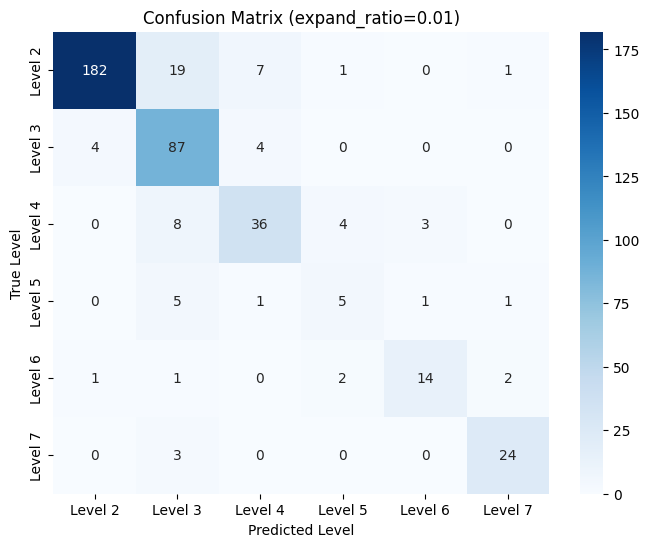


Classification Report:
              precision    recall  f1-score   support

     Level 2     0.9733    0.8667    0.9169       210
     Level 3     0.7073    0.9158    0.7982        95
     Level 4     0.7500    0.7059    0.7273        51
     Level 5     0.4167    0.3846    0.4000        13
     Level 6     0.7778    0.7000    0.7368        20
     Level 7     0.8571    0.8889    0.8727        27

    accuracy                         0.8365       416
   macro avg     0.7470    0.7436    0.7420       416
weighted avg     0.8508    0.8365    0.8388       416



In [ ]:
################################################################################
# Colab‐Cell: Train a Norwood‐Stage Classifier on “Cropped‐Interior” Images
# using EfficientNet-B0 with a single expand_ratio (e.g., 0.01), reading from
# combined “orig + CLAHE” folders for raw + segmented images.
#
# Now we assume:
#   • Combined segmented masks live under:
#       /content/combined_segmented_boundary/<split>/Level X/
#         ├── img001_boundary_orig.png
#         ├── img001_boundary_clahe.png
#         ├── img002_boundary_orig.png
#         ├── img002_boundary_clahe.png
#         └── …
#   • Combined raw images live under:
#       /content/combined_norwood_raw/<split>/Level X/
#         ├── img001_orig.jpg
#         ├── img001_clahe.jpg
#         ├── img002_orig.jpg
#         ├── img002_clahe.jpg
#         └── …
#
# The Dataset logic will:
#   - For each “*_boundary_*.png” in combined_segmented_boundary, extract the
#     prefix (e.g. “img001”) and the suffix (e.g. “_orig” or “_clahe”).
#   - Look up the matching raw image as prefix + suffix + “.jpg” in
#     combined_norwood_raw.
#   - Crop the raw image using the boundary mask after expanding by expand_ratio.
#
# Everything else—training loop, transforms, evaluation—remains unchanged.
#
# To change expand_ratio, just edit EXPAND_RATIO below.
#
# BEFORE RUNNING:
#   • Confirm the combined directories exist as described above.
#   • Use a GPU runtime: Runtime → Change runtime type → GPU.
################################################################################

# (0) Install & import dependencies
!pip install --quiet torch torchvision tqdm scikit-learn pandas seaborn matplotlib opencv-python efficientnet_pytorch

import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from tqdm import tqdm
from collections import Counter

# EfficientNet-B0
from efficientnet_pytorch import EfficientNet

# sklearn metrics
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

################################################################################
# (1) Custom Dataset: Use combined folders (orig + CLAHE). The “suffix” is either
# "_orig" or "_clahe" depending on the filename.
################################################################################

class NorwoodCroppedExpandedDataset(Dataset):
    def __init__(self,
                 raw_root: str,
                 boundary_root: str,
                 split: str,
                 level_names: list,
                 transform=None,
                 expand_ratio: float = 0.01):
        """
        raw_root:      "/content/combined_norwood_raw"
        boundary_root: "/content/combined_segmented_boundary"
        split:         one of "train", "valid", "test"
        level_names:   ["Level 2", "Level 3", ..., "Level 7"]
        transform:     torchvision transforms applied to each cropped image
        expand_ratio:  fraction of max(w, h) added around the hair bounding box
        """
        self.samples = []  # list of (raw_img_path, boundary_img_path, label_index)
        self.transform = transform
        self.expand_ratio = expand_ratio

        for idx, lvl in enumerate(level_names):
            raw_dir = os.path.join(raw_root, split, lvl)
            bnd_dir = os.path.join(boundary_root, split, lvl)

            if not os.path.isdir(raw_dir):
                raise FileNotFoundError(f"Raw folder not found: {raw_dir}")
            if not os.path.isdir(bnd_dir):
                raise FileNotFoundError(f"Boundary folder not found: {bnd_dir}")

            for fname in os.listdir(bnd_dir):
                # We expect boundary filenames like "img001_boundary_orig.png" or "img001_boundary_clahe.png"
                if "_boundary" not in fname.lower() or not fname.lower().endswith(".png"):
                    continue

                # Extract prefix and suffix from boundary filename
                name, ext = os.path.splitext(fname)  # e.g. name = "img001_boundary_orig"
                if "_boundary" not in name:
                    continue

                prefix, suffix = name.split("_boundary", 1)
                # suffix is either "_orig" or "_clahe"
                raw_fname = prefix + suffix + ".jpg"
                raw_path = os.path.join(raw_dir, raw_fname)
                bnd_path = os.path.join(bnd_dir, fname)

                if not os.path.isfile(raw_path):
                    raise FileNotFoundError(f"Raw image missing for boundary: {raw_path}")
                self.samples.append((raw_path, bnd_path, idx))

        if len(self.samples) == 0:
            raise ValueError(f"No samples found for split={split}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        raw_path, bnd_path, label = self.samples[index]

        # Load raw and boundary as RGB NumPy arrays
        raw_img = np.array(Image.open(raw_path).convert("RGB"))
        bnd_img = np.array(Image.open(bnd_path).convert("RGB"))
        H, W, _ = raw_img.shape

        # Create binary mask of red boundary via HSV threshold
        hsv = cv2.cvtColor(bnd_img, cv2.COLOR_RGB2HSV)
        lower1 = np.array([0, 100, 100]); upper1 = np.array([10, 255, 255])
        lower2 = np.array([160, 100, 100]); upper2 = np.array([180, 255, 255])
        mask1 = cv2.inRange(hsv, lower1, upper1)
        mask2 = cv2.inRange(hsv, lower2, upper2)
        red_boundary_mask = cv2.bitwise_or(mask1, mask2)

        # Find external contours on the red mask
        contours, _ = cv2.findContours(
            red_boundary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )

        if len(contours) == 0:
            # If no contour found, use full image
            x, y, w, h = 0, 0, W, H
        else:
            # Merge all contour points to compute a tight bounding box
            all_pts = np.vstack(contours).squeeze()
            xs, ys = all_pts[:, 0], all_pts[:, 1]
            x_min, x_max = xs.min(), xs.max()
            y_min, y_max = ys.min(), ys.max()
            x, y, w, h = int(x_min), int(y_min), int(x_max - x_min), int(y_max - y_min)

        # Expand bounding box by expand_ratio * max(w, h)
        margin = int(self.expand_ratio * max(w, h))
        x1 = max(0, x - margin)
        y1 = max(0, y - margin)
        x2 = min(W, x + w + margin)
        y2 = min(H, y + h + margin)

        # Crop raw image
        cropped = raw_img[y1:y2, x1:x2]
        if cropped.size == 0:
            cropped = raw_img.copy()

        # Convert to PIL and apply transforms
        cropped_pil = Image.fromarray(cropped)
        if self.transform:
            cropped_pil = self.transform(cropped_pil)

        return cropped_pil, label

################################################################################
# (2) Paths, Classes, and Transforms
################################################################################

# ────────────────────────────────────────────────────────────────────────────────
# Change these two roots to point at your combined folders:
# ────────────────────────────────────────────────────────────────────────────────

RAW_ROOT      = "/content/norwood_dataset_combined"
BOUNDARY_ROOT = "/content/segmented_boundary_clahe"

# We still expect the same “train/Level 2, train/Level 3… valid/… test/…” structure
SPLITS        = ["train", "valid", "test"]
LEVEL_NAMES   = [f"Level {i}" for i in range(2, 8)]  # ["Level 2", "Level 3", ..., "Level 7"]

# Verify folder structure once
for split in SPLITS:
    for lvl in LEVEL_NAMES:
        raw_dir = os.path.join(RAW_ROOT,  split, lvl)
        bnd_dir = os.path.join(BOUNDARY_ROOT, split, lvl)
        if not os.path.isdir(raw_dir):
            raise FileNotFoundError(f"Missing raw folder: {raw_dir}")
        if not os.path.isdir(bnd_dir):
            raise FileNotFoundError(f"Missing boundary folder: {bnd_dir}")
print("Verified combined raw + combined segmented folder structure.")

# Transforms: resize to 224×224, augment on train
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])
eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

################################################################################
# (3) Set expand_ratio and instantiate Datasets & DataLoaders (no loop)
################################################################################

# Change this value to experiment with a different expand_ratio:
EXPAND_RATIO = 0.01  # 1% of max(w, h)

print(f"\n▶ Running with expand_ratio = {EXPAND_RATIO:.2f}")

train_dataset = NorwoodCroppedExpandedDataset(
    raw_root=RAW_ROOT,
    boundary_root=BOUNDARY_ROOT,
    split="train",
    level_names=LEVEL_NAMES,
    transform=train_transform,
    expand_ratio=EXPAND_RATIO
)
valid_dataset = NorwoodCroppedExpandedDataset(
    raw_root=RAW_ROOT,
    boundary_root=BOUNDARY_ROOT,
    split="valid",
    level_names=LEVEL_NAMES,
    transform=eval_transform,
    expand_ratio=EXPAND_RATIO
)
test_dataset = NorwoodCroppedExpandedDataset(
    raw_root=RAW_ROOT,
    boundary_root=BOUNDARY_ROOT,
    split="test",
    level_names=LEVEL_NAMES,
    transform=eval_transform,
    expand_ratio=EXPAND_RATIO
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,
                          num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False,
                          num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False,
                          num_workers=2, pin_memory=True)

print(f"Train samples: {len(train_dataset)}")
print(f"Valid samples: {len(valid_dataset)}")
print(f"Test samples:  {len(test_dataset)}")

################################################################################
# (4) Build your classifier & move to GPU
################################################################################

import torchvision.models as models

# You can now set MODEL_NAME to one of:
# "efficientnet-b0", "efficientnet-b2",
# "mobilenet_v2", "mobilenet_v3_large",
# "resnet18", "resnet34", "resnet50",
# "resnext50_32x4d",
# "vgg16",
# "densenet121",
# "shufflenet_v2_x1_0",
# "convnext_tiny",
# "vit_b_16",
# "swin_tiny_patch4_window7_224",
# or "custom_cnn"

MODEL_NAME = "densenet121"   # ← change as desired

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if MODEL_NAME == "efficientnet-b0":
    from efficientnet_pytorch import EfficientNet
    model = EfficientNet.from_pretrained("efficientnet-b0")
    in_features = model._fc.in_features
    model._fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "efficientnet-b2":
    from efficientnet_pytorch import EfficientNet
    model = EfficientNet.from_pretrained("efficientnet-b2")
    in_features = model._fc.in_features
    model._fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "mobilenet_v2":
    model = models.mobilenet_v2(pretrained=True)
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "mobilenet_v3_large":
    model = models.mobilenet_v3_large(pretrained=True)
    in_features = model.classifier[3].in_features
    model.classifier[3] = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "resnet18":
    model = models.resnet18(pretrained=True)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "resnet34":
    model = models.resnet34(pretrained=True)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "resnet50":
    model = models.resnet50(pretrained=True)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "resnext50_32x4d":
    model = models.resnext50_32x4d(pretrained=True)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "vgg16":
    model = models.vgg16(pretrained=True)
    in_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "densenet121":
    model = models.densenet121(pretrained=True)
    in_features = model.classifier.in_features
    model.classifier = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "shufflenet_v2_x1_0":
    model = models.shufflenet_v2_x1_0(pretrained=True)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "convnext_tiny":
    model = models.convnext_tiny(pretrained=True)
    in_features = model.classifier[2].in_features
    model.classifier[2] = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "vit_b_16":
    model = models.vit_b_16(pretrained=True)
    in_features = model.heads.head.in_features
    model.heads.head = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "swin_tiny_patch4_window7_224":
    model = models.swin_t(pretrained=True)
    in_features = model.head.in_features
    model.head = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "custom_cnn":
    # Make sure you have defined CustomCNN somewhere above:
    # class CustomCNN(nn.Module):
    #     def __init__(self, num_classes): …
    #     def forward(self, x): …
    model = CustomCNN(num_classes=len(LEVEL_NAMES))

else:
    raise ValueError(f"Unknown MODEL_NAME: {MODEL_NAME}")

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

################################################################################
# (5) Training & validation loop (10 epochs)
################################################################################

num_epochs      = 10
best_valid_acc  = 0.0
best_checkpoint = "/content/best_efficientnetb0_single_ratio.pth"

for epoch in range(1, num_epochs + 1):
    # --- Training Phase ---
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_train = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} [Train]"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels).item()
        total_train += inputs.size(0)

    epoch_acc = running_corrects / total_train
    print(f"    [Epoch {epoch}] Train Acc: {epoch_acc:.4f}")

    # --- Validation Phase ---
    model.eval()
    val_corrects = 0
    total_valid = 0

    with torch.no_grad():
        for inputs, labels in tqdm(valid_loader, desc=f"Epoch {epoch}/{num_epochs} [Valid]"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels).item()
            total_valid += inputs.size(0)

    val_acc = val_corrects / total_valid
    print(f"    [Epoch {epoch}] Valid Acc: {val_acc:.4f}")

    # Save checkpoint if validation improves
    if val_acc > best_valid_acc:
        best_valid_acc = val_acc
        torch.save(model.state_dict(), best_checkpoint)
        print(f"      → New best valid acc: {best_valid_acc:.4f}. Saved to {best_checkpoint}")

################################################################################
# (6) Load best checkpoint and evaluate on test set
################################################################################

model.load_state_dict(torch.load(best_checkpoint))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

test_f1_macro = f1_score(all_labels, all_preds, average="macro")
test_acc = (np.array(all_preds) == np.array(all_labels)).mean()

print(f"\n▶ Final Test Accuracy: {test_acc*100:.2f}%  ({len(all_labels)} samples)")
print(f"▶ Final Test Macro F1: {test_f1_macro:.4f}")

# (Optional) Print confusion matrix and classification report
cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(LEVEL_NAMES))))
cm_df = pd.DataFrame(cm, index=LEVEL_NAMES, columns=LEVEL_NAMES)
print("\nConfusion Matrix:")
print(cm_df)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.ylabel("True Level")
plt.xlabel("Predicted Level")
plt.title(f"Confusion Matrix (expand_ratio={EXPAND_RATIO:.2f})")
plt.show()

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=LEVEL_NAMES, digits=4))



################################################################################
# End of script
################################################################################


In [ ]:
# # ───────────────────────────────────────────────────────────────────────────────
# # 7. Upload to Hugging Face
# # ───────────────────────────────────────────────────────────────────────────────
# # Make sure you've run the evaluation block so test_acc and test_f1_macro exist.

# import json  # not imported earlier
# from huggingface_hub import login, create_repo, upload_folder

# hf_username = "alamb98"  # <-- CHANGE THIS

# # Login to Hugging Face (only once per session). Will prompt for token in Colab.
# login()

# # Define repo ID as "<username>/<MODEL_NAME>"
# repo_id = f"{hf_username}/{MODEL_NAME}"

# # Create repo if it doesn't exist
# create_repo(repo_id, repo_type="model", exist_ok=True)

# # Save model weights (state_dict only)
# torch.save(model.state_dict(), f"{MODEL_NAME}.pth")

# # Save metadata
# metadata = {
#     "model_name": MODEL_NAME,
#     "expand_ratio": EXPAND_RATIO,
#     "image_size": [224, 224],
#     "labels": LEVEL_NAMES,
#     "test_accuracy": round(float(test_acc), 4),
#     "macro_f1_score": round(float(test_f1_macro), 4)
# }
# with open("metadata.json", "w") as f:
#     json.dump(metadata, f, indent=2)

# # Upload model and metadata files
# upload_folder(
#     folder_path=".",
#     repo_id=repo_id,
#     repo_type="model",
#     allow_patterns=[f"{MODEL_NAME}.pth", "metadata.json"]
# )

# print(f"\n✅ Model uploaded to: https://huggingface.co/{repo_id}")


Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...h-hair-segmentation/densenet121.pth:   0%|          | 75.8kB / 28.4MB            


✅ Model uploaded to: https://huggingface.co/alamb98/densenet121


shufflenet_v2_x1_0

In [ ]:
################################################################################
# Colab‐Cell: Train a Norwood‐Stage Classifier on “Cropped‐Interior” Images
# using EfficientNet-B0 with a single expand_ratio (e.g., 0.01), reading from
# combined “orig + CLAHE” folders for raw + segmented images.
#
# Now we assume:
#   • Combined segmented masks live under:
#       /content/combined_segmented_boundary/<split>/Level X/
#         ├── img001_boundary_orig.png
#         ├── img001_boundary_clahe.png
#         ├── img002_boundary_orig.png
#         ├── img002_boundary_clahe.png
#         └── …
#   • Combined raw images live under:
#       /content/combined_norwood_raw/<split>/Level X/
#         ├── img001_orig.jpg
#         ├── img001_clahe.jpg
#         ├── img002_orig.jpg
#         ├── img002_clahe.jpg
#         └── …
#
# The Dataset logic will:
#   - For each “*_boundary_*.png” in combined_segmented_boundary, extract the
#     prefix (e.g. “img001”) and the suffix (e.g. “_orig” or “_clahe”).
#   - Look up the matching raw image as prefix + suffix + “.jpg” in
#     combined_norwood_raw.
#   - Crop the raw image using the boundary mask after expanding by expand_ratio.
#
# Everything else—training loop, transforms, evaluation—remains unchanged.
#
# To change expand_ratio, just edit EXPAND_RATIO below.
#
# BEFORE RUNNING:
#   • Confirm the combined directories exist as described above.
#   • Use a GPU runtime: Runtime → Change runtime type → GPU.
################################################################################

# (0) Install & import dependencies
!pip install --quiet torch torchvision tqdm scikit-learn pandas seaborn matplotlib opencv-python efficientnet_pytorch

import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from tqdm import tqdm
from collections import Counter

# EfficientNet-B0
from efficientnet_pytorch import EfficientNet

# sklearn metrics
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

################################################################################
# (1) Custom Dataset: Use combined folders (orig + CLAHE). The “suffix” is either
# "_orig" or "_clahe" depending on the filename.
################################################################################

class NorwoodCroppedExpandedDataset(Dataset):
    def __init__(self,
                 raw_root: str,
                 boundary_root: str,
                 split: str,
                 level_names: list,
                 transform=None,
                 expand_ratio: float = 0.01):
        """
        raw_root:      "/content/combined_norwood_raw"
        boundary_root: "/content/combined_segmented_boundary"
        split:         one of "train", "valid", "test"
        level_names:   ["Level 2", "Level 3", ..., "Level 7"]
        transform:     torchvision transforms applied to each cropped image
        expand_ratio:  fraction of max(w, h) added around the hair bounding box
        """
        self.samples = []  # list of (raw_img_path, boundary_img_path, label_index)
        self.transform = transform
        self.expand_ratio = expand_ratio

        for idx, lvl in enumerate(level_names):
            raw_dir = os.path.join(raw_root, split, lvl)
            bnd_dir = os.path.join(boundary_root, split, lvl)

            if not os.path.isdir(raw_dir):
                raise FileNotFoundError(f"Raw folder not found: {raw_dir}")
            if not os.path.isdir(bnd_dir):
                raise FileNotFoundError(f"Boundary folder not found: {bnd_dir}")

            for fname in os.listdir(bnd_dir):
                # We expect boundary filenames like "img001_boundary_orig.png" or "img001_boundary_clahe.png"
                if "_boundary" not in fname.lower() or not fname.lower().endswith(".png"):
                    continue

                # Extract prefix and suffix from boundary filename
                name, ext = os.path.splitext(fname)  # e.g. name = "img001_boundary_orig"
                if "_boundary" not in name:
                    continue

                prefix, suffix = name.split("_boundary", 1)
                # suffix is either "_orig" or "_clahe"
                raw_fname = prefix + suffix + ".jpg"
                raw_path = os.path.join(raw_dir, raw_fname)
                bnd_path = os.path.join(bnd_dir, fname)

                if not os.path.isfile(raw_path):
                    raise FileNotFoundError(f"Raw image missing for boundary: {raw_path}")
                self.samples.append((raw_path, bnd_path, idx))

        if len(self.samples) == 0:
            raise ValueError(f"No samples found for split={split}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        raw_path, bnd_path, label = self.samples[index]

        # Load raw and boundary as RGB NumPy arrays
        raw_img = np.array(Image.open(raw_path).convert("RGB"))
        bnd_img = np.array(Image.open(bnd_path).convert("RGB"))
        H, W, _ = raw_img.shape

        # Create binary mask of red boundary via HSV threshold
        hsv = cv2.cvtColor(bnd_img, cv2.COLOR_RGB2HSV)
        lower1 = np.array([0, 100, 100]); upper1 = np.array([10, 255, 255])
        lower2 = np.array([160, 100, 100]); upper2 = np.array([180, 255, 255])
        mask1 = cv2.inRange(hsv, lower1, upper1)
        mask2 = cv2.inRange(hsv, lower2, upper2)
        red_boundary_mask = cv2.bitwise_or(mask1, mask2)

        # Find external contours on the red mask
        contours, _ = cv2.findContours(
            red_boundary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )

        if len(contours) == 0:
            # If no contour found, use full image
            x, y, w, h = 0, 0, W, H
        else:
            # Merge all contour points to compute a tight bounding box
            all_pts = np.vstack(contours).squeeze()
            xs, ys = all_pts[:, 0], all_pts[:, 1]
            x_min, x_max = xs.min(), xs.max()
            y_min, y_max = ys.min(), ys.max()
            x, y, w, h = int(x_min), int(y_min), int(x_max - x_min), int(y_max - y_min)

        # Expand bounding box by expand_ratio * max(w, h)
        margin = int(self.expand_ratio * max(w, h))
        x1 = max(0, x - margin)
        y1 = max(0, y - margin)
        x2 = min(W, x + w + margin)
        y2 = min(H, y + h + margin)

        # Crop raw image
        cropped = raw_img[y1:y2, x1:x2]
        if cropped.size == 0:
            cropped = raw_img.copy()

        # Convert to PIL and apply transforms
        cropped_pil = Image.fromarray(cropped)
        if self.transform:
            cropped_pil = self.transform(cropped_pil)

        return cropped_pil, label

################################################################################
# (2) Paths, Classes, and Transforms
################################################################################

# ────────────────────────────────────────────────────────────────────────────────
# Change these two roots to point at your combined folders:
# ────────────────────────────────────────────────────────────────────────────────

RAW_ROOT      = "/content/norwood_dataset_combined"
BOUNDARY_ROOT = "/content/segmented_boundary_clahe"

# We still expect the same “train/Level 2, train/Level 3… valid/… test/…” structure
SPLITS        = ["train", "valid", "test"]
LEVEL_NAMES   = [f"Level {i}" for i in range(2, 8)]  # ["Level 2", "Level 3", ..., "Level 7"]

# Verify folder structure once
for split in SPLITS:
    for lvl in LEVEL_NAMES:
        raw_dir = os.path.join(RAW_ROOT,  split, lvl)
        bnd_dir = os.path.join(BOUNDARY_ROOT, split, lvl)
        if not os.path.isdir(raw_dir):
            raise FileNotFoundError(f"Missing raw folder: {raw_dir}")
        if not os.path.isdir(bnd_dir):
            raise FileNotFoundError(f"Missing boundary folder: {bnd_dir}")
print("Verified combined raw + combined segmented folder structure.")

# Transforms: resize to 224×224, augment on train
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])
eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

################################################################################
# (3) Set expand_ratio and instantiate Datasets & DataLoaders (no loop)
################################################################################

# Change this value to experiment with a different expand_ratio:
EXPAND_RATIO = 0.01  # 1% of max(w, h)

print(f"\n▶ Running with expand_ratio = {EXPAND_RATIO:.2f}")

train_dataset = NorwoodCroppedExpandedDataset(
    raw_root=RAW_ROOT,
    boundary_root=BOUNDARY_ROOT,
    split="train",
    level_names=LEVEL_NAMES,
    transform=train_transform,
    expand_ratio=EXPAND_RATIO
)
valid_dataset = NorwoodCroppedExpandedDataset(
    raw_root=RAW_ROOT,
    boundary_root=BOUNDARY_ROOT,
    split="valid",
    level_names=LEVEL_NAMES,
    transform=eval_transform,
    expand_ratio=EXPAND_RATIO
)
test_dataset = NorwoodCroppedExpandedDataset(
    raw_root=RAW_ROOT,
    boundary_root=BOUNDARY_ROOT,
    split="test",
    level_names=LEVEL_NAMES,
    transform=eval_transform,
    expand_ratio=EXPAND_RATIO
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,
                          num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False,
                          num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False,
                          num_workers=2, pin_memory=True)

print(f"Train samples: {len(train_dataset)}")
print(f"Valid samples: {len(valid_dataset)}")
print(f"Test samples:  {len(test_dataset)}")

################################################################################
# (4) Build your classifier & move to GPU
################################################################################

import torchvision.models as models

# You can now set MODEL_NAME to one of:
# "efficientnet-b0", "efficientnet-b2",
# "mobilenet_v2", "mobilenet_v3_large",
# "resnet18", "resnet34", "resnet50",
# "resnext50_32x4d",
# "vgg16",
# "densenet121",
# "shufflenet_v2_x1_0",
# "convnext_tiny",
# "vit_b_16",
# "swin_tiny_patch4_window7_224",
# or "custom_cnn"

MODEL_NAME = "shufflenet_v2_x1_0"   # ← change as desired

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if MODEL_NAME == "efficientnet-b0":
    from efficientnet_pytorch import EfficientNet
    model = EfficientNet.from_pretrained("efficientnet-b0")
    in_features = model._fc.in_features
    model._fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "efficientnet-b2":
    from efficientnet_pytorch import EfficientNet
    model = EfficientNet.from_pretrained("efficientnet-b2")
    in_features = model._fc.in_features
    model._fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "mobilenet_v2":
    model = models.mobilenet_v2(pretrained=True)
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "mobilenet_v3_large":
    model = models.mobilenet_v3_large(pretrained=True)
    in_features = model.classifier[3].in_features
    model.classifier[3] = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "resnet18":
    model = models.resnet18(pretrained=True)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "resnet34":
    model = models.resnet34(pretrained=True)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "resnet50":
    model = models.resnet50(pretrained=True)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "resnext50_32x4d":
    model = models.resnext50_32x4d(pretrained=True)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "vgg16":
    model = models.vgg16(pretrained=True)
    in_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "densenet121":
    model = models.densenet121(pretrained=True)
    in_features = model.classifier.in_features
    model.classifier = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "shufflenet_v2_x1_0":
    model = models.shufflenet_v2_x1_0(pretrained=True)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "convnext_tiny":
    model = models.convnext_tiny(pretrained=True)
    in_features = model.classifier[2].in_features
    model.classifier[2] = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "vit_b_16":
    model = models.vit_b_16(pretrained=True)
    in_features = model.heads.head.in_features
    model.heads.head = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "swin_tiny_patch4_window7_224":
    model = models.swin_t(pretrained=True)
    in_features = model.head.in_features
    model.head = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "custom_cnn":
    # Make sure you have defined CustomCNN somewhere above:
    # class CustomCNN(nn.Module):
    #     def __init__(self, num_classes): …
    #     def forward(self, x): …
    model = CustomCNN(num_classes=len(LEVEL_NAMES))

else:
    raise ValueError(f"Unknown MODEL_NAME: {MODEL_NAME}")

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

################################################################################
# (5) Training & validation loop (10 epochs)
################################################################################

num_epochs      = 10
best_valid_acc  = 0.0
best_checkpoint = "/content/best_efficientnetb0_single_ratio.pth"

for epoch in range(1, num_epochs + 1):
    # --- Training Phase ---
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_train = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} [Train]"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels).item()
        total_train += inputs.size(0)

    epoch_acc = running_corrects / total_train
    print(f"    [Epoch {epoch}] Train Acc: {epoch_acc:.4f}")

    # --- Validation Phase ---
    model.eval()
    val_corrects = 0
    total_valid = 0

    with torch.no_grad():
        for inputs, labels in tqdm(valid_loader, desc=f"Epoch {epoch}/{num_epochs} [Valid]"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels).item()
            total_valid += inputs.size(0)

    val_acc = val_corrects / total_valid
    print(f"    [Epoch {epoch}] Valid Acc: {val_acc:.4f}")

    # Save checkpoint if validation improves
    if val_acc > best_valid_acc:
        best_valid_acc = val_acc
        torch.save(model.state_dict(), best_checkpoint)
        print(f"      → New best valid acc: {best_valid_acc:.4f}. Saved to {best_checkpoint}")

################################################################################
# (6) Load best checkpoint and evaluate on test set
################################################################################

model.load_state_dict(torch.load(best_checkpoint))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

test_f1_macro = f1_score(all_labels, all_preds, average="macro")
test_acc = (np.array(all_preds) == np.array(all_labels)).mean()

print(f"\n▶ Final Test Accuracy: {test_acc*100:.2f}%  ({len(all_labels)} samples)")
print(f"▶ Final Test Macro F1: {test_f1_macro:.4f}")

# (Optional) Print confusion matrix and classification report
cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(LEVEL_NAMES))))
cm_df = pd.DataFrame(cm, index=LEVEL_NAMES, columns=LEVEL_NAMES)
print("\nConfusion Matrix:")
print(cm_df)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.ylabel("True Level")
plt.xlabel("Predicted Level")
plt.title(f"Confusion Matrix (expand_ratio={EXPAND_RATIO:.2f})")
plt.show()

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=LEVEL_NAMES, digits=4))

################################################################################
# End of script
################################################################################


convnext_tiny

Verified combined raw + combined segmented folder structure.

▶ Running with expand_ratio = 0.01
Train samples: 9069
Valid samples: 895
Test samples:  416


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:00<00:00, 233MB/s] 
Epoch 1/10 [Train]: 100%|██████████| 284/284 [03:43<00:00,  1.27it/s]


    [Epoch 1] Train Acc: 0.7240


Epoch 1/10 [Valid]: 100%|██████████| 28/28 [00:05<00:00,  5.04it/s]


    [Epoch 1] Valid Acc: 0.7944
      → New best valid acc: 0.7944. Saved to /content/best_efficientnetb0_single_ratio.pth


Epoch 2/10 [Train]: 100%|██████████| 284/284 [03:43<00:00,  1.27it/s]


    [Epoch 2] Train Acc: 0.9145


Epoch 2/10 [Valid]: 100%|██████████| 28/28 [00:05<00:00,  5.07it/s]


    [Epoch 2] Valid Acc: 0.8402
      → New best valid acc: 0.8402. Saved to /content/best_efficientnetb0_single_ratio.pth


Epoch 3/10 [Train]: 100%|██████████| 284/284 [03:43<00:00,  1.27it/s]


    [Epoch 3] Train Acc: 0.9663


Epoch 3/10 [Valid]: 100%|██████████| 28/28 [00:05<00:00,  5.00it/s]


    [Epoch 3] Valid Acc: 0.8425
      → New best valid acc: 0.8425. Saved to /content/best_efficientnetb0_single_ratio.pth


Epoch 4/10 [Train]: 100%|██████████| 284/284 [03:44<00:00,  1.27it/s]


    [Epoch 4] Train Acc: 0.9789


Epoch 4/10 [Valid]: 100%|██████████| 28/28 [00:05<00:00,  5.02it/s]


    [Epoch 4] Valid Acc: 0.8547
      → New best valid acc: 0.8547. Saved to /content/best_efficientnetb0_single_ratio.pth


Epoch 5/10 [Train]: 100%|██████████| 284/284 [03:43<00:00,  1.27it/s]


    [Epoch 5] Train Acc: 0.9865


Epoch 5/10 [Valid]: 100%|██████████| 28/28 [00:05<00:00,  5.06it/s]


    [Epoch 5] Valid Acc: 0.8592
      → New best valid acc: 0.8592. Saved to /content/best_efficientnetb0_single_ratio.pth


Epoch 6/10 [Train]: 100%|██████████| 284/284 [03:43<00:00,  1.27it/s]


    [Epoch 6] Train Acc: 0.9816


Epoch 6/10 [Valid]: 100%|██████████| 28/28 [00:05<00:00,  4.95it/s]


    [Epoch 6] Valid Acc: 0.8536


Epoch 7/10 [Train]: 100%|██████████| 284/284 [03:42<00:00,  1.28it/s]


    [Epoch 7] Train Acc: 0.9881


Epoch 7/10 [Valid]: 100%|██████████| 28/28 [00:05<00:00,  5.10it/s]


    [Epoch 7] Valid Acc: 0.8570


Epoch 8/10 [Train]: 100%|██████████| 284/284 [03:43<00:00,  1.27it/s]


    [Epoch 8] Train Acc: 0.9819


Epoch 8/10 [Valid]: 100%|██████████| 28/28 [00:05<00:00,  5.05it/s]


    [Epoch 8] Valid Acc: 0.8480


Epoch 9/10 [Train]: 100%|██████████| 284/284 [03:42<00:00,  1.27it/s]


    [Epoch 9] Train Acc: 0.9861


Epoch 9/10 [Valid]: 100%|██████████| 28/28 [00:05<00:00,  5.04it/s]


    [Epoch 9] Valid Acc: 0.8480


Epoch 10/10 [Train]: 100%|██████████| 284/284 [03:43<00:00,  1.27it/s]


    [Epoch 10] Train Acc: 0.9854


Epoch 10/10 [Valid]: 100%|██████████| 28/28 [00:05<00:00,  5.08it/s]


    [Epoch 10] Valid Acc: 0.8603
      → New best valid acc: 0.8603. Saved to /content/best_efficientnetb0_single_ratio.pth


Testing: 100%|██████████| 13/13 [00:02<00:00,  4.58it/s]



▶ Final Test Accuracy: 85.82%  (416 samples)
▶ Final Test Macro F1: 0.7833

Confusion Matrix:
         Level 2  Level 3  Level 4  Level 5  Level 6  Level 7
Level 2      191       16        3        0        0        0
Level 3        9       82        4        0        0        0
Level 4        2        5       41        3        0        0
Level 5        0        2        2        7        2        0
Level 6        1        0        1        1       16        1
Level 7        0        0        3        1        3       20


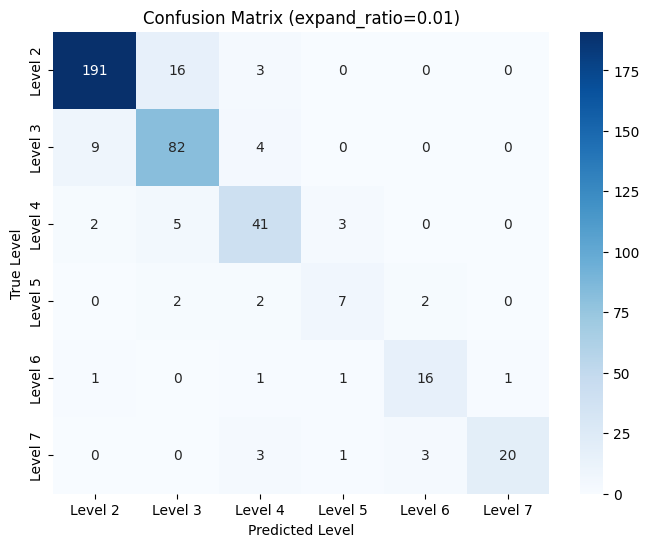


Classification Report:
              precision    recall  f1-score   support

     Level 2     0.9409    0.9095    0.9249       210
     Level 3     0.7810    0.8632    0.8200        95
     Level 4     0.7593    0.8039    0.7810        51
     Level 5     0.5833    0.5385    0.5600        13
     Level 6     0.7619    0.8000    0.7805        20
     Level 7     0.9524    0.7407    0.8333        27

    accuracy                         0.8582       416
   macro avg     0.7965    0.7760    0.7833       416
weighted avg     0.8631    0.8582    0.8590       416



In [ ]:
################################################################################
# Colab‐Cell: Train a Norwood‐Stage Classifier on “Cropped‐Interior” Images
# using EfficientNet-B0 with a single expand_ratio (e.g., 0.01), reading from
# combined “orig + CLAHE” folders for raw + segmented images.
#
# Now we assume:
#   • Combined segmented masks live under:
#       /content/combined_segmented_boundary/<split>/Level X/
#         ├── img001_boundary_orig.png
#         ├── img001_boundary_clahe.png
#         ├── img002_boundary_orig.png
#         ├── img002_boundary_clahe.png
#         └── …
#   • Combined raw images live under:
#       /content/combined_norwood_raw/<split>/Level X/
#         ├── img001_orig.jpg
#         ├── img001_clahe.jpg
#         ├── img002_orig.jpg
#         ├── img002_clahe.jpg
#         └── …
#
# The Dataset logic will:
#   - For each “*_boundary_*.png” in combined_segmented_boundary, extract the
#     prefix (e.g. “img001”) and the suffix (e.g. “_orig” or “_clahe”).
#   - Look up the matching raw image as prefix + suffix + “.jpg” in
#     combined_norwood_raw.
#   - Crop the raw image using the boundary mask after expanding by expand_ratio.
#
# Everything else—training loop, transforms, evaluation—remains unchanged.
#
# To change expand_ratio, just edit EXPAND_RATIO below.
#
# BEFORE RUNNING:
#   • Confirm the combined directories exist as described above.
#   • Use a GPU runtime: Runtime → Change runtime type → GPU.
################################################################################

# (0) Install & import dependencies
!pip install --quiet torch torchvision tqdm scikit-learn pandas seaborn matplotlib opencv-python efficientnet_pytorch

import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from tqdm import tqdm
from collections import Counter

# EfficientNet-B0
from efficientnet_pytorch import EfficientNet

# sklearn metrics
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

################################################################################
# (1) Custom Dataset: Use combined folders (orig + CLAHE). The “suffix” is either
# "_orig" or "_clahe" depending on the filename.
################################################################################

class NorwoodCroppedExpandedDataset(Dataset):
    def __init__(self,
                 raw_root: str,
                 boundary_root: str,
                 split: str,
                 level_names: list,
                 transform=None,
                 expand_ratio: float = 0.01):
        """
        raw_root:      "/content/combined_norwood_raw"
        boundary_root: "/content/combined_segmented_boundary"
        split:         one of "train", "valid", "test"
        level_names:   ["Level 2", "Level 3", ..., "Level 7"]
        transform:     torchvision transforms applied to each cropped image
        expand_ratio:  fraction of max(w, h) added around the hair bounding box
        """
        self.samples = []  # list of (raw_img_path, boundary_img_path, label_index)
        self.transform = transform
        self.expand_ratio = expand_ratio

        for idx, lvl in enumerate(level_names):
            raw_dir = os.path.join(raw_root, split, lvl)
            bnd_dir = os.path.join(boundary_root, split, lvl)

            if not os.path.isdir(raw_dir):
                raise FileNotFoundError(f"Raw folder not found: {raw_dir}")
            if not os.path.isdir(bnd_dir):
                raise FileNotFoundError(f"Boundary folder not found: {bnd_dir}")

            for fname in os.listdir(bnd_dir):
                # We expect boundary filenames like "img001_boundary_orig.png" or "img001_boundary_clahe.png"
                if "_boundary" not in fname.lower() or not fname.lower().endswith(".png"):
                    continue

                # Extract prefix and suffix from boundary filename
                name, ext = os.path.splitext(fname)  # e.g. name = "img001_boundary_orig"
                if "_boundary" not in name:
                    continue

                prefix, suffix = name.split("_boundary", 1)
                # suffix is either "_orig" or "_clahe"
                raw_fname = prefix + suffix + ".jpg"
                raw_path = os.path.join(raw_dir, raw_fname)
                bnd_path = os.path.join(bnd_dir, fname)

                if not os.path.isfile(raw_path):
                    raise FileNotFoundError(f"Raw image missing for boundary: {raw_path}")
                self.samples.append((raw_path, bnd_path, idx))

        if len(self.samples) == 0:
            raise ValueError(f"No samples found for split={split}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        raw_path, bnd_path, label = self.samples[index]

        # Load raw and boundary as RGB NumPy arrays
        raw_img = np.array(Image.open(raw_path).convert("RGB"))
        bnd_img = np.array(Image.open(bnd_path).convert("RGB"))
        H, W, _ = raw_img.shape

        # Create binary mask of red boundary via HSV threshold
        hsv = cv2.cvtColor(bnd_img, cv2.COLOR_RGB2HSV)
        lower1 = np.array([0, 100, 100]); upper1 = np.array([10, 255, 255])
        lower2 = np.array([160, 100, 100]); upper2 = np.array([180, 255, 255])
        mask1 = cv2.inRange(hsv, lower1, upper1)
        mask2 = cv2.inRange(hsv, lower2, upper2)
        red_boundary_mask = cv2.bitwise_or(mask1, mask2)

        # Find external contours on the red mask
        contours, _ = cv2.findContours(
            red_boundary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )

        if len(contours) == 0:
            # If no contour found, use full image
            x, y, w, h = 0, 0, W, H
        else:
            # Merge all contour points to compute a tight bounding box
            all_pts = np.vstack(contours).squeeze()
            xs, ys = all_pts[:, 0], all_pts[:, 1]
            x_min, x_max = xs.min(), xs.max()
            y_min, y_max = ys.min(), ys.max()
            x, y, w, h = int(x_min), int(y_min), int(x_max - x_min), int(y_max - y_min)

        # Expand bounding box by expand_ratio * max(w, h)
        margin = int(self.expand_ratio * max(w, h))
        x1 = max(0, x - margin)
        y1 = max(0, y - margin)
        x2 = min(W, x + w + margin)
        y2 = min(H, y + h + margin)

        # Crop raw image
        cropped = raw_img[y1:y2, x1:x2]
        if cropped.size == 0:
            cropped = raw_img.copy()

        # Convert to PIL and apply transforms
        cropped_pil = Image.fromarray(cropped)
        if self.transform:
            cropped_pil = self.transform(cropped_pil)

        return cropped_pil, label

################################################################################
# (2) Paths, Classes, and Transforms
################################################################################

# ────────────────────────────────────────────────────────────────────────────────
# Change these two roots to point at your combined folders:
# ────────────────────────────────────────────────────────────────────────────────

RAW_ROOT      = "/content/norwood_dataset_combined"
BOUNDARY_ROOT = "/content/segmented_boundary_clahe"

# We still expect the same “train/Level 2, train/Level 3… valid/… test/…” structure
SPLITS        = ["train", "valid", "test"]
LEVEL_NAMES   = [f"Level {i}" for i in range(2, 8)]  # ["Level 2", "Level 3", ..., "Level 7"]

# Verify folder structure once
for split in SPLITS:
    for lvl in LEVEL_NAMES:
        raw_dir = os.path.join(RAW_ROOT,  split, lvl)
        bnd_dir = os.path.join(BOUNDARY_ROOT, split, lvl)
        if not os.path.isdir(raw_dir):
            raise FileNotFoundError(f"Missing raw folder: {raw_dir}")
        if not os.path.isdir(bnd_dir):
            raise FileNotFoundError(f"Missing boundary folder: {bnd_dir}")
print("Verified combined raw + combined segmented folder structure.")

# Transforms: resize to 224×224, augment on train
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])
eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

################################################################################
# (3) Set expand_ratio and instantiate Datasets & DataLoaders (no loop)
################################################################################

# Change this value to experiment with a different expand_ratio:
EXPAND_RATIO = 0.01  # 1% of max(w, h)

print(f"\n▶ Running with expand_ratio = {EXPAND_RATIO:.2f}")

train_dataset = NorwoodCroppedExpandedDataset(
    raw_root=RAW_ROOT,
    boundary_root=BOUNDARY_ROOT,
    split="train",
    level_names=LEVEL_NAMES,
    transform=train_transform,
    expand_ratio=EXPAND_RATIO
)
valid_dataset = NorwoodCroppedExpandedDataset(
    raw_root=RAW_ROOT,
    boundary_root=BOUNDARY_ROOT,
    split="valid",
    level_names=LEVEL_NAMES,
    transform=eval_transform,
    expand_ratio=EXPAND_RATIO
)
test_dataset = NorwoodCroppedExpandedDataset(
    raw_root=RAW_ROOT,
    boundary_root=BOUNDARY_ROOT,
    split="test",
    level_names=LEVEL_NAMES,
    transform=eval_transform,
    expand_ratio=EXPAND_RATIO
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,
                          num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False,
                          num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False,
                          num_workers=2, pin_memory=True)

print(f"Train samples: {len(train_dataset)}")
print(f"Valid samples: {len(valid_dataset)}")
print(f"Test samples:  {len(test_dataset)}")

################################################################################
# (4) Build your classifier & move to GPU
################################################################################

import torchvision.models as models

# You can now set MODEL_NAME to one of:
# "efficientnet-b0", "efficientnet-b2",
# "mobilenet_v2", "mobilenet_v3_large",
# "resnet18", "resnet34", "resnet50",
# "resnext50_32x4d",
# "vgg16",
# "densenet121",
# "shufflenet_v2_x1_0",
# "convnext_tiny",
# "vit_b_16",
# "swin_tiny_patch4_window7_224",
# or "custom_cnn"

MODEL_NAME = "convnext_tiny"   # ← change as desired

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if MODEL_NAME == "efficientnet-b0":
    from efficientnet_pytorch import EfficientNet
    model = EfficientNet.from_pretrained("efficientnet-b0")
    in_features = model._fc.in_features
    model._fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "efficientnet-b2":
    from efficientnet_pytorch import EfficientNet
    model = EfficientNet.from_pretrained("efficientnet-b2")
    in_features = model._fc.in_features
    model._fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "mobilenet_v2":
    model = models.mobilenet_v2(pretrained=True)
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "mobilenet_v3_large":
    model = models.mobilenet_v3_large(pretrained=True)
    in_features = model.classifier[3].in_features
    model.classifier[3] = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "resnet18":
    model = models.resnet18(pretrained=True)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "resnet34":
    model = models.resnet34(pretrained=True)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "resnet50":
    model = models.resnet50(pretrained=True)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "resnext50_32x4d":
    model = models.resnext50_32x4d(pretrained=True)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "vgg16":
    model = models.vgg16(pretrained=True)
    in_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "densenet121":
    model = models.densenet121(pretrained=True)
    in_features = model.classifier.in_features
    model.classifier = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "shufflenet_v2_x1_0":
    model = models.shufflenet_v2_x1_0(pretrained=True)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "convnext_tiny":
    model = models.convnext_tiny(pretrained=True)
    in_features = model.classifier[2].in_features
    model.classifier[2] = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "vit_b_16":
    model = models.vit_b_16(pretrained=True)
    in_features = model.heads.head.in_features
    model.heads.head = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "swin_tiny_patch4_window7_224":
    model = models.swin_t(pretrained=True)
    in_features = model.head.in_features
    model.head = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "custom_cnn":
    # Make sure you have defined CustomCNN somewhere above:
    # class CustomCNN(nn.Module):
    #     def __init__(self, num_classes): …
    #     def forward(self, x): …
    model = CustomCNN(num_classes=len(LEVEL_NAMES))

else:
    raise ValueError(f"Unknown MODEL_NAME: {MODEL_NAME}")

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

################################################################################
# (5) Training & validation loop (10 epochs)
################################################################################

num_epochs      = 10
best_valid_acc  = 0.0
best_checkpoint = "/content/best_efficientnetb0_single_ratio.pth"

for epoch in range(1, num_epochs + 1):
    # --- Training Phase ---
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_train = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} [Train]"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels).item()
        total_train += inputs.size(0)

    epoch_acc = running_corrects / total_train
    print(f"    [Epoch {epoch}] Train Acc: {epoch_acc:.4f}")

    # --- Validation Phase ---
    model.eval()
    val_corrects = 0
    total_valid = 0

    with torch.no_grad():
        for inputs, labels in tqdm(valid_loader, desc=f"Epoch {epoch}/{num_epochs} [Valid]"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels).item()
            total_valid += inputs.size(0)

    val_acc = val_corrects / total_valid
    print(f"    [Epoch {epoch}] Valid Acc: {val_acc:.4f}")

    # Save checkpoint if validation improves
    if val_acc > best_valid_acc:
        best_valid_acc = val_acc
        torch.save(model.state_dict(), best_checkpoint)
        print(f"      → New best valid acc: {best_valid_acc:.4f}. Saved to {best_checkpoint}")

################################################################################
# (6) Load best checkpoint and evaluate on test set
################################################################################

model.load_state_dict(torch.load(best_checkpoint))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

test_f1_macro = f1_score(all_labels, all_preds, average="macro")
test_acc = (np.array(all_preds) == np.array(all_labels)).mean()

print(f"\n▶ Final Test Accuracy: {test_acc*100:.2f}%  ({len(all_labels)} samples)")
print(f"▶ Final Test Macro F1: {test_f1_macro:.4f}")

# (Optional) Print confusion matrix and classification report
cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(LEVEL_NAMES))))
cm_df = pd.DataFrame(cm, index=LEVEL_NAMES, columns=LEVEL_NAMES)
print("\nConfusion Matrix:")
print(cm_df)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.ylabel("True Level")
plt.xlabel("Predicted Level")
plt.title(f"Confusion Matrix (expand_ratio={EXPAND_RATIO:.2f})")
plt.show()

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=LEVEL_NAMES, digits=4))

################################################################################
# End of script
################################################################################

# ───────────────────────────────────────────────────────────────────────────────
# Upload trained model checkpoint and metadata to Hugging Face
# ───────────────────────────────────────────────────────────────────────────────

!pip install --quiet huggingface_hub

from huggingface_hub import login, create_repo, upload_folder
import json
import torch

# (A) Login with your token (only once per session)
login()  # Paste your Hugging Face token when prompted

# (B) Set repo name (adjust if needed)
hf_username = "alamb98"  # 🔁 Your HF username
repo_id = f"{hf_username}/{MODEL_NAME}_clahe_norwood_classifier"

# (C) Create or use existing repo
create_repo(repo_id, repo_type="model", exist_ok=True)

# (D) Save model checkpoint and metadata
model_path = f"{MODEL_NAME}_clahe_best.pth"
torch.save(model.state_dict(), model_path)

metadata = {
    "model_name": MODEL_NAME,
    "expand_ratio": EXPAND_RATIO,
    "num_classes": len(LEVEL_NAMES),
    "class_names": LEVEL_NAMES,
    "test_accuracy": round(float(test_acc), 4),
    "macro_f1_score": round(float(test_f1_macro), 4),
    "architecture": "torchvision.models",
    "framework": "PyTorch",
    "trained_on": "combined raw + CLAHE + segmented scalp images",
    "description": "ConvNeXt-Tiny classifier for male pattern baldness (Norwood stages 2–7)"
}
with open("metadata.json", "w") as f:
    json.dump(metadata, f, indent=2)

# (E) Upload both model and metadata.json
upload_folder(
    folder_path=".",
    repo_id=repo_id,
    repo_type="model",
    allow_patterns=[model_path, "metadata.json"]
)

print(f"\n✅ Uploaded to: https://huggingface.co/{repo_id}")


In [ ]:
# ───────────────────────────────────────────────────────────────────────────────
# Upload trained model checkpoint and metadata to Hugging Face
# ───────────────────────────────────────────────────────────────────────────────

!pip install --quiet huggingface_hub

from huggingface_hub import login, create_repo, upload_folder
import json
import torch

# (A) Login with your token (only once per session)
login()  # Paste your Hugging Face token when prompted

# (B) Set repo name (adjust if needed)
hf_username = "alamb98"  # 🔁 Your HF username
repo_id = f"{hf_username}/{MODEL_NAME}_clahe_norwood_classifier"

# (C) Create or use existing repo
create_repo(repo_id, repo_type="model", exist_ok=True)

# (D) Save model checkpoint and metadata
model_path = f"{MODEL_NAME}_clahe_best.pth"
torch.save(model.state_dict(), model_path)

metadata = {
    "model_name": MODEL_NAME,
    "expand_ratio": EXPAND_RATIO,
    "num_classes": len(LEVEL_NAMES),
    "class_names": LEVEL_NAMES,
    "test_accuracy": round(float(test_acc), 4),
    "macro_f1_score": round(float(test_f1_macro), 4),
    "architecture": "torchvision.models",
    "framework": "PyTorch",
    "trained_on": "combined raw + CLAHE + segmented scalp images",
    "description": "ConvNeXt-Tiny classifier for male pattern baldness (Norwood stages 2–7)"
}
with open("metadata.json", "w") as f:
    json.dump(metadata, f, indent=2)

# (E) Upload both model and metadata.json
upload_folder(
    folder_path=".",
    repo_id=repo_id,
    repo_type="model",
    allow_patterns=[model_path, "metadata.json"]
)

print(f"\n✅ Uploaded to: https://huggingface.co/{repo_id}")


Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...tation/convnext_tiny_clahe_best.pth:   0%|          |  556kB /  111MB            


✅ Uploaded to: https://huggingface.co/alamb98/convnext_tiny_clahe_norwood_classifier


vit_b_16

In [ ]:
################################################################################
# Colab‐Cell: Train a Norwood‐Stage Classifier on “Cropped‐Interior” Images
# using EfficientNet-B0 with a single expand_ratio (e.g., 0.01), reading from
# combined “orig + CLAHE” folders for raw + segmented images.
#
# Now we assume:
#   • Combined segmented masks live under:
#       /content/combined_segmented_boundary/<split>/Level X/
#         ├── img001_boundary_orig.png
#         ├── img001_boundary_clahe.png
#         ├── img002_boundary_orig.png
#         ├── img002_boundary_clahe.png
#         └── …
#   • Combined raw images live under:
#       /content/combined_norwood_raw/<split>/Level X/
#         ├── img001_orig.jpg
#         ├── img001_clahe.jpg
#         ├── img002_orig.jpg
#         ├── img002_clahe.jpg
#         └── …
#
# The Dataset logic will:
#   - For each “*_boundary_*.png” in combined_segmented_boundary, extract the
#     prefix (e.g. “img001”) and the suffix (e.g. “_orig” or “_clahe”).
#   - Look up the matching raw image as prefix + suffix + “.jpg” in
#     combined_norwood_raw.
#   - Crop the raw image using the boundary mask after expanding by expand_ratio.
#
# Everything else—training loop, transforms, evaluation—remains unchanged.
#
# To change expand_ratio, just edit EXPAND_RATIO below.
#
# BEFORE RUNNING:
#   • Confirm the combined directories exist as described above.
#   • Use a GPU runtime: Runtime → Change runtime type → GPU.
################################################################################

# (0) Install & import dependencies
!pip install --quiet torch torchvision tqdm scikit-learn pandas seaborn matplotlib opencv-python efficientnet_pytorch

import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from tqdm import tqdm
from collections import Counter

# EfficientNet-B0
from efficientnet_pytorch import EfficientNet

# sklearn metrics
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

################################################################################
# (1) Custom Dataset: Use combined folders (orig + CLAHE). The “suffix” is either
# "_orig" or "_clahe" depending on the filename.
################################################################################

class NorwoodCroppedExpandedDataset(Dataset):
    def __init__(self,
                 raw_root: str,
                 boundary_root: str,
                 split: str,
                 level_names: list,
                 transform=None,
                 expand_ratio: float = 0.01):
        """
        raw_root:      "/content/combined_norwood_raw"
        boundary_root: "/content/combined_segmented_boundary"
        split:         one of "train", "valid", "test"
        level_names:   ["Level 2", "Level 3", ..., "Level 7"]
        transform:     torchvision transforms applied to each cropped image
        expand_ratio:  fraction of max(w, h) added around the hair bounding box
        """
        self.samples = []  # list of (raw_img_path, boundary_img_path, label_index)
        self.transform = transform
        self.expand_ratio = expand_ratio

        for idx, lvl in enumerate(level_names):
            raw_dir = os.path.join(raw_root, split, lvl)
            bnd_dir = os.path.join(boundary_root, split, lvl)

            if not os.path.isdir(raw_dir):
                raise FileNotFoundError(f"Raw folder not found: {raw_dir}")
            if not os.path.isdir(bnd_dir):
                raise FileNotFoundError(f"Boundary folder not found: {bnd_dir}")

            for fname in os.listdir(bnd_dir):
                # We expect boundary filenames like "img001_boundary_orig.png" or "img001_boundary_clahe.png"
                if "_boundary" not in fname.lower() or not fname.lower().endswith(".png"):
                    continue

                # Extract prefix and suffix from boundary filename
                name, ext = os.path.splitext(fname)  # e.g. name = "img001_boundary_orig"
                if "_boundary" not in name:
                    continue

                prefix, suffix = name.split("_boundary", 1)
                # suffix is either "_orig" or "_clahe"
                raw_fname = prefix + suffix + ".jpg"
                raw_path = os.path.join(raw_dir, raw_fname)
                bnd_path = os.path.join(bnd_dir, fname)

                if not os.path.isfile(raw_path):
                    raise FileNotFoundError(f"Raw image missing for boundary: {raw_path}")
                self.samples.append((raw_path, bnd_path, idx))

        if len(self.samples) == 0:
            raise ValueError(f"No samples found for split={split}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        raw_path, bnd_path, label = self.samples[index]

        # Load raw and boundary as RGB NumPy arrays
        raw_img = np.array(Image.open(raw_path).convert("RGB"))
        bnd_img = np.array(Image.open(bnd_path).convert("RGB"))
        H, W, _ = raw_img.shape

        # Create binary mask of red boundary via HSV threshold
        hsv = cv2.cvtColor(bnd_img, cv2.COLOR_RGB2HSV)
        lower1 = np.array([0, 100, 100]); upper1 = np.array([10, 255, 255])
        lower2 = np.array([160, 100, 100]); upper2 = np.array([180, 255, 255])
        mask1 = cv2.inRange(hsv, lower1, upper1)
        mask2 = cv2.inRange(hsv, lower2, upper2)
        red_boundary_mask = cv2.bitwise_or(mask1, mask2)

        # Find external contours on the red mask
        contours, _ = cv2.findContours(
            red_boundary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )

        if len(contours) == 0:
            # If no contour found, use full image
            x, y, w, h = 0, 0, W, H
        else:
            # Merge all contour points to compute a tight bounding box
            all_pts = np.vstack(contours).squeeze()
            xs, ys = all_pts[:, 0], all_pts[:, 1]
            x_min, x_max = xs.min(), xs.max()
            y_min, y_max = ys.min(), ys.max()
            x, y, w, h = int(x_min), int(y_min), int(x_max - x_min), int(y_max - y_min)

        # Expand bounding box by expand_ratio * max(w, h)
        margin = int(self.expand_ratio * max(w, h))
        x1 = max(0, x - margin)
        y1 = max(0, y - margin)
        x2 = min(W, x + w + margin)
        y2 = min(H, y + h + margin)

        # Crop raw image
        cropped = raw_img[y1:y2, x1:x2]
        if cropped.size == 0:
            cropped = raw_img.copy()

        # Convert to PIL and apply transforms
        cropped_pil = Image.fromarray(cropped)
        if self.transform:
            cropped_pil = self.transform(cropped_pil)

        return cropped_pil, label

################################################################################
# (2) Paths, Classes, and Transforms
################################################################################

# ────────────────────────────────────────────────────────────────────────────────
# Change these two roots to point at your combined folders:
# ────────────────────────────────────────────────────────────────────────────────

RAW_ROOT      = "/content/norwood_dataset_combined"
BOUNDARY_ROOT = "/content/segmented_boundary_clahe"

# We still expect the same “train/Level 2, train/Level 3… valid/… test/…” structure
SPLITS        = ["train", "valid", "test"]
LEVEL_NAMES   = [f"Level {i}" for i in range(2, 8)]  # ["Level 2", "Level 3", ..., "Level 7"]

# Verify folder structure once
for split in SPLITS:
    for lvl in LEVEL_NAMES:
        raw_dir = os.path.join(RAW_ROOT,  split, lvl)
        bnd_dir = os.path.join(BOUNDARY_ROOT, split, lvl)
        if not os.path.isdir(raw_dir):
            raise FileNotFoundError(f"Missing raw folder: {raw_dir}")
        if not os.path.isdir(bnd_dir):
            raise FileNotFoundError(f"Missing boundary folder: {bnd_dir}")
print("Verified combined raw + combined segmented folder structure.")

# Transforms: resize to 224×224, augment on train
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])
eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

################################################################################
# (3) Set expand_ratio and instantiate Datasets & DataLoaders (no loop)
################################################################################

# Change this value to experiment with a different expand_ratio:
EXPAND_RATIO = 0.01  # 1% of max(w, h)

print(f"\n▶ Running with expand_ratio = {EXPAND_RATIO:.2f}")

train_dataset = NorwoodCroppedExpandedDataset(
    raw_root=RAW_ROOT,
    boundary_root=BOUNDARY_ROOT,
    split="train",
    level_names=LEVEL_NAMES,
    transform=train_transform,
    expand_ratio=EXPAND_RATIO
)
valid_dataset = NorwoodCroppedExpandedDataset(
    raw_root=RAW_ROOT,
    boundary_root=BOUNDARY_ROOT,
    split="valid",
    level_names=LEVEL_NAMES,
    transform=eval_transform,
    expand_ratio=EXPAND_RATIO
)
test_dataset = NorwoodCroppedExpandedDataset(
    raw_root=RAW_ROOT,
    boundary_root=BOUNDARY_ROOT,
    split="test",
    level_names=LEVEL_NAMES,
    transform=eval_transform,
    expand_ratio=EXPAND_RATIO
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,
                          num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False,
                          num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False,
                          num_workers=2, pin_memory=True)

print(f"Train samples: {len(train_dataset)}")
print(f"Valid samples: {len(valid_dataset)}")
print(f"Test samples:  {len(test_dataset)}")

################################################################################
# (4) Build your classifier & move to GPU
################################################################################

import torchvision.models as models

# You can now set MODEL_NAME to one of:
# "efficientnet-b0", "efficientnet-b2",
# "mobilenet_v2", "mobilenet_v3_large",
# "resnet18", "resnet34", "resnet50",
# "resnext50_32x4d",
# "vgg16",
# "densenet121",
# "shufflenet_v2_x1_0",
# "convnext_tiny",
# "vit_b_16",
# "swin_tiny_patch4_window7_224",
# or "custom_cnn"

MODEL_NAME = "vit_b_16"   # ← change as desired

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if MODEL_NAME == "efficientnet-b0":
    from efficientnet_pytorch import EfficientNet
    model = EfficientNet.from_pretrained("efficientnet-b0")
    in_features = model._fc.in_features
    model._fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "efficientnet-b2":
    from efficientnet_pytorch import EfficientNet
    model = EfficientNet.from_pretrained("efficientnet-b2")
    in_features = model._fc.in_features
    model._fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "mobilenet_v2":
    model = models.mobilenet_v2(pretrained=True)
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "mobilenet_v3_large":
    model = models.mobilenet_v3_large(pretrained=True)
    in_features = model.classifier[3].in_features
    model.classifier[3] = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "resnet18":
    model = models.resnet18(pretrained=True)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "resnet34":
    model = models.resnet34(pretrained=True)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "resnet50":
    model = models.resnet50(pretrained=True)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "resnext50_32x4d":
    model = models.resnext50_32x4d(pretrained=True)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "vgg16":
    model = models.vgg16(pretrained=True)
    in_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "densenet121":
    model = models.densenet121(pretrained=True)
    in_features = model.classifier.in_features
    model.classifier = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "shufflenet_v2_x1_0":
    model = models.shufflenet_v2_x1_0(pretrained=True)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "convnext_tiny":
    model = models.convnext_tiny(pretrained=True)
    in_features = model.classifier[2].in_features
    model.classifier[2] = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "vit_b_16":
    model = models.vit_b_16(pretrained=True)
    in_features = model.heads.head.in_features
    model.heads.head = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "swin_tiny_patch4_window7_224":
    model = models.swin_t(pretrained=True)
    in_features = model.head.in_features
    model.head = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "custom_cnn":
    # Make sure you have defined CustomCNN somewhere above:
    # class CustomCNN(nn.Module):
    #     def __init__(self, num_classes): …
    #     def forward(self, x): …
    model = CustomCNN(num_classes=len(LEVEL_NAMES))

else:
    raise ValueError(f"Unknown MODEL_NAME: {MODEL_NAME}")

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

################################################################################
# (5) Training & validation loop (10 epochs)
################################################################################

num_epochs      = 10
best_valid_acc  = 0.0
best_checkpoint = "/content/best_efficientnetb0_single_ratio.pth"

for epoch in range(1, num_epochs + 1):
    # --- Training Phase ---
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_train = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} [Train]"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels).item()
        total_train += inputs.size(0)

    epoch_acc = running_corrects / total_train
    print(f"    [Epoch {epoch}] Train Acc: {epoch_acc:.4f}")

    # --- Validation Phase ---
    model.eval()
    val_corrects = 0
    total_valid = 0

    with torch.no_grad():
        for inputs, labels in tqdm(valid_loader, desc=f"Epoch {epoch}/{num_epochs} [Valid]"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels).item()
            total_valid += inputs.size(0)

    val_acc = val_corrects / total_valid
    print(f"    [Epoch {epoch}] Valid Acc: {val_acc:.4f}")

    # Save checkpoint if validation improves
    if val_acc > best_valid_acc:
        best_valid_acc = val_acc
        torch.save(model.state_dict(), best_checkpoint)
        print(f"      → New best valid acc: {best_valid_acc:.4f}. Saved to {best_checkpoint}")

################################################################################
# (6) Load best checkpoint and evaluate on test set
################################################################################

model.load_state_dict(torch.load(best_checkpoint))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

test_f1_macro = f1_score(all_labels, all_preds, average="macro")
test_acc = (np.array(all_preds) == np.array(all_labels)).mean()

print(f"\n▶ Final Test Accuracy: {test_acc*100:.2f}%  ({len(all_labels)} samples)")
print(f"▶ Final Test Macro F1: {test_f1_macro:.4f}")

# (Optional) Print confusion matrix and classification report
cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(LEVEL_NAMES))))
cm_df = pd.DataFrame(cm, index=LEVEL_NAMES, columns=LEVEL_NAMES)
print("\nConfusion Matrix:")
print(cm_df)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.ylabel("True Level"x
plt.xlabel("Predicted Level")
plt.title(f"Confusion Matrix (expand_ratio={EXPAND_RATIO:.2f})")
plt.show()

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=LEVEL_NAMES, digits=4))

################################################################################
# End of script
################################################################################


swin_tiny_patch4_window7_224

In [ ]:
################################################################################
# Colab‐Cell: Train a Norwood‐Stage Classifier on “Cropped‐Interior” Images
# using EfficientNet-B0 with a single expand_ratio (e.g., 0.01), reading from
# combined “orig + CLAHE” folders for raw + segmented images.
#
# Now we assume:
#   • Combined segmented masks live under:
#       /content/combined_segmented_boundary/<split>/Level X/
#         ├── img001_boundary_orig.png
#         ├── img001_boundary_clahe.png
#         ├── img002_boundary_orig.png
#         ├── img002_boundary_clahe.png
#         └── …
#   • Combined raw images live under:
#       /content/combined_norwood_raw/<split>/Level X/
#         ├── img001_orig.jpg
#         ├── img001_clahe.jpg
#         ├── img002_orig.jpg
#         ├── img002_clahe.jpg
#         └── …
#
# The Dataset logic will:
#   - For each “*_boundary_*.png” in combined_segmented_boundary, extract the
#     prefix (e.g. “img001”) and the suffix (e.g. “_orig” or “_clahe”).
#   - Look up the matching raw image as prefix + suffix + “.jpg” in
#     combined_norwood_raw.
#   - Crop the raw image using the boundary mask after expanding by expand_ratio.
#
# Everything else—training loop, transforms, evaluation—remains unchanged.
#
# To change expand_ratio, just edit EXPAND_RATIO below.
#
# BEFORE RUNNING:
#   • Confirm the combined directories exist as described above.
#   • Use a GPU runtime: Runtime → Change runtime type → GPU.
################################################################################

# (0) Install & import dependencies
!pip install --quiet torch torchvision tqdm scikit-learn pandas seaborn matplotlib opencv-python efficientnet_pytorch

import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from tqdm import tqdm
from collections import Counter

# EfficientNet-B0
from efficientnet_pytorch import EfficientNet

# sklearn metrics
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

################################################################################
# (1) Custom Dataset: Use combined folders (orig + CLAHE). The “suffix” is either
# "_orig" or "_clahe" depending on the filename.
################################################################################

class NorwoodCroppedExpandedDataset(Dataset):
    def __init__(self,
                 raw_root: str,
                 boundary_root: str,
                 split: str,
                 level_names: list,
                 transform=None,
                 expand_ratio: float = 0.01):
        """
        raw_root:      "/content/combined_norwood_raw"
        boundary_root: "/content/combined_segmented_boundary"
        split:         one of "train", "valid", "test"
        level_names:   ["Level 2", "Level 3", ..., "Level 7"]
        transform:     torchvision transforms applied to each cropped image
        expand_ratio:  fraction of max(w, h) added around the hair bounding box
        """
        self.samples = []  # list of (raw_img_path, boundary_img_path, label_index)
        self.transform = transform
        self.expand_ratio = expand_ratio

        for idx, lvl in enumerate(level_names):
            raw_dir = os.path.join(raw_root, split, lvl)
            bnd_dir = os.path.join(boundary_root, split, lvl)

            if not os.path.isdir(raw_dir):
                raise FileNotFoundError(f"Raw folder not found: {raw_dir}")
            if not os.path.isdir(bnd_dir):
                raise FileNotFoundError(f"Boundary folder not found: {bnd_dir}")

            for fname in os.listdir(bnd_dir):
                # We expect boundary filenames like "img001_boundary_orig.png" or "img001_boundary_clahe.png"
                if "_boundary" not in fname.lower() or not fname.lower().endswith(".png"):
                    continue

                # Extract prefix and suffix from boundary filename
                name, ext = os.path.splitext(fname)  # e.g. name = "img001_boundary_orig"
                if "_boundary" not in name:
                    continue

                prefix, suffix = name.split("_boundary", 1)
                # suffix is either "_orig" or "_clahe"
                raw_fname = prefix + suffix + ".jpg"
                raw_path = os.path.join(raw_dir, raw_fname)
                bnd_path = os.path.join(bnd_dir, fname)

                if not os.path.isfile(raw_path):
                    raise FileNotFoundError(f"Raw image missing for boundary: {raw_path}")
                self.samples.append((raw_path, bnd_path, idx))

        if len(self.samples) == 0:
            raise ValueError(f"No samples found for split={split}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        raw_path, bnd_path, label = self.samples[index]

        # Load raw and boundary as RGB NumPy arrays
        raw_img = np.array(Image.open(raw_path).convert("RGB"))
        bnd_img = np.array(Image.open(bnd_path).convert("RGB"))
        H, W, _ = raw_img.shape

        # Create binary mask of red boundary via HSV threshold
        hsv = cv2.cvtColor(bnd_img, cv2.COLOR_RGB2HSV)
        lower1 = np.array([0, 100, 100]); upper1 = np.array([10, 255, 255])
        lower2 = np.array([160, 100, 100]); upper2 = np.array([180, 255, 255])
        mask1 = cv2.inRange(hsv, lower1, upper1)
        mask2 = cv2.inRange(hsv, lower2, upper2)
        red_boundary_mask = cv2.bitwise_or(mask1, mask2)

        # Find external contours on the red mask
        contours, _ = cv2.findContours(
            red_boundary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )

        if len(contours) == 0:
            # If no contour found, use full image
            x, y, w, h = 0, 0, W, H
        else:
            # Merge all contour points to compute a tight bounding box
            all_pts = np.vstack(contours).squeeze()
            xs, ys = all_pts[:, 0], all_pts[:, 1]
            x_min, x_max = xs.min(), xs.max()
            y_min, y_max = ys.min(), ys.max()
            x, y, w, h = int(x_min), int(y_min), int(x_max - x_min), int(y_max - y_min)

        # Expand bounding box by expand_ratio * max(w, h)
        margin = int(self.expand_ratio * max(w, h))
        x1 = max(0, x - margin)
        y1 = max(0, y - margin)
        x2 = min(W, x + w + margin)
        y2 = min(H, y + h + margin)

        # Crop raw image
        cropped = raw_img[y1:y2, x1:x2]
        if cropped.size == 0:
            cropped = raw_img.copy()

        # Convert to PIL and apply transforms
        cropped_pil = Image.fromarray(cropped)
        if self.transform:
            cropped_pil = self.transform(cropped_pil)

        return cropped_pil, label

################################################################################
# (2) Paths, Classes, and Transforms
################################################################################

# ────────────────────────────────────────────────────────────────────────────────
# Change these two roots to point at your combined folders:
# ────────────────────────────────────────────────────────────────────────────────

RAW_ROOT      = "/content/norwood_dataset_combined"
BOUNDARY_ROOT = "/content/segmented_boundary_clahe"

# We still expect the same “train/Level 2, train/Level 3… valid/… test/…” structure
SPLITS        = ["train", "valid", "test"]
LEVEL_NAMES   = [f"Level {i}" for i in range(2, 8)]  # ["Level 2", "Level 3", ..., "Level 7"]

# Verify folder structure once
for split in SPLITS:
    for lvl in LEVEL_NAMES:
        raw_dir = os.path.join(RAW_ROOT,  split, lvl)
        bnd_dir = os.path.join(BOUNDARY_ROOT, split, lvl)
        if not os.path.isdir(raw_dir):
            raise FileNotFoundError(f"Missing raw folder: {raw_dir}")
        if not os.path.isdir(bnd_dir):
            raise FileNotFoundError(f"Missing boundary folder: {bnd_dir}")
print("Verified combined raw + combined segmented folder structure.")

# Transforms: resize to 224×224, augment on train
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])
eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

################################################################################
# (3) Set expand_ratio and instantiate Datasets & DataLoaders (no loop)
################################################################################

# Change this value to experiment with a different expand_ratio:
EXPAND_RATIO = 0.01  # 1% of max(w, h)

print(f"\n▶ Running with expand_ratio = {EXPAND_RATIO:.2f}")

train_dataset = NorwoodCroppedExpandedDataset(
    raw_root=RAW_ROOT,
    boundary_root=BOUNDARY_ROOT,
    split="train",
    level_names=LEVEL_NAMES,
    transform=train_transform,
    expand_ratio=EXPAND_RATIO
)
valid_dataset = NorwoodCroppedExpandedDataset(
    raw_root=RAW_ROOT,
    boundary_root=BOUNDARY_ROOT,
    split="valid",
    level_names=LEVEL_NAMES,
    transform=eval_transform,
    expand_ratio=EXPAND_RATIO
)
test_dataset = NorwoodCroppedExpandedDataset(
    raw_root=RAW_ROOT,
    boundary_root=BOUNDARY_ROOT,
    split="test",
    level_names=LEVEL_NAMES,
    transform=eval_transform,
    expand_ratio=EXPAND_RATIO
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,
                          num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False,
                          num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False,
                          num_workers=2, pin_memory=True)

print(f"Train samples: {len(train_dataset)}")
print(f"Valid samples: {len(valid_dataset)}")
print(f"Test samples:  {len(test_dataset)}")

################################################################################
# (4) Build your classifier & move to GPU
################################################################################

import torchvision.models as models

# You can now set MODEL_NAME to one of:
# "efficientnet-b0", "efficientnet-b2",
# "mobilenet_v2", "mobilenet_v3_large",
# "resnet18", "resnet34", "resnet50",
# "resnext50_32x4d",
# "vgg16",
# "densenet121",
# "shufflenet_v2_x1_0",
# "convnext_tiny",
# "vit_b_16",
# "swin_tiny_patch4_window7_224",
# or "custom_cnn"

MODEL_NAME = "swin_tiny_patch4_window7_224"   # ← change as desired

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if MODEL_NAME == "efficientnet-b0":
    from efficientnet_pytorch import EfficientNet
    model = EfficientNet.from_pretrained("efficientnet-b0")
    in_features = model._fc.in_features
    model._fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "efficientnet-b2":
    from efficientnet_pytorch import EfficientNet
    model = EfficientNet.from_pretrained("efficientnet-b2")
    in_features = model._fc.in_features
    model._fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "mobilenet_v2":
    model = models.mobilenet_v2(pretrained=True)
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "mobilenet_v3_large":
    model = models.mobilenet_v3_large(pretrained=True)
    in_features = model.classifier[3].in_features
    model.classifier[3] = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "resnet18":
    model = models.resnet18(pretrained=True)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "resnet34":
    model = models.resnet34(pretrained=True)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "resnet50":
    model = models.resnet50(pretrained=True)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "resnext50_32x4d":
    model = models.resnext50_32x4d(pretrained=True)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "vgg16":
    model = models.vgg16(pretrained=True)
    in_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "densenet121":
    model = models.densenet121(pretrained=True)
    in_features = model.classifier.in_features
    model.classifier = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "shufflenet_v2_x1_0":
    model = models.shufflenet_v2_x1_0(pretrained=True)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "convnext_tiny":
    model = models.convnext_tiny(pretrained=True)
    in_features = model.classifier[2].in_features
    model.classifier[2] = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "vit_b_16":
    model = models.vit_b_16(pretrained=True)
    in_features = model.heads.head.in_features
    model.heads.head = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "swin_tiny_patch4_window7_224":
    model = models.swin_t(pretrained=True)
    in_features = model.head.in_features
    model.head = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "custom_cnn":
    # Make sure you have defined CustomCNN somewhere above:
    # class CustomCNN(nn.Module):
    #     def __init__(self, num_classes): …
    #     def forward(self, x): …
    model = CustomCNN(num_classes=len(LEVEL_NAMES))

else:
    raise ValueError(f"Unknown MODEL_NAME: {MODEL_NAME}")

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

################################################################################
# (5) Training & validation loop (10 epochs)
################################################################################

num_epochs      = 10
best_valid_acc  = 0.0
best_checkpoint = "/content/best_efficientnetb0_single_ratio.pth"

for epoch in range(1, num_epochs + 1):
    # --- Training Phase ---
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_train = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} [Train]"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels).item()
        total_train += inputs.size(0)

    epoch_acc = running_corrects / total_train
    print(f"    [Epoch {epoch}] Train Acc: {epoch_acc:.4f}")

    # --- Validation Phase ---
    model.eval()
    val_corrects = 0
    total_valid = 0

    with torch.no_grad():
        for inputs, labels in tqdm(valid_loader, desc=f"Epoch {epoch}/{num_epochs} [Valid]"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels).item()
            total_valid += inputs.size(0)

    val_acc = val_corrects / total_valid
    print(f"    [Epoch {epoch}] Valid Acc: {val_acc:.4f}")

    # Save checkpoint if validation improves
    if val_acc > best_valid_acc:
        best_valid_acc = val_acc
        torch.save(model.state_dict(), best_checkpoint)
        print(f"      → New best valid acc: {best_valid_acc:.4f}. Saved to {best_checkpoint}")

################################################################################
# (6) Load best checkpoint and evaluate on test set
################################################################################

model.load_state_dict(torch.load(best_checkpoint))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

test_f1_macro = f1_score(all_labels, all_preds, average="macro")
test_acc = (np.array(all_preds) == np.array(all_labels)).mean()

print(f"\n▶ Final Test Accuracy: {test_acc*100:.2f}%  ({len(all_labels)} samples)")
print(f"▶ Final Test Macro F1: {test_f1_macro:.4f}")

# (Optional) Print confusion matrix and classification report
cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(LEVEL_NAMES))))
cm_df = pd.DataFrame(cm, index=LEVEL_NAMES, columns=LEVEL_NAMES)
print("\nConfusion Matrix:")
print(cm_df)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.ylabel("True Level")
plt.xlabel("Predicted Level")
plt.title(f"Confusion Matrix (expand_ratio={EXPAND_RATIO:.2f})")
plt.show()

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=LEVEL_NAMES, digits=4))

################################################################################
# End of script
################################################################################


In [ ]:
################################################################################
# Colab‐Cell: Train a Norwood‐Stage Classifier on “Cropped‐Interior” Images
# using EfficientNet-B0 with a single expand_ratio (e.g., 0.01), reading from
# combined “orig + CLAHE” folders for raw + segmented images.
#
# Now we assume:
#   • Combined segmented masks live under:
#       /content/combined_segmented_boundary/<split>/Level X/
#         ├── img001_boundary_orig.png
#         ├── img001_boundary_clahe.png
#         ├── img002_boundary_orig.png
#         ├── img002_boundary_clahe.png
#         └── …
#   • Combined raw images live under:
#       /content/combined_norwood_raw/<split>/Level X/
#         ├── img001_orig.jpg
#         ├── img001_clahe.jpg
#         ├── img002_orig.jpg
#         ├── img002_clahe.jpg
#         └── …
#
# The Dataset logic will:
#   - For each “*_boundary_*.png” in combined_segmented_boundary, extract the
#     prefix (e.g. “img001”) and the suffix (e.g. “_orig” or “_clahe”).
#   - Look up the matching raw image as prefix + suffix + “.jpg” in
#     combined_norwood_raw.
#   - Crop the raw image using the boundary mask after expanding by expand_ratio.
#
# Everything else—training loop, transforms, evaluation—remains unchanged.
#
# To change expand_ratio, just edit EXPAND_RATIO below.
#
# BEFORE RUNNING:
#   • Confirm the combined directories exist as described above.
#   • Use a GPU runtime: Runtime → Change runtime type → GPU.
################################################################################

# (0) Install & import dependencies
!pip install --quiet torch torchvision tqdm scikit-learn pandas seaborn matplotlib opencv-python efficientnet_pytorch

import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from tqdm import tqdm
from collections import Counter

# EfficientNet-B0
from efficientnet_pytorch import EfficientNet

# sklearn metrics
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

################################################################################
# (1) Custom Dataset: Use combined folders (orig + CLAHE). The “suffix” is either
# "_orig" or "_clahe" depending on the filename.
################################################################################

class NorwoodCroppedExpandedDataset(Dataset):
    def __init__(self,
                 raw_root: str,
                 boundary_root: str,
                 split: str,
                 level_names: list,
                 transform=None,
                 expand_ratio: float = 0.01):
        """
        raw_root:      "/content/combined_norwood_raw"
        boundary_root: "/content/combined_segmented_boundary"
        split:         one of "train", "valid", "test"
        level_names:   ["Level 2", "Level 3", ..., "Level 7"]
        transform:     torchvision transforms applied to each cropped image
        expand_ratio:  fraction of max(w, h) added around the hair bounding box
        """
        self.samples = []  # list of (raw_img_path, boundary_img_path, label_index)
        self.transform = transform
        self.expand_ratio = expand_ratio

        for idx, lvl in enumerate(level_names):
            raw_dir = os.path.join(raw_root, split, lvl)
            bnd_dir = os.path.join(boundary_root, split, lvl)

            if not os.path.isdir(raw_dir):
                raise FileNotFoundError(f"Raw folder not found: {raw_dir}")
            if not os.path.isdir(bnd_dir):
                raise FileNotFoundError(f"Boundary folder not found: {bnd_dir}")

            for fname in os.listdir(bnd_dir):
                # We expect boundary filenames like "img001_boundary_orig.png" or "img001_boundary_clahe.png"
                if "_boundary" not in fname.lower() or not fname.lower().endswith(".png"):
                    continue

                # Extract prefix and suffix from boundary filename
                name, ext = os.path.splitext(fname)  # e.g. name = "img001_boundary_orig"
                if "_boundary" not in name:
                    continue

                prefix, suffix = name.split("_boundary", 1)
                # suffix is either "_orig" or "_clahe"
                raw_fname = prefix + suffix + ".jpg"
                raw_path = os.path.join(raw_dir, raw_fname)
                bnd_path = os.path.join(bnd_dir, fname)

                if not os.path.isfile(raw_path):
                    raise FileNotFoundError(f"Raw image missing for boundary: {raw_path}")
                self.samples.append((raw_path, bnd_path, idx))

        if len(self.samples) == 0:
            raise ValueError(f"No samples found for split={split}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        raw_path, bnd_path, label = self.samples[index]

        # Load raw and boundary as RGB NumPy arrays
        raw_img = np.array(Image.open(raw_path).convert("RGB"))
        bnd_img = np.array(Image.open(bnd_path).convert("RGB"))
        H, W, _ = raw_img.shape

        # Create binary mask of red boundary via HSV threshold
        hsv = cv2.cvtColor(bnd_img, cv2.COLOR_RGB2HSV)
        lower1 = np.array([0, 100, 100]); upper1 = np.array([10, 255, 255])
        lower2 = np.array([160, 100, 100]); upper2 = np.array([180, 255, 255])
        mask1 = cv2.inRange(hsv, lower1, upper1)
        mask2 = cv2.inRange(hsv, lower2, upper2)
        red_boundary_mask = cv2.bitwise_or(mask1, mask2)

        # Find external contours on the red mask
        contours, _ = cv2.findContours(
            red_boundary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )

        if len(contours) == 0:
            # If no contour found, use full image
            x, y, w, h = 0, 0, W, H
        else:
            # Merge all contour points to compute a tight bounding box
            all_pts = np.vstack(contours).squeeze()
            xs, ys = all_pts[:, 0], all_pts[:, 1]
            x_min, x_max = xs.min(), xs.max()
            y_min, y_max = ys.min(), ys.max()
            x, y, w, h = int(x_min), int(y_min), int(x_max - x_min), int(y_max - y_min)

        # Expand bounding box by expand_ratio * max(w, h)
        margin = int(self.expand_ratio * max(w, h))
        x1 = max(0, x - margin)
        y1 = max(0, y - margin)
        x2 = min(W, x + w + margin)
        y2 = min(H, y + h + margin)

        # Crop raw image
        cropped = raw_img[y1:y2, x1:x2]
        if cropped.size == 0:
            cropped = raw_img.copy()

        # Convert to PIL and apply transforms
        cropped_pil = Image.fromarray(cropped)
        if self.transform:
            cropped_pil = self.transform(cropped_pil)

        return cropped_pil, label

################################################################################
# (2) Paths, Classes, and Transforms
################################################################################

# ────────────────────────────────────────────────────────────────────────────────
# Change these two roots to point at your combined folders:
# ────────────────────────────────────────────────────────────────────────────────

RAW_ROOT      = "/content/norwood_dataset_combined"
BOUNDARY_ROOT = "/content/segmented_boundary_clahe"

# We still expect the same “train/Level 2, train/Level 3… valid/… test/…” structure
SPLITS        = ["train", "valid", "test"]
LEVEL_NAMES   = [f"Level {i}" for i in range(2, 8)]  # ["Level 2", "Level 3", ..., "Level 7"]

# Verify folder structure once
for split in SPLITS:
    for lvl in LEVEL_NAMES:
        raw_dir = os.path.join(RAW_ROOT,  split, lvl)
        bnd_dir = os.path.join(BOUNDARY_ROOT, split, lvl)
        if not os.path.isdir(raw_dir):
            raise FileNotFoundError(f"Missing raw folder: {raw_dir}")
        if not os.path.isdir(bnd_dir):
            raise FileNotFoundError(f"Missing boundary folder: {bnd_dir}")
print("Verified combined raw + combined segmented folder structure.")

# Transforms: resize to 224×224, augment on train
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])
eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

################################################################################
# (3) Set expand_ratio and instantiate Datasets & DataLoaders (no loop)
################################################################################

# Change this value to experiment with a different expand_ratio:
EXPAND_RATIO = 0.01  # 1% of max(w, h)

print(f"\n▶ Running with expand_ratio = {EXPAND_RATIO:.2f}")

train_dataset = NorwoodCroppedExpandedDataset(
    raw_root=RAW_ROOT,
    boundary_root=BOUNDARY_ROOT,
    split="train",
    level_names=LEVEL_NAMES,
    transform=train_transform,
    expand_ratio=EXPAND_RATIO
)
valid_dataset = NorwoodCroppedExpandedDataset(
    raw_root=RAW_ROOT,
    boundary_root=BOUNDARY_ROOT,
    split="valid",
    level_names=LEVEL_NAMES,
    transform=eval_transform,
    expand_ratio=EXPAND_RATIO
)
test_dataset = NorwoodCroppedExpandedDataset(
    raw_root=RAW_ROOT,
    boundary_root=BOUNDARY_ROOT,
    split="test",
    level_names=LEVEL_NAMES,
    transform=eval_transform,
    expand_ratio=EXPAND_RATIO
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,
                          num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False,
                          num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False,
                          num_workers=2, pin_memory=True)

print(f"Train samples: {len(train_dataset)}")
print(f"Valid samples: {len(valid_dataset)}")
print(f"Test samples:  {len(test_dataset)}")

################################################################################
# (4) Build your classifier & move to GPU
################################################################################

import torchvision.models as models

# You can now set MODEL_NAME to one of:
# "efficientnet-b0", "efficientnet-b2",
# "mobilenet_v2", "mobilenet_v3_large",
# "resnet18", "resnet34", "resnet50",
# "resnext50_32x4d",
# "vgg16",
# "densenet121",
# "shufflenet_v2_x1_0",
# "convnext_tiny",
# "vit_b_16",
# "swin_tiny_patch4_window7_224",
# or "custom_cnn"

MODEL_NAME = "efficientnet-b2"   # ← change as desired

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if MODEL_NAME == "efficientnet-b0":
    from efficientnet_pytorch import EfficientNet
    model = EfficientNet.from_pretrained("efficientnet-b0")
    in_features = model._fc.in_features
    model._fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "efficientnet-b2":
    from efficientnet_pytorch import EfficientNet
    model = EfficientNet.from_pretrained("efficientnet-b2")
    in_features = model._fc.in_features
    model._fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "mobilenet_v2":
    model = models.mobilenet_v2(pretrained=True)
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "mobilenet_v3_large":
    model = models.mobilenet_v3_large(pretrained=True)
    in_features = model.classifier[3].in_features
    model.classifier[3] = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "resnet18":
    model = models.resnet18(pretrained=True)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "resnet34":
    model = models.resnet34(pretrained=True)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "resnet50":
    model = models.resnet50(pretrained=True)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "resnext50_32x4d":
    model = models.resnext50_32x4d(pretrained=True)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "vgg16":
    model = models.vgg16(pretrained=True)
    in_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "densenet121":
    model = models.densenet121(pretrained=True)
    in_features = model.classifier.in_features
    model.classifier = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "shufflenet_v2_x1_0":
    model = models.shufflenet_v2_x1_0(pretrained=True)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "convnext_tiny":
    model = models.convnext_tiny(pretrained=True)
    in_features = model.classifier[2].in_features
    model.classifier[2] = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "vit_b_16":
    model = models.vit_b_16(pretrained=True)
    in_features = model.heads.head.in_features
    model.heads.head = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "swin_tiny_patch4_window7_224":
    model = models.swin_t(pretrained=True)
    in_features = model.head.in_features
    model.head = nn.Linear(in_features, len(LEVEL_NAMES))

elif MODEL_NAME == "custom_cnn":
    # Make sure you have defined CustomCNN somewhere above:
    # class CustomCNN(nn.Module):
    #     def __init__(self, num_classes): …
    #     def forward(self, x): …
    model = CustomCNN(num_classes=len(LEVEL_NAMES))

else:
    raise ValueError(f"Unknown MODEL_NAME: {MODEL_NAME}")

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

################################################################################
# (5) Training & validation loop (10 epochs)
################################################################################

num_epochs      = 10
best_valid_acc  = 0.0
best_checkpoint = "/content/best_efficientnetb0_single_ratio.pth"

for epoch in range(1, num_epochs + 1):
    # --- Training Phase ---
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_train = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} [Train]"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels).item()
        total_train += inputs.size(0)

    epoch_acc = running_corrects / total_train
    print(f"    [Epoch {epoch}] Train Acc: {epoch_acc:.4f}")

    # --- Validation Phase ---
    model.eval()
    val_corrects = 0
    total_valid = 0

    with torch.no_grad():
        for inputs, labels in tqdm(valid_loader, desc=f"Epoch {epoch}/{num_epochs} [Valid]"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels).item()
            total_valid += inputs.size(0)

    val_acc = val_corrects / total_valid
    print(f"    [Epoch {epoch}] Valid Acc: {val_acc:.4f}")

    # Save checkpoint if validation improves
    if val_acc > best_valid_acc:
        best_valid_acc = val_acc
        torch.save(model.state_dict(), best_checkpoint)
        print(f"      → New best valid acc: {best_valid_acc:.4f}. Saved to {best_checkpoint}")

################################################################################
# (6) Load best checkpoint and evaluate on test set
################################################################################

model.load_state_dict(torch.load(best_checkpoint))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

test_f1_macro = f1_score(all_labels, all_preds, average="macro")
test_acc = (np.array(all_preds) == np.array(all_labels)).mean()

print(f"\n▶ Final Test Accuracy: {test_acc*100:.2f}%  ({len(all_labels)} samples)")
print(f"▶ Final Test Macro F1: {test_f1_macro:.4f}")

# (Optional) Print confusion matrix and classification report
cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(LEVEL_NAMES))))
cm_df = pd.DataFrame(cm, index=LEVEL_NAMES, columns=LEVEL_NAMES)
print("\nConfusion Matrix:")
print(cm_df)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.ylabel("True Level")
plt.xlabel("Predicted Level")
plt.title(f"Confusion Matrix (expand_ratio={EXPAND_RATIO:.2f})")
plt.show()

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=LEVEL_NAMES, digits=4))

################################################################################
# End of script
################################################################################


### GRAPHS

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 1) Prepare your data
data = {
    "model": [
        "EfficientNet-B0", "ResNet18", "MobileNetV2", "VGG16",
        "MobileNetV3-Large", "ResNet34", "ResNet50", "ResNeXt50_32x4d",
        "DenseNet121", "ShuffleNetV2_x1_0", "ConvNeXt-Tiny", "ViT-B/16", "Swin-Tiny"
    ],
    "f1_score": [
        0.75, 0.76, 0.73, 0.70,
        0.75, 0.71, 0.72, 0.74,
        0.74, 0.68, 0.75, 0.70, 0.72
    ],
    "test_accuracy": [
        0.86, 0.86, 0.82, 0.80,
        0.85, 0.84, 0.81, 0.86,
        0.84, 0.82, 0.85, 0.81, 0.86
    ]
}



df = pd.DataFrame(data)

# 2) Sort by descending F1 so highest is on the left
df_sorted = df.sort_values(by="f1_score", ascending=False).reset_index(drop=True)

# 3) Create bar chart
x = np.arange(len(df_sorted))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 7))
bars_f1 = ax.bar(x - width/2, df_sorted["f1_score"], width, label='Macro F1 Score')
bars_acc = ax.bar(x + width/2, df_sorted["test_accuracy"], width, label='Test Accuracy')

# 4) Annotate each bar with its value
for bar in bars_f1:
    h = bar.get_height()
    ax.annotate(f"{h:.2f}",
                xy=(bar.get_x() + bar.get_width()/2, h),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

for bar in bars_acc:
    h = bar.get_height()
    ax.annotate(f"{h:.2f}",
                xy=(bar.get_x() + bar.get_width()/2, h),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

# 5) Formatting
ax.set_xticks(x)
ax.set_xticklabels(df_sorted["model"], rotation=45, ha='right')
ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_title('Macro F1 Score and Test Accuracy by Model (Sorted by the Macro F1 Scrore - Left to right)')

# Place legend outside to the right
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)

plt.tight_layout(rect=[0, 0, 0.85, 1])  # leave space on the right for legend
plt.show()


# HuggingFace

In [ ]:
!pip install pytorch

  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pytorch
  Running setup.py clean for pytorch
Failed to build pytorch
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (pytorch)


resnet18 input with huggingface

In [ ]:
!pip install --quiet torch torchvision Pillow huggingface_hub

import json, torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
from huggingface_hub import hf_hub_download

# --- download weights + metadata from your HF repo ---
state_dict_path = hf_hub_download("alamb98/resnet18", filename="resnet18.pth")
meta_path       = hf_hub_download("alamb98/resnet18", filename="metadata.json")

with open(meta_path, "r") as f:
    meta = json.load(f)
LEVEL_NAMES = meta.get("labels", [f"Level {i}" for i in range(2, 8)])

# --- build model the same way you trained it ---
model = models.resnet18(weights=None)           # no built-in weights
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, len(LEVEL_NAMES))
model.load_state_dict(torch.load(state_dict_path, map_location="cpu"))
model.eval()

# --- preprocessing identical to your eval_transform ---
tfm = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# LOCAL path → open directly
image_path = "/content/10-Front_jpg.rf.11094538dd1409e0db0d7d91baa661b4.jpg"
image = Image.open(image_path).convert("RGB")

x = tfm(image).unsqueeze(0)  # (1,3,224,224)
with torch.no_grad():
    logits = model(x)
pred_idx = logits.argmax(-1).item()
print("Predicted:", LEVEL_NAMES[pred_idx])


Predicted: Level 5


mobilenet_v3_large

In [ ]:
#!pip install --quiet torch torchvision Pillow huggingface_hub

import json, torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
from huggingface_hub import hf_hub_download

# --- repo + filenames (adjust if your HF names differ) ---
REPO         = "alamb98/mobilenet_v3_large_cropped_clahe_norwood_classifier"
WEIGHTS_FILE = "mobilenet_v3_large_cropped_clahe_best.pth"   # <- exact filename in your HF repo
META_FILE    = "metadata.json"            # <- contains labels/img_size/mean/std/label_base (if present)

# --- download weights + metadata from your HF repo ---
state_dict_path = hf_hub_download(REPO, filename=WEIGHTS_FILE)
meta_path       = hf_hub_download(REPO, filename=META_FILE)

with open(meta_path, "r") as f:
    meta = json.load(f)

LEVEL_NAMES = meta.get("labels", [f"Level {i}" for i in range(2, 8)])
IMG_SIZE    = int(meta.get("img_size", 224))
MEAN        = meta.get("mean", [0.485, 0.456, 0.406])
STD         = meta.get("std",  [0.229, 0.224, 0.225])
LABEL_BASE  = int(meta.get("label_base", 0))  # 0 => logits 0..6 so +1; 1 => already 1..7

# --- build model the same way you trained it ---
model = models.mobilenet_v3_large(weights=None)   # no built-in pretrained weights
in_features = model.classifier[3].in_features
model.classifier[3] = nn.Linear(in_features, len(LEVEL_NAMES))
model.load_state_dict(torch.load(state_dict_path, map_location="cpu"), strict=True)
model.eval()

# --- preprocessing identical to your eval transform ---
tfm = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD),
])

# --- predict helper (takes a PIL RGB image) ---
def predict_mobilenet_v3(pil_rgb_image):
    x = tfm(pil_rgb_image).unsqueeze(0)  # (1,3,H,W)
    with torch.no_grad():
        logits = model(x)
        pred_idx = int(logits.argmax(-1).item())
        level = pred_idx + 1 if LABEL_BASE == 0 else pred_idx
    # Return both numeric level and friendly label if available
    label_str = LEVEL_NAMES[level - 1] if 1 <= level <= len(LEVEL_NAMES) else f"Level {level}"
    return level, label_str

# --- EXAMPLE: local path → open and run ---
image_path = "/content/11-Front_jpg.rf.6c9a7e546c587b57b46feae8c6f3276f.jpg"   # <-- change this
image = Image.open(image_path).convert("RGB")

level, label_str = predict_mobilenet_v3(image)
print(f"Predicted: {label_str} (level={level})")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


mobilenet_v3_large_cropped_clahe_best.pt(…):   0%|          | 0.00/17.1M [00:00<?, ?B/s]

metadata.json:   0%|          | 0.00/561 [00:00<?, ?B/s]

Predicted: Level 7 (level=6)


effecientnetb0 with huggingface

In [ ]:
#!pip install --quiet torch torchvision Pillow huggingface_hub efficientnet_pytorch

import json, torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
from huggingface_hub import hf_hub_download
from efficientnet_pytorch import EfficientNet  # pip install efficientnet_pytorch

# --- repo + filenames (adjust if your HF names differ) ---
REPO         = "alamb98/efficientnet-b0_norwood_classifier"
WEIGHTS_FILE = "efficientnet-b0_best.pth"   # <- exact filename in your HF repo
META_FILE    = "metadata.json"         # <- contains labels/img_size/mean/std/label_base (if present)

# --- download weights + metadata ---
state_dict_path = hf_hub_download(REPO, filename=WEIGHTS_FILE)
meta_path       = hf_hub_download(REPO, filename=META_FILE)

with open(meta_path, "r") as f:
    meta = json.load(f)

LEVEL_NAMES = meta.get("labels", [f"Level {i}" for i in range(2, 8)])  # default: Level 2..7
IMG_SIZE    = int(meta.get("img_size", 224))
MEAN        = meta.get("mean", [0.485, 0.456, 0.406])
STD         = meta.get("std",  [0.229, 0.224, 0.225])
LABEL_BASE  = int(meta.get("label_base", 0))  # 0 => logits 0..6 so +1; 1 => already 1..7

# --- build model exactly like training (no built-in pretrained weights) ---
model = EfficientNet.from_name("efficientnet-b0")  # no pretrained
in_features = model._fc.in_features
model._fc = nn.Linear(in_features, len(LEVEL_NAMES))

# load trained weights (handles common wrapper keys/prefixes)
state = torch.load(state_dict_path, map_location="cpu")
if isinstance(state, dict) and "state_dict" in state and isinstance(state["state_dict"], dict):
    state = state["state_dict"]
fixed = {}
if isinstance(state, dict):
    for k, v in state.items():
        if isinstance(k, str) and k.startswith("module."):
            k = k[len("module."):]
        if isinstance(k, str) and k.startswith("model."):
            k = k[len("model."):]
        fixed[k] = v
else:
    fixed = state
model.load_state_dict(fixed, strict=True)
model.eval()

# --- preprocessing identical to your eval transform (strict resize, no center-crop) ---
tfm = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD),
])

# --- predict helper (takes a PIL RGB image) ---
def predict_efficientnet_b0(pil_rgb_image):
    x = tfm(pil_rgb_image).unsqueeze(0)  # (1,3,H,W)
    with torch.no_grad():
        logits = model(x)
        pred_idx = int(logits.argmax(-1).item())
        level = pred_idx + 1 if LABEL_BASE == 0 else pred_idx
    label_str = LEVEL_NAMES[level - 1] if 1 <= level <= len(LEVEL_NAMES) else f"Level {level}"
    return level, label_str

# --- EXAMPLE: local path → open and run ---
image_path = "/content/10-Front_jpg.rf.11094538dd1409e0db0d7d91baa661b4.jpg"   # <-- change this
image = Image.open(image_path).convert("RGB")

level, label_str = predict_efficientnet_b0(image)
print(f"Predicted: {label_str} (level={level})")


Predicted: Level 6 (level=5)


convnext_tiny with hugginface

In [ ]:
#!pip install --quiet torch torchvision Pillow huggingface_hub

import json, torch
import torch.nn as nn
from torchvision import models, transforms
from huggingface_hub import hf_hub_download
from PIL import Image

# --- repo + filenames (adjust if your HF names differ) ---
REPO         = "alamb98/convnext_tiny_clahe_norwood_classifier"
WEIGHTS_FILE = "convnext_tiny_clahe_best.pth"   # exact filename in your repo
META_FILE    = "metadata.json"                  # contains labels/img_size/mean/std/label_base

# --- download weights + metadata ---
state_dict_path = hf_hub_download(REPO, filename=WEIGHTS_FILE)
meta_path       = hf_hub_download(REPO, filename=META_FILE)

with open(meta_path, "r") as f:
    meta = json.load(f)

# Allow either "labels" or "class_names"
LEVEL_NAMES = meta.get("labels") or meta.get("class_names") or [f"Level {i}" for i in range(2, 8)]
IMG_SIZE    = int(meta.get("img_size", 224))
MEAN        = meta.get("mean", [0.485, 0.456, 0.406])
STD         = meta.get("std",  [0.229, 0.224, 0.225])
LABEL_BASE  = int(meta.get("label_base", 0))  # 0 => logits 0..6 → add +1; 1 => already 1..7

# --- build architecture exactly like training (no built-in weights) ---
model = models.convnext_tiny(weights=None)
in_features = model.classifier[2].in_features
model.classifier[2] = nn.Linear(in_features, len(LEVEL_NAMES))

# load trained weights (unwrap common wrappers and strip prefixes)
state = torch.load(state_dict_path, map_location="cpu")
if isinstance(state, dict) and "state_dict" in state and isinstance(state["state_dict"], dict):
    state = state["state_dict"]
fixed = {}
if isinstance(state, dict):
    for k, v in state.items():
        if isinstance(k, str) and k.startswith("module."):
            k = k[len("module."):]
        if isinstance(k, str) and k.startswith("model."):
            k = k[len("model."):]
        fixed[k] = v
else:
    fixed = state
model.load_state_dict(fixed, strict=True)
model.eval()

# --- preprocessing identical to your eval transform (strict resize, no center-crop) ---
tfm = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD),
])

# --- predict helper (takes a PIL RGB image) ---
def predict_convnext_tiny(pil_rgb_image: Image.Image):
    """
    Returns (level_int, label_str).
    - If LABEL_BASE == 0: logits are 0..6 → add +1 to map to 1..7
    - If LABEL_BASE == 1: logits already represent 1..7
    """
    x = tfm(pil_rgb_image).unsqueeze(0)  # (1,3,H,W)
    with torch.no_grad():
        logits = model(x)
        pred_idx = int(logits.argmax(-1).item())
        level = pred_idx + 1 if LABEL_BASE == 0 else pred_idx
    # best-effort label string from metadata
    if 1 <= level <= len(LEVEL_NAMES):
        label_str = LEVEL_NAMES[level - 1]  # assumes labels are ordered Level 2..7
    else:
        label_str = f"Level {level}"
    return level, label_str

# --- EXAMPLE: local path → open and run ---
if __name__ == "__main__":
    image_path = "/content/10-Front_jpg.rf.11094538dd1409e0db0d7d91baa661b4.jpg"  # <-- change this
    img = Image.open(image_path).convert("RGB")
    level, label_str = predict_convnext_tiny(img)
    print(f"Predicted: {label_str} (level={level})")


Predicted: Level 6 (level=5)


XGBoost huggingface

In [ ]:
# === Install deps (Colab-safe) ===
!pip install -q pandas joblib huggingface_hub xgboost

# === Imports ===
import pandas as pd
import numpy as np
import joblib
from huggingface_hub import hf_hub_download

# === Hugging Face repo + model artifact ===
REPO_ID = "alamb98/xgboost_hair_fall_classifier"
FILENAME = "xgboost_hair_fall_classifier.joblib"

# === EXACT feature order expected by the trained model ===
# (Taken from your mismatch error — do NOT change the order or names)
FEATURE_COLUMNS = [
    "Do you stay up late at night?_Yes",
    "Do you think that in your area water is a reason behind hair fall problems?_Yes",
    "Is there anyone in your family having a hair fall problem or a baldness issue?_Yes",
    "Do you use chemicals, hair gel, or color in your hair?_Yes",
    "Do you have too much stress_Yes",
    "Did you face any type of chronic illness in the past?_Yes",
    "What is your age ?"
]

def _to01(v):
    """Map various yes/no-like values to 1/0."""
    v = str(v).strip().lower()
    return 1 if v in ("yes", "y", "1", "true", "t") else 0

def form_to_features(form: dict) -> pd.DataFrame:
    """
    Convert a simple dict form into the exact DataFrame shape/order your model expects.
    form keys (your UI can name them anything):
        - stay_up_late         -> Yes/No
        - water_reason         -> Yes/No
        - family_history       -> Yes/No
        - use_chemicals        -> Yes/No
        - stress               -> Yes/No
        - chronic_illness      -> Yes/No
        - age                  -> number
    """
    row = {
        "Do you stay up late at night?_Yes": _to01(form.get("stay_up_late", "No")),
        "Do you think that in your area water is a reason behind hair fall problems?_Yes": _to01(form.get("water_reason", "No")),
        "Is there anyone in your family having a hair fall problem or a baldness issue?_Yes": _to01(form.get("family_history", "No")),
        "Do you use chemicals, hair gel, or color in your hair?_Yes": _to01(form.get("use_chemicals", "No")),
        "Do you have too much stress_Yes": _to01(form.get("stress", "No")),
        "Did you face any type of chronic illness in the past?_Yes": _to01(form.get("chronic_illness", "No")),
        "What is your age ?": float(form.get("age", 0)),
    }
    # Ensure column ORDER matches training exactly
    return pd.DataFrame([row], columns=FEATURE_COLUMNS)

# === Load the model from Hugging Face Hub ===
model_path = hf_hub_download(repo_id=REPO_ID, filename=FILENAME)
xgb_model = joblib.load(model_path)

def predict_from_form(form: dict):
    """
    Returns dict with predicted class (0/1), label text, and probability for 'Yes'.
    """
    X = form_to_features(form)
    # XGBoost prefers float inputs
    X = X.astype(float)

    # Predict class and probability
    y_pred = xgb_model.predict(X)[0]
    # Some XGB versions use predict_proba; fall back if unavailable
    if hasattr(xgb_model, "predict_proba"):
        proba_yes = float(xgb_model.predict_proba(X)[0][1])
    else:
        # If model doesn't expose predict_proba, approximate via decision_function/sigmoid
        # but typically XGBClassifier has predict_proba.
        proba_yes = np.nan

    label_map = {0: "No hair fall", 1: "Yes hair fall"}
    return {
        "pred_class": int(y_pred),
        "pred_label": label_map.get(int(y_pred), str(y_pred)),
        "prob_yes": proba_yes
    }

# === Example usage ===
example_form = {
    "stay_up_late": "No",
    "water_reason": "Yes",
    "family_history": "Yes",
    "use_chemicals": "No",
    "stress": "Yes",
    "chronic_illness": "No",
    "age": 27
}

result = predict_from_form(example_form)
print("Prediction:", result["pred_label"])
print("Probability (Yes):", round(result["prob_yes"], 4))


Prediction: Yes hair fall
Probability (Yes): 0.9843


SEGMENTATION huggingface

In [ ]:
# !pip install --quiet torch torchvision opencv-python pillow huggingface_hub

import torch, numpy as np, cv2
from PIL import Image
from huggingface_hub import hf_hub_download
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet50, deeplabv3_resnet101

# ===== CONFIG =====
REPO_ID   = "alamb98/deeplabv3-hair-segmentation"
CKPT_NAME = "deeplabv3_final.pth"

IMAGE_PATH   = "/content/29-Front_jpg.rf.3048eecf9b365863f1c21f3562f4a778.jpg"   # <-- change this
OUTPUT_MASK  = "/content/mask.png"
OUTPUT_BOUND = "/content/boundary.png"

# Try your actual backbone; if you trained on resnet101, change here
BACKBONE    = "resnet50"      # "resnet50" or "resnet101"
NUM_CLASSES = 2               # background, hair
HAIR_CLASS  = 1               # if nothing shows up, try 0
IMG_SIZE    = 256             # try 520 if you trained/evaluated at 520

MEAN = [0.485, 0.456, 0.406]
STD  = [0.229, 0.224, 0.225]
# ===================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ckpt_path = hf_hub_download(repo_id=REPO_ID, filename=CKPT_NAME)

# Build model to match backbone
if BACKBONE == "resnet50":
    model = deeplabv3_resnet50(weights=None, num_classes=NUM_CLASSES, aux_loss=None)
elif BACKBONE == "resnet101":
    model = deeplabv3_resnet101(weights=None, num_classes=NUM_CLASSES, aux_loss=None)
else:
    raise ValueError("Unsupported BACKBONE.")

# Load weights and report mismatches
state = torch.load(ckpt_path, map_location="cpu")
if isinstance(state, dict) and "state_dict" in state and isinstance(state["state_dict"], dict):
    state = state["state_dict"]
fixed = {}
if isinstance(state, dict):
    for k, v in state.items():
        if k.startswith("module."): k = k[7:]
        if k.startswith("model."):  k = k[6:]
        fixed[k] = v
else:
    fixed = state

missing, unexpected = model.load_state_dict(fixed, strict=False)
if missing or unexpected:
    print("⚠️ load_state_dict warnings:")
    if missing:    print("  Missing keys:", missing[:10], ("...+more" if len(missing)>10 else ""))
    if unexpected: print("  Unexpected keys:", unexpected[:10], ("...+more" if len(unexpected)>10 else ""))

model.to(device).eval()

# Preprocess
tfm = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD),
])

# Load image
orig = Image.open(IMAGE_PATH).convert("RGB")
W, H = orig.size
x = tfm(orig).unsqueeze(0).to(device)

# Inference → logits → softmax probs
with torch.no_grad():
    out = model(x)
    logits = out["out"][0] if isinstance(out, dict) else out[0]        # (C,H,W)
    probs  = torch.softmax(logits, dim=0)                              # (C,H,W)
    hair_p = probs[HAIR_CLASS].cpu().numpy()                           # (H,W)

# Resize prob map back to original
hair_p = cv2.resize(hair_p, (W, H), interpolation=cv2.INTER_LINEAR)

# Diagnostics
print("prob stats  min/max/mean:", float(hair_p.min()), float(hair_p.max()), float(hair_p.mean()))

# Convert to 8-bit and Otsu threshold
hair_u8 = np.clip(hair_p * 255.0, 0, 255).astype(np.uint8)
_, mask_u8 = cv2.threshold(hair_u8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Small morph clean-up (optional; comment out if you don’t want it)
kernel = np.ones((3,3), np.uint8)
mask_u8 = cv2.morphologyEx(mask_u8, cv2.MORPH_OPEN, kernel, iterations=1)
mask_u8 = cv2.morphologyEx(mask_u8, cv2.MORPH_CLOSE, kernel, iterations=1)

# Save mask for inspection
cv2.imwrite(OUTPUT_MASK, mask_u8)

# Contours on original (red border only)
img_bgr = cv2.cvtColor(np.array(orig), cv2.COLOR_RGB2BGR)
contours, _ = cv2.findContours(mask_u8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(img_bgr, contours, -1, (0, 0, 255), 2)  # red in BGR
overlay = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
Image.fromarray(overlay).save(OUTPUT_BOUND)

print("Saved:", OUTPUT_MASK, "and", OUTPUT_BOUND)
print("Unique mask values:", np.unique(mask_u8))
print("Hair pixels ratio:", float((mask_u8>0).mean()))


prob stats  min/max/mean: 3.3787836972720697e-09 0.9997944235801697 0.22628255188465118
Saved: /content/mask.png and /content/boundary.png
Unique mask values: [  0 255]
Hair pixels ratio: 0.22526611328125


densenet121 with huggingface

In [ ]:
#!pip install --quiet torch torchvision Pillow huggingface_hub

import json, torch
import torch.nn as nn
from torchvision import models, transforms
from huggingface_hub import hf_hub_download
from PIL import Image

# --- repo + filenames (adjust if your HF names differ) ---
REPO         = "alamb98/densenet121"
WEIGHTS_FILE = "densenet121.pth"   # exact filename you uploaded
META_FILE    = "metadata.json"     # contains labels, image_size, etc.

# --- download weights + metadata ---
state_dict_path = hf_hub_download(REPO, filename=WEIGHTS_FILE)
meta_path       = hf_hub_download(REPO, filename=META_FILE)

with open(meta_path, "r") as f:
    meta = json.load(f)

# Metadata defaults if keys are missing
LEVEL_NAMES = meta.get("labels") or meta.get("class_names") or [f"Level {i}" for i in range(2, 8)]
IMG_SIZE    = int(meta.get("img_size", 224))
MEAN        = meta.get("mean", [0.485, 0.456, 0.406])
STD         = meta.get("std",  [0.229, 0.224, 0.225])
LABEL_BASE  = int(meta.get("label_base", 0))  # 0 => logits 0..6 → add +1; 1 => already 1..7

# --- build architecture exactly like training (DenseNet121, no built-in weights) ---
model = models.densenet121(weights=None)
in_features = model.classifier.in_features
model.classifier = nn.Linear(in_features, len(LEVEL_NAMES))

# load trained weights (unwrap common wrappers and strip prefixes)
state = torch.load(state_dict_path, map_location="cpu")
if isinstance(state, dict) and "state_dict" in state and isinstance(state["state_dict"], dict):
    state = state["state_dict"]

fixed = {}
if isinstance(state, dict):
    for k, v in state.items():
        if isinstance(k, str) and k.startswith("module."):
            k = k[len("module."):]
        if isinstance(k, str) and k.startswith("model."):
            k = k[len("model."):]
        fixed[k] = v
else:
    fixed = state

model.load_state_dict(fixed, strict=True)
model.eval()

# --- preprocessing identical to eval transform ---
tfm = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD),
])

# --- predict helper ---
def predict_densenet121(pil_rgb_image: Image.Image):
    """
    Returns (level_int, label_str).
    - If LABEL_BASE == 0: logits are 0..6 → add +1 to map to 1..7
    - If LABEL_BASE == 1: logits already represent 1..7
    """
    x = tfm(pil_rgb_image).unsqueeze(0)  # (1,3,H,W)
    with torch.no_grad():
        logits = model(x)
        pred_idx = int(logits.argmax(-1).item())
        level = pred_idx + 1 if LABEL_BASE == 0 else pred_idx
    if 1 <= level <= len(LEVEL_NAMES):
        label_str = LEVEL_NAMES[level - 1]
    else:
        label_str = f"Level {level}"
    return level, label_str

# --- EXAMPLE: run on a local image ---
if __name__ == "__main__":
    image_path = "/content/unzipped_dataset1/hyehye2.v3i.folder/valid/Level 3/11-Top-Down_jpg.rf.503c9d816cbfdfc491388bda16933433.jpg"  # <-- change to your image path
    img = Image.open(image_path).convert("RGB")
    level, label_str = predict_densenet121(img)
    print(f"Predicted: {label_str} (level={level})")


densenet121.pth:   0%|          | 0.00/28.4M [00:00<?, ?B/s]

metadata.json:   0%|          | 0.00/259 [00:00<?, ?B/s]

Predicted: Level 4 (level=3)
